This notebook applys different clustering algorithms to both the Yelp and census data, and use confusion matrix to evaluate the goodness of the clustering outcomes.

## TOC:

* [Cluster by neighborhoods](#nbh-main)
* ---- [K-Means](#nbh-kmeans)
* ---- [GMM](#nbh-gmm)
* [Cluster by census tracts](#ct-main)
* [Cluster on census data](#census-main)
* [Clustering Performance Evaluation](#perf-eval)


# Clustering on Yelp Data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
from scipy import linalg
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import seaborn as sns
from datetime import datetime
from collections import Counter
from __future__ import print_function
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


sns.set(
    style="white",
    color_codes=True,
    rc={
        'axes.linewidth': 0.5,
        'lines.linewidth': 1,
        'axes.labelsize': 12,
        'axes.titlesize': 14
    }
)
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", 50)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a name="nbh-main"></a>

## Cluster by neighborhoods 

### Import features

In [2]:
def clean_column(x):
    """Make column names more readable"""
    x = x.replace('_avg', '').replace('_ratio', '').replace(' & ', '/').replace(' ', '')
    if x == 'business_id_count':
        return 'n_biz'
    if x == 'Arts/Entertainment':
        return 'Arts/Ent.'
    if x == 'RestaurantsPriceRange2':
        return 'PriceRange'
    if x == 'RestaurantsTakeOut':
        return 'AcceptTakeOut'
    return x

def load_stats(csv_file):
    """Load neighborhood/census tract level stats
    and impute missing data
    """
    print(csv_file)
    
    idx = 'Nhood' if 'nbh' in csv_file else 'CT_ID'
    stats = pd.read_csv(csv_file, dtype={idx: 'str'})
    
    # impute missing values with median
    stats = stats.fillna(stats.median())
    
    stats = stats.set_index(idx)
    stats.columns = stats.columns.map(clean_column)
    
    display(stats)
    pd.set_option("display.max_rows", 10)
    display(stats.describe())
    pd.set_option("display.max_rows", 5)
    
    return stats
    
nbh_stats = load_stats("../data/step2/nbh_stats_min_10.csv")
nbh_stats_min_20 = load_stats("../data/step2/nbh_stats_min_20.csv")

../data/step2/nbh_stats_min_10.csv


n_biz  n_biz_in_2km   is_open     stars  \
Nhood                                                                     
The Strip, Las Vegas, NV         2643   2522.919031  0.792660  3.570942   
Meadows Village, Las Vegas, NV    426   1546.462441  0.786385  3.937793   
...                               ...           ...       ...       ...   
Oakdale South, Charlotte, NC       12     11.750000  1.000000  3.291667   
Madrid, Mesa, AZ                   18      9.000000  1.000000  4.500000   

                                review_count   wday_hrs   wend_hrs  \
Nhood                                                                
The Strip, Las Vegas, NV          177.988271  41.209768  16.522783   
Meadows Village, Las Vegas, NV     57.819249  44.392567  14.867332   
...                                      ...        ...        ...   
Oakdale South, Charlotte, NC       23.500000  28.500000   7.416667   
Madrid, Mesa, AZ                    9.111111  51.722222  15.166667   

                                PriceRange  open_till_late  Restaurants  \
Nhood                                                                     
The Strip, Las Vegas, NV          2.342282        0.364359     0.322739   
Meadows Village, Las Vegas, NV    1.897119        0.215962     0.180751   
...                                    ...             ...          ...   
Oakdale South, Charlotte, NC      1.800000        0.250000     0.333333   
Madrid, Mesa, AZ                  1.666667        0.222222     0.000000   

                                    Food  Coffee/Tea  Shopping  Nightlife  \
Nhood                                                                       
The Strip, Las Vegas, NV        0.141506    0.045025  0.237609   0.211880   
Meadows Village, Las Vegas, NV  0.077465    0.014085  0.255869   0.124413   
...                                  ...         ...       ...        ...   
Oakdale South, Charlotte, NC    0.166667    0.000000  0.250000   0.083333   
Madrid, Mesa, AZ                0.000000    0.000000  0.111111   0.000000   

                                HomeServices  LocalServices  Beauty/Spas  \
Nhood                                                                      
The Strip, Las Vegas, NV            0.006054       0.013243     0.072266   
Meadows Village, Las Vegas, NV      0.105634       0.105634     0.079812   
...                                      ...            ...          ...   
Oakdale South, Charlotte, NC        0.333333       0.166667     0.000000   
Madrid, Mesa, AZ                    0.555556       0.444444     0.000000   

                                Health/Medical  Automotive  Arts/Ent.  \
Nhood                                                                   
The Strip, Las Vegas, NV              0.009837    0.004540   0.179342   
Meadows Village, Las Vegas, NV        0.023474    0.098592   0.119718   
...                                        ...         ...        ...   
Oakdale South, Charlotte, NC          0.000000    0.083333   0.083333   
Madrid, Mesa, AZ                      0.000000    0.055556   0.000000   

                                Hotels/Travel   Alcohol  DressFormal  \
Nhood                                                                  
The Strip, Las Vegas, NV             0.082482  0.332577     0.048430   
Meadows Village, Las Vegas, NV       0.086854  0.136150     0.009390   
...                                       ...       ...          ...   
Oakdale South, Charlotte, NC         0.000000  0.166667     0.083333   
Madrid, Mesa, AZ                     0.055556  0.105263     0.000000   

                                AcceptTakeOut  
Nhood                                          
The Strip, Las Vegas, NV             0.271283  
Meadows Village, Las Vegas, NV       0.157277  
...                                       ...  
Oakdale South, Charlotte, NC         0.166667  
Madrid, Mesa, AZ                     0.294643  

[442 rows x 24 columns]

n_biz  n_biz_in_2km     is_open       stars  review_count  \
count   442.000000    442.000000  442.000000  442.000000    442.000000   
mean    158.680995    323.147885    0.855823    3.692378     27.467243   
std     492.536579    281.239547    0.086432    0.299336     19.218841   
min      10.000000      9.000000    0.571429    2.437500      4.000000   
25%      18.000000    121.334790    0.800120    3.510287     14.198743   
50%      34.000000    240.723611    0.857143    3.707020     23.500000   
75%      73.000000    444.247303    0.916667    3.884615     35.321429   
max    5454.000000   2522.919031    1.000000    4.500000    177.988271   

         wday_hrs    wend_hrs  PriceRange  open_till_late  Restaurants  \
count  442.000000  442.000000  442.000000      442.000000   442.000000   
mean    40.189158   11.745820    1.674240        0.314578     0.283690   
std      7.097233    3.141687    0.244488        0.125831     0.148579   
min     15.900000    2.000000    1.000000        0.000000     0.000000   
25%     35.762466    9.965472    1.520045        0.227273     0.181818   
50%     40.638259   11.723228    1.666667        0.303030     0.279121   
75%     44.337169   13.581019    1.815240        0.400000     0.380542   
max     68.441176   23.617647    3.400000        0.818182     0.833333   

             Food  Coffee/Tea    Shopping   Nightlife  HomeServices  \
count  442.000000  442.000000  442.000000  442.000000    442.000000   
mean     0.142083    0.026546    0.146415    0.059310      0.109598   
std      0.083569    0.032449    0.091142    0.068639      0.108244   
min      0.000000    0.000000    0.000000    0.000000      0.000000   
25%      0.090909    0.000000    0.080370    0.000000      0.041667   
50%      0.131827    0.016338    0.136024    0.044786      0.084280   
75%      0.191655    0.042332    0.200000    0.088406      0.146008   
max      0.538462    0.166667    0.454545    0.605263      0.777778   

       LocalServices  Beauty/Spas  Health/Medical  Automotive   Arts/Ent.  \
count     442.000000   442.000000      442.000000  442.000000  442.000000   
mean        0.077325     0.097075        0.088368    0.073576    0.030895   
std         0.061603     0.079325        0.113918    0.085405    0.046075   
min         0.000000     0.000000        0.000000    0.000000    0.000000   
25%         0.039950     0.044527        0.013247    0.011799    0.000000   
50%         0.067397     0.085410        0.053102    0.052403    0.014816   
75%         0.102500     0.141758        0.117647    0.100000    0.044452   
max         0.444444     0.583333        0.750000    0.600000    0.342105   

       Hotels/Travel     Alcohol  DressFormal  AcceptTakeOut  
count     442.000000  442.000000   442.000000     442.000000  
mean        0.028577    0.127595     0.005211       0.304211  
std         0.054064    0.098531     0.021407       0.135533  
min         0.000000    0.000000     0.000000       0.000000  
25%         0.000000    0.061543     0.000000       0.215062  
50%         0.000000    0.105263     0.000000       0.294643  
75%         0.034452    0.181818     0.000000       0.391796  
max         0.416667    0.657895     0.363636       0.750000

../data/step2/nbh_stats_min_20.csv


n_biz  n_biz_in_2km   is_open     stars  \
Nhood                                                                     
The Strip, Las Vegas, NV         2643   2522.919031  0.792660  3.570942   
Meadows Village, Las Vegas, NV    426   1546.462441  0.786385  3.937793   
...                               ...           ...       ...       ...   
Foothills, Henderson, NV           39     29.487179  0.923077  3.974359   
West Henderson, Henderson, NV      50     26.160000  0.920000  4.030000   

                                review_count   wday_hrs   wend_hrs  \
Nhood                                                                
The Strip, Las Vegas, NV          177.988271  41.209768  16.522783   
Meadows Village, Las Vegas, NV     57.819249  44.392567  14.867332   
...                                      ...        ...        ...   
Foothills, Henderson, NV           12.333333  43.352564  13.179487   
West Henderson, Henderson, NV     103.240000  36.785000  13.750000   

                                PriceRange  open_till_late  Restaurants  \
Nhood                                                                     
The Strip, Las Vegas, NV          2.342282        0.364359     0.322739   
Meadows Village, Las Vegas, NV    1.897119        0.215962     0.180751   
...                                    ...             ...          ...   
Foothills, Henderson, NV          1.666667        0.205128     0.102564   
West Henderson, Henderson, NV     1.954545        0.260000     0.260000   

                                    Food  Coffee/Tea  Shopping  Nightlife  \
Nhood                                                                       
The Strip, Las Vegas, NV        0.141506    0.045025  0.237609   0.211880   
Meadows Village, Las Vegas, NV  0.077465    0.014085  0.255869   0.124413   
...                                  ...         ...       ...        ...   
Foothills, Henderson, NV        0.025641    0.000000  0.102564   0.025641   
West Henderson, Henderson, NV   0.180000    0.040000  0.020000   0.120000   

                                HomeServices  LocalServices  Beauty/Spas  \
Nhood                                                                      
The Strip, Las Vegas, NV            0.006054       0.013243     0.072266   
Meadows Village, Las Vegas, NV      0.105634       0.105634     0.079812   
...                                      ...            ...          ...   
Foothills, Henderson, NV            0.282051       0.102564     0.102564   
West Henderson, Henderson, NV       0.140000       0.120000     0.060000   

                                Health/Medical  Automotive  Arts/Ent.  \
Nhood                                                                   
The Strip, Las Vegas, NV              0.009837    0.004540   0.179342   
Meadows Village, Las Vegas, NV        0.023474    0.098592   0.119718   
...                                        ...         ...        ...   
Foothills, Henderson, NV              0.025641    0.128205   0.025641   
West Henderson, Henderson, NV         0.040000    0.020000   0.100000   

                                Hotels/Travel   Alcohol  DressFormal  \
Nhood                                                                  
The Strip, Las Vegas, NV             0.082482  0.332577      0.04843   
Meadows Village, Las Vegas, NV       0.086854  0.136150      0.00939   
...                                       ...       ...          ...   
Foothills, Henderson, NV             0.025641  0.025641      0.00000   
West Henderson, Henderson, NV        0.160000  0.260000      0.00000   

                                AcceptTakeOut  
Nhood                                          
The Strip, Las Vegas, NV             0.271283  
Meadows Village, Las Vegas, NV       0.157277  
...                                       ...  
Foothills, Henderson, NV             0.102564  
West Henderson, Henderson, NV        0.220000  

[315 rows x 24 columns]

n_biz  n_biz_in_2km     is_open       stars  review_count  \
count   315.000000    315.000000  315.000000  315.000000    315.000000   
mean    216.949206    354.870270    0.842213    3.680075     29.316511   
std     573.457636    299.051633    0.077454    0.268119     17.742213   
min      20.000000     26.160000    0.571429    2.849624      6.360000   
25%      31.000000    145.894608    0.798671    3.519676     17.145833   
50%      51.000000    268.821429    0.850000    3.690572     25.564403   
75%     121.500000    475.210606    0.898305    3.864916     37.528541   
max    5454.000000   2522.919031    1.000000    4.351351    177.988271   

         wday_hrs    wend_hrs  PriceRange  open_till_late  Restaurants  \
count  315.000000  315.000000  315.000000      315.000000   315.000000   
mean    40.402046   11.983998    1.692172        0.319276     0.291940   
std      5.560016    2.448478    0.205134        0.111459     0.132489   
min     22.750000    3.396552    1.142857        0.000000     0.000000   
25%     36.680129   10.391093    1.543561        0.242268     0.200000   
50%     40.742857   11.967320    1.679487        0.310345     0.288350   
75%     44.059404   13.570691    1.822090        0.405517     0.380131   
max     60.031250   21.395833    2.500000        0.615385     0.636364   

             Food  Coffee/Tea    Shopping   Nightlife  HomeServices  \
count  315.000000  315.000000  315.000000  315.000000    315.000000   
mean     0.138722    0.027752    0.147763    0.067529      0.103901   
std      0.068610    0.029710    0.079991    0.069629      0.094973   
min      0.000000    0.000000    0.000000    0.000000      0.000000   
25%      0.093750    0.000000    0.090231    0.023533      0.041764   
50%      0.131579    0.020619    0.136364    0.050847      0.083333   
75%      0.189833    0.040725    0.198165    0.096291      0.135574   
max      0.384615    0.136364    0.434783    0.605263      0.720000   

       LocalServices  Beauty/Spas  Health/Medical  Automotive   Arts/Ent.  \
count     315.000000   315.000000      315.000000  315.000000  315.000000   
mean        0.071556     0.098946        0.082014    0.071689    0.032483   
std         0.045738     0.069227        0.093001    0.083502    0.043427   
min         0.000000     0.000000        0.000000    0.000000    0.000000   
25%         0.040956     0.050000        0.023810    0.021024    0.000000   
50%         0.064516     0.089268        0.052632    0.047337    0.020833   
75%         0.097073     0.135638        0.112849    0.098287    0.042920   
max         0.232143     0.583333        0.655172    0.600000    0.342105   

       Hotels/Travel     Alcohol  DressFormal  AcceptTakeOut  
count     315.000000  315.000000   315.000000     315.000000  
mean        0.030854    0.137462     0.005385       0.303040  
std         0.052585    0.098460     0.012984       0.127247  
min         0.000000    0.000000     0.000000       0.025000  
25%         0.000000    0.070996     0.000000       0.218974  
50%         0.016048    0.119048     0.000000       0.292892  
75%         0.037037    0.192044     0.002217       0.391304  
max         0.416667    0.657895     0.081633       0.625000

### Correlation analysis

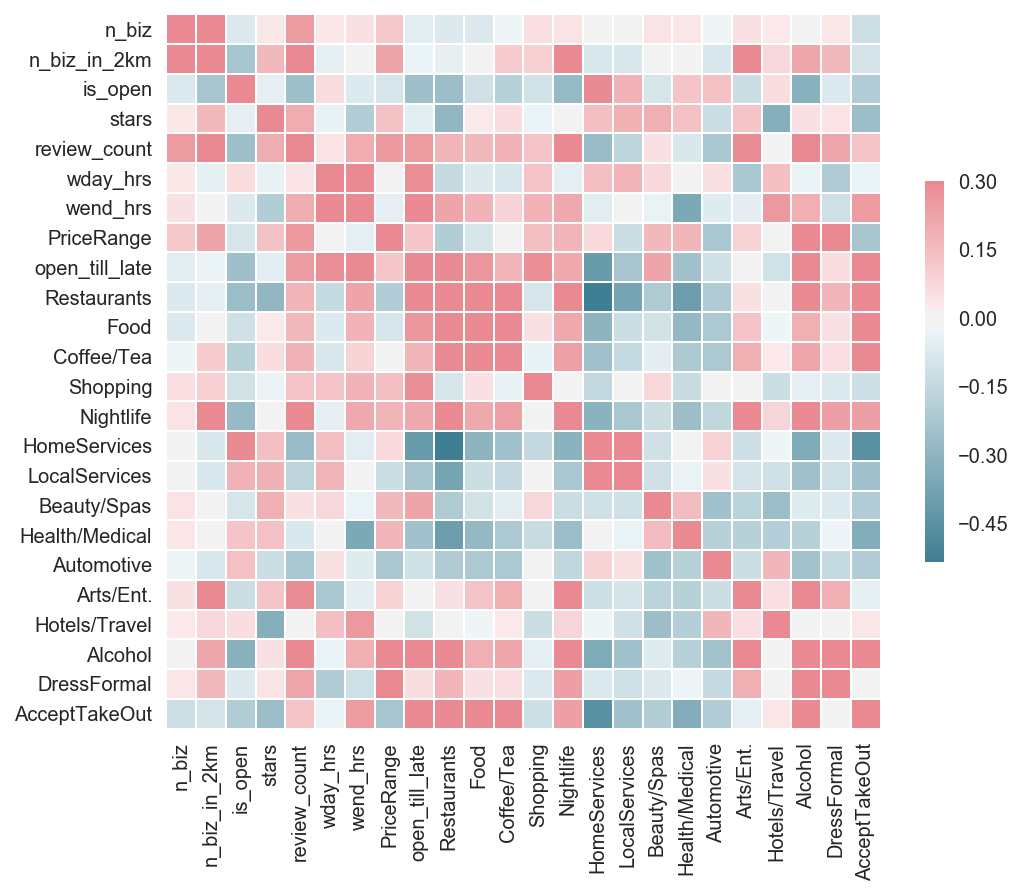

In [3]:
def plot_corr(stats):
    # Compute the correlation matrix
    corr = stats.corr()
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(8, 7))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, ax=ax,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return fig

fig = plot_corr(nbh_stats)
fig.savefig('../tex/nbh-corr.pdf', bbox_inches='tight')

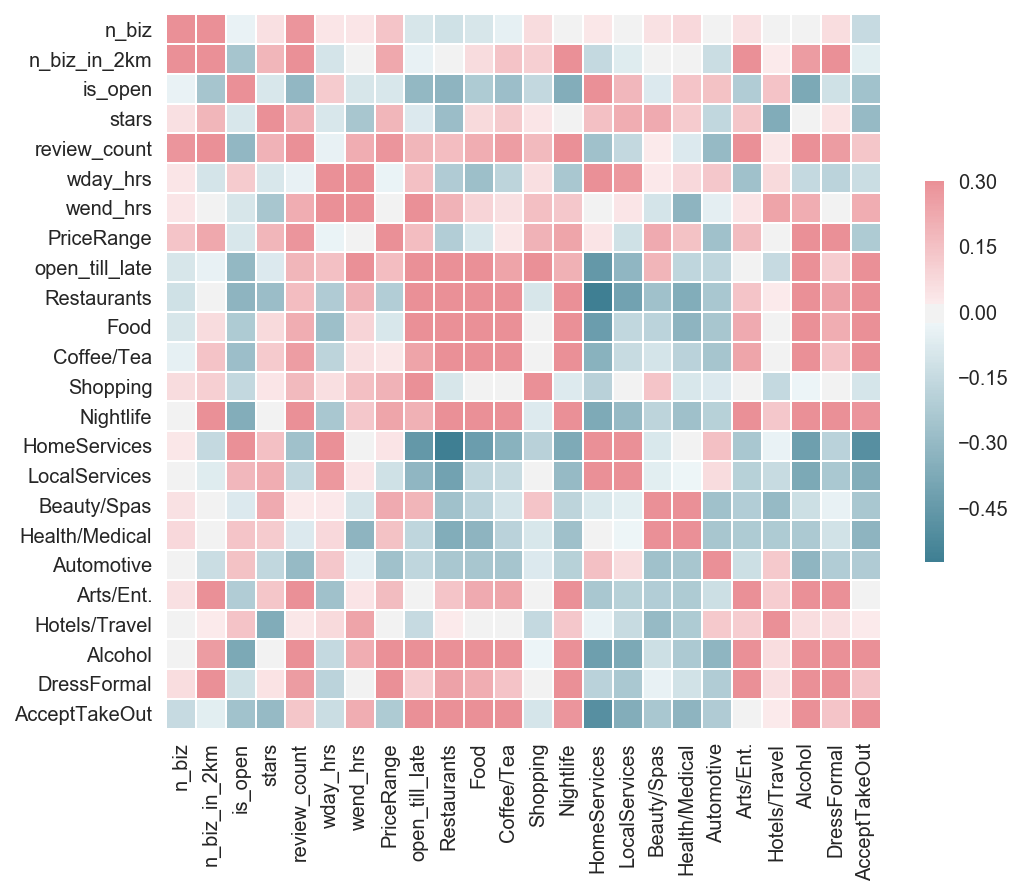

In [4]:
fig = plot_corr(nbh_stats_min_20)

### Histograms

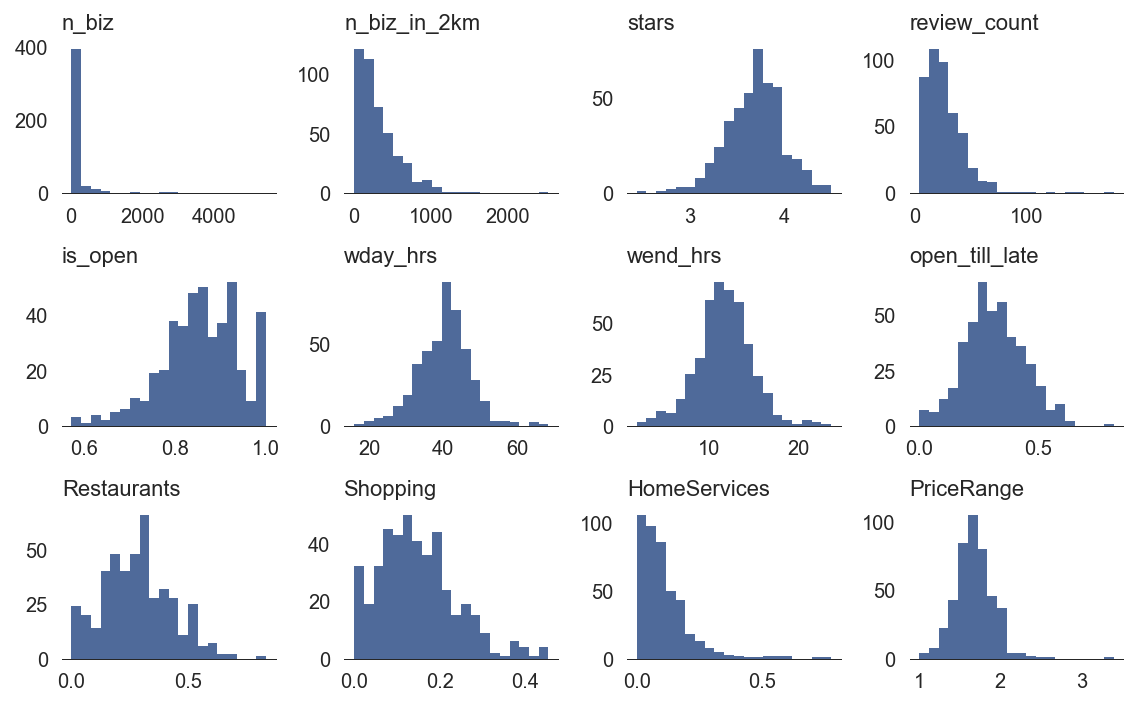

In [5]:
def plot_histo(stats):
    rs = np.random.RandomState(10)

    row = 3
    col = 4
    # Set up the matplotlib figure
    fig, axes = plt.subplots(row, col, figsize=(8, 5), sharex=False)
    sns.despine(left=True)

    # Plot a historgram and kernel density estimate
    features = ['n_biz',
                'n_biz_in_2km',
                'stars',
                'review_count',
                'is_open',
                'wday_hrs',
                'wend_hrs',
                'open_till_late',
                'Restaurants',
                'Shopping',
                'HomeServices',
                'PriceRange']

    i = j = 0
    for f in features:
        sns.distplot(stats.loc[:, f],
                     color='#4f6a9a',
                     kde=False, bins = 20,
                     ax=axes[i, j],
                     hist_kws={'alpha': 1})
        axes[i, j].set_xlabel('')
        axes[i, j].set_title(f, size=11, loc='left')
        if i < row and j+1 < col:  
            j+=1
        else:
            j=0
            i+=1

    plt.setp(axes)
    plt.tight_layout()
    return fig

fig = plot_histo(nbh_stats)
fig.savefig('../tex/nbh-histo.pdf', bbox_inches='tight')

<a name="nbh-kmeans"></a>

### K-means

#### Determine k

Before clustering, let's first determine the optimal number of clusters k using both SSE and Silhouette coefficient.

- SSE is the sum of the squared differences between each observation and its cluster's mean.
- Silhouette coefficient is used to study the separation distance between the resulting clusters.

In [6]:
def plot_silhouette(dat, model, n_clusters=4, ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    ax.set_xlim([-0.1, 1])

    ax.set_ylim([0, len(dat) + (n_clusters + 1) * 10])

    cluster_labels = model.predict(dat)
    
    # make sure labels are sorted by size
    label_reorder = {
        label: i
        for i, (label, count) in enumerate(reversed(Counter(cluster_labels).most_common()))
    }
    cluster_labels = np.array([label_reorder[x] for x in cluster_labels])

    silhouette_avg = silhouette_score(dat, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(dat, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10
        ax.set_title("Silhouettes for clusters")
        ax.set_xlabel("Silhouette coefficient")
        ax.set_ylabel("Cluster label")
        
        ax.axvline(x=silhouette_avg, color="red", linestyle="--", label='Average')
        ax.set_yticks([])
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# plot the sse and silhouette
def two_scales(ax1, k, data1, data2, c1, c2, i_lg):
    # optimal k has larger marker 
        
    sizes = [30] * len(data2)
    if i_lg is not None:
        sizes[i_lg] = 60

    ax2 = ax1.twinx()
    ax1.plot(k, data1, c=c1)
    ax1.scatter(k, data1, c=c1, s=sizes)
#     ax1.set_xticks([2, 5, 10, 15, 18])
    ax1.set_xlabel('k')
    ax1.set_ylabel('SSE', color=c1)
    
    ax2.plot(k, data2, c=c2)
    ax2.scatter(k, data2, c=c2, s=sizes)
    
    # display Silhouette as at least 0.5
    ax2.set_ylim([min(0, min(data2) * 1.2), 1 if max(data2) > 0.5 else 0.55])
    
    ax2.set_ylabel('Silhouette coefficient', color=c2)
    
    return ax1, ax2

# change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

def plot_two_scales(X, pick_k=None, ax=None):
    # k means determine k
    sse = []
    silhouette = []
    K = list(range(2,21))
    model = None
    for k in K:
        kmeanModel = KMeans(init='k-means++',n_clusters=k).fit(X)
        kmeanModel.fit(X)
        sse.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        labels = kmeanModel.labels_
        silhouette.append(silhouette_score(X, labels, metric='euclidean', sample_size=None, random_state=None))
        if k == pick_k:
            model = kmeanModel

    s1 = sse
    s2 = silhouette
    
    if ax is None:
        fig, ax = plt.subplots()
        
    i_lg = pick_k - 2 if pick_k is not None else None
    ax1, ax2 = two_scales(ax, K, s1, s2, 'b', 'r', i_lg)
    # plt.title('Selecting the optimal k for K-Means')
    color_y_axis(ax1, 'b')
    color_y_axis(ax2, 'r')
    ax.set_xticks(K, K)
    ax.set_title('Elbow test for optimal k')
    
    return model
    
def test_kmeans(X, pick_k=4):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.subplots_adjust(wspace=0.3)
    
    model = plot_two_scales(X, pick_k, ax=axes[0])
    plot_silhouette(X, model, pick_k, ax=axes[1])
    plt.show()
    
    return fig

For n_clusters = 4 The average silhouette_score is : 0.584448709895


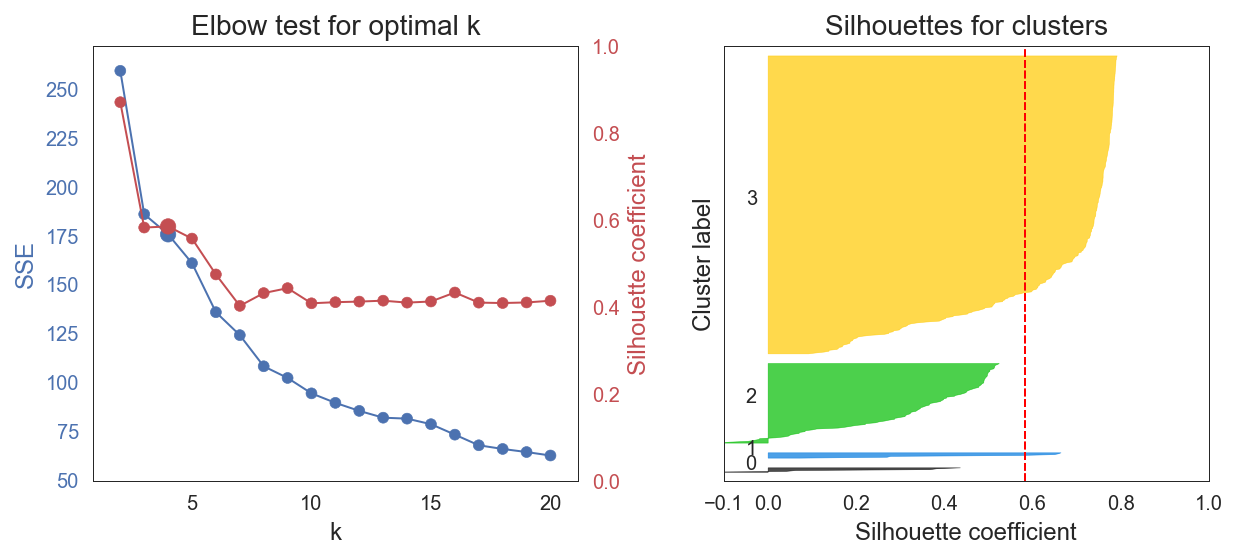

In [7]:
fig = test_kmeans(nbh_stats, pick_k=4)
fig.savefig('../tex/nbh-kmeans.pdf', bbox_inches='tight')

For n_clusters = 2 The average silhouette_score is : 0.870122072037


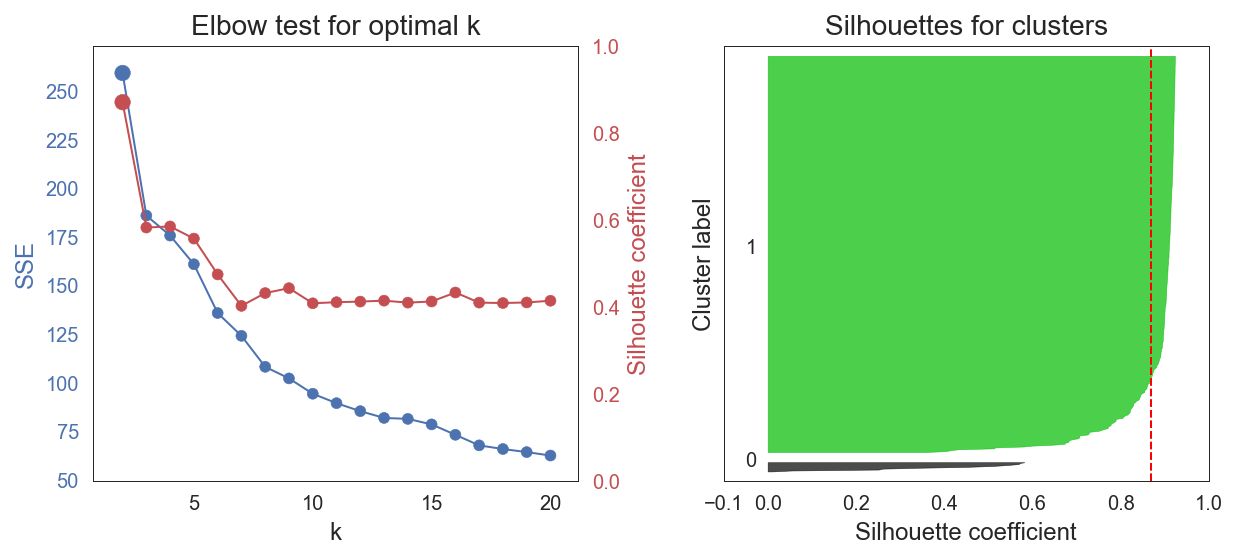

In [8]:
fig = test_kmeans(nbh_stats, pick_k=2)

The silouett is good, but the clustering is meaningless. We certainly do not want to cluster neighborhoods only according to its size and business densitiy.

#### Fit model and report centroids

In [9]:
import re

def fit_and_report(X, model, X_orig=None):
    """
    Fit the model and report (with original unscaled data, if provide)
    """
    model.fit(X)
    labels_km = model.labels_
    
    if X_orig is not None:
        labels = pd.DataFrame({'cluster': labels_km})
        labels.index = X_orig.index
        X_ref = pd.concat([labels, X_orig], axis=1)
        centroids = X_ref.groupby('cluster').mean()
    else:
        
        centroids = model.cluster_centers_
    
    labels_count = pd.Series(model.labels_).value_counts()
    centroids_df = pd.concat([pd.DataFrame(labels_count), pd.DataFrame(centroids)], axis=1)
    centroids_df.columns = ['n', *X.columns]
    centroids_df = round(centroids_df.sort_values("n"), 2)
    return centroids_df
    
def simple_column_names(x):
    if x == 'Arts/Entertainment':
        return 'Arts/Ent.'
    if x == 'Health/Medical':
        return 'Health/Medic'
    return x.replace('Restaurants', 'Rest')

def split_print(fitted, to_latex=False, seps=[9, 17]):
    """Slit the centroids data frame and pretty print"""
    fitted.columns = fitted.columns.map(simple_column_names)
    total = fitted.shape[1]
    seps = [1] + seps + [total]
    pd.set_option('display.max_rows', 10)
    last = len(seps) - 1
    for i in range(last):
        if seps[i] > total:
            break
        df = pd.concat([fitted.iloc[:,0], fitted.iloc[:,(seps[i]):(seps[i+1])]], axis=1)
        if to_latex:
            txt = df.to_latex()
            if i > 0:
                txt = re.sub(r"\\begin\{tabular\}.*\n\\toprule\n""", '', txt)
            if i < last - 1:
                txt = re.sub(r"\\bottomrule\n\\end{tabular}\n""", '\\midrule', txt)
            print(txt)
        else:
            display(df)
    pd.set_option('display.max_rows', 5)
    
def fit_kmeans(X, n_clusters=4):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
    fitted = fit_and_report(X, kmeans)
    fitted = fitted.reset_index(drop=True)
    return fitted

fitted = fit_kmeans(nbh_stats)
split_print(fitted)

n    n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  \
0    6  3600.67       1096.05     0.81   3.80         66.53     41.67   
1    7  1713.86        485.48     0.84   3.70         37.31     40.10   
2   91   188.30        710.38     0.83   3.76         38.47     39.11   
3  338    57.40        201.81     0.86   3.67         23.61     40.46   

   wend_hrs  PriceRange  
0     12.72        1.93  
1     11.60        1.66  
2     11.67        1.72  
3     11.75        1.66

n  open_till_late  Rest  Food  Coffee/Tea  Shopping  Nightlife  \
0    6            0.29  0.23  0.11        0.02      0.17       0.09   
1    7            0.26  0.22  0.11        0.02      0.17       0.05   
2   91            0.30  0.29  0.15        0.03      0.15       0.10   
3  338            0.32  0.28  0.14        0.02      0.15       0.05   

   HomeServices  LocalServices  
0          0.10           0.06  
1          0.14           0.09  
2          0.11           0.07  
3          0.11           0.08

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
0    6         0.13          0.11        0.05       0.05           0.04   
1    7         0.09          0.09        0.09       0.03           0.04   
2   91         0.09          0.07        0.07       0.06           0.03   
3  338         0.10          0.09        0.08       0.02           0.03   

   Alcohol  DressFormal  AcceptTakeOut  
0     0.16         0.01           0.22  
1     0.10         0.00           0.23  
2     0.16         0.01           0.30  
3     0.12         0.00           0.31

In [10]:
split_print(fitted, True)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &    n &    n\_biz &  n\_biz\_in\_2km &  is\_open &  stars &  review\_count &  wday\_hrs &  wend\_hrs &  PriceRange \\
\midrule
0 &    6 &  3600.67 &       1096.05 &     0.81 &   3.80 &         66.53 &     41.67 &     12.72 &        1.93 \\
1 &    7 &  1713.86 &        485.48 &     0.84 &   3.70 &         37.31 &     40.10 &     11.60 &        1.66 \\
2 &   91 &   188.30 &        710.38 &     0.83 &   3.76 &         38.47 &     39.11 &     11.67 &        1.72 \\
3 &  338 &    57.40 &        201.81 &     0.86 &   3.67 &         23.61 &     40.46 &     11.75 &        1.66 \\
\midrule
{} &    n &  open\_till\_late &  Rest &  Food &  Coffee/Tea &  Shopping &  Nightlife &  HomeServices &  LocalServices \\
\midrule
0 &    6 &            0.29 &  0.23 &  0.11 &        0.02 &      0.17 &       0.09 &          0.10 &           0.06 \\
1 &    7 &            0.26 &  0.22 &  0.11 &        0.02 &      0.17 &       0.05 &          0.14 &           0.09 \\
2 &  

#### Visualize PCA reduced data

In [11]:
# Visualize the results on PCA-reduced data
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, scale, minmax_scale, quantile_transform

def transform_df(transformer, *args, **kwargs):
    def func(X):
        return pd.DataFrame(transformer(X, *args, **kwargs),
                            index=X.index, columns=X.columns)
    return func
    
# Transform a data frame, but keep its columns and indices
normalized = transform_df(normalize)
normalized_by_feature = transform_df(normalize, axis=0)
standardized = transform_df(scale)
quantile_transformed = transform_df(quantile_transform)
minmax_scaled = transform_df(minmax_scale)
    

def pca_reduced_data(data, dim=2):
    pca_model = PCA(n_components=dim)
    reduced_data = pd.DataFrame(pca_model.fit_transform(standardized(data)))
    print('PCA explained ratio:', np.cumsum(pca_model.explained_variance_ratio_))
    reduced_data.columns = ['pc{}'.format(i) for i in range(1, reduced_data.shape[1] + 1)]
    reduced_data.index = data.index
    return reduced_data
    
def pca_reduced(data, n_clusters=6, ax=None, title=None, display_silhouette=True):
    
    model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    reduced_data = pca_reduced_data(data).values
    model.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() * 1.2, reduced_data[:, 0].max() * 1.2
    y_min, y_max = reduced_data[:, 1].min() * 1.2, reduced_data[:, 1].max() * 1.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    
    ax.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Pastel1,
               aspect='auto', origin='lower')
    ax.plot(reduced_data[:, 0],
             reduced_data[:, 1], 'k.',
             markersize=4)
    # Plot the centroids as a white X
    centroids = model.cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=100, linewidths=3,
                color='w', zorder=10)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    
    if display_silhouette:
        silhouette = silhouette_score(reduced_data, model.labels_, metric='euclidean')
        ax.set_xlabel(f'Sihouette: {silhouette:.2f}')
    
    return ax

Without normalization:
PCA explained ratio: [ 0.19548373  0.31157195]
With normalization
PCA explained ratio: [ 0.44658121  0.52423573]


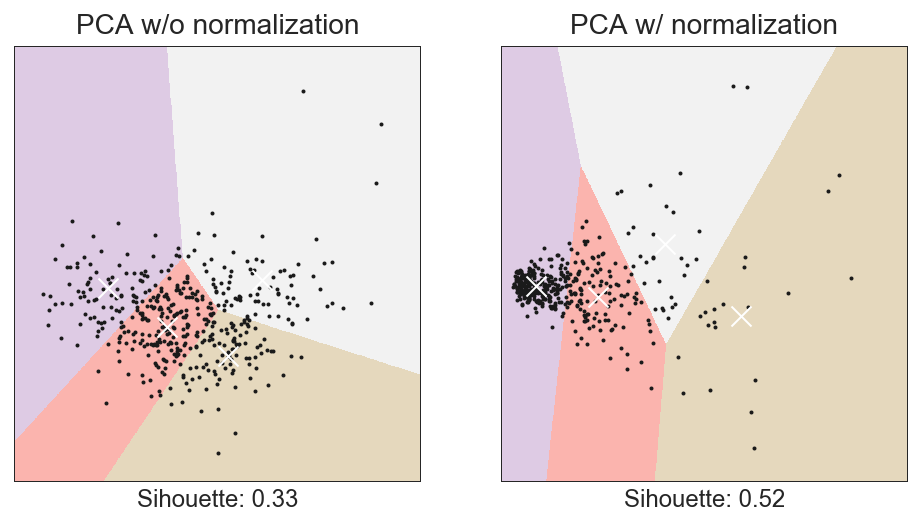

In [12]:
def pca_compare(X, n_clusters=4):
    """Compre 2-dim PCA with/without normalization"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=False)

    print('Without normalization:')
    pca_reduced(X, n_clusters=n_clusters, ax=ax1, title='PCA w/o normalization')
    
    print('With normalization')
    pca_reduced(normalized(X), n_clusters=n_clusters, ax=ax2, title='PCA w/ normalization')
    
    return fig

fig = pca_compare(nbh_stats)
fig.savefig('../tex/nbh-pca.pdf', bbox_inches='tight')

### With Preprocessing


In [13]:
def fit_processed(X, model, process_func=standardized):
    """
    Fit the processed data, but report with the original data
    """
    X_prime = process_func(X)
    fig = test_kmeans(X_prime, model.n_clusters)
    return fig, fit_and_report(X_prime, model, X)


def kmeans_and_pca(data, n_clusters=4):
    print('Original:')
    fig1 = test_kmeans(data, n_clusters)
    model = KMeans(n_clusters=n_clusters)
    fitted1 = fit_and_report(data, model)
    print('Normalized:')
    fig2, fitted2 = fit_processed(data, model, normalized)
    print('Original vs Normalized on PCA:')
    fig3 = pca_compare(data, n_clusters=n_clusters)
    return fig1, fig2, fig3, fitted1, fitted2, model

#### Standardized

Removing mean and deviding my variance made it harder to separate clusters.

Original:
For n_clusters = 4 The average silhouette_score is : 0.100579215397


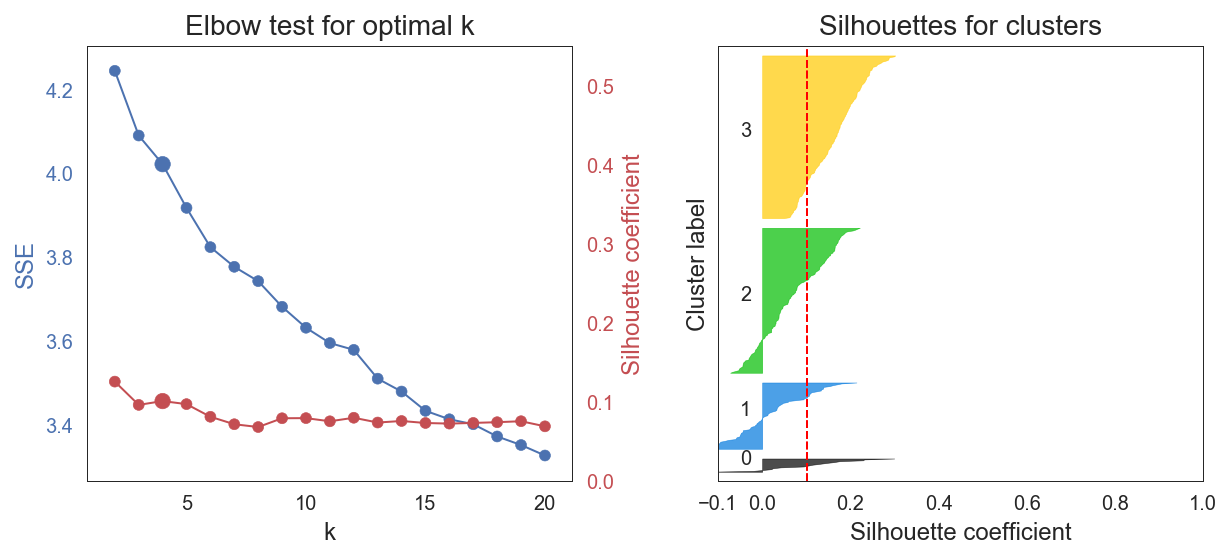

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.0965312895664


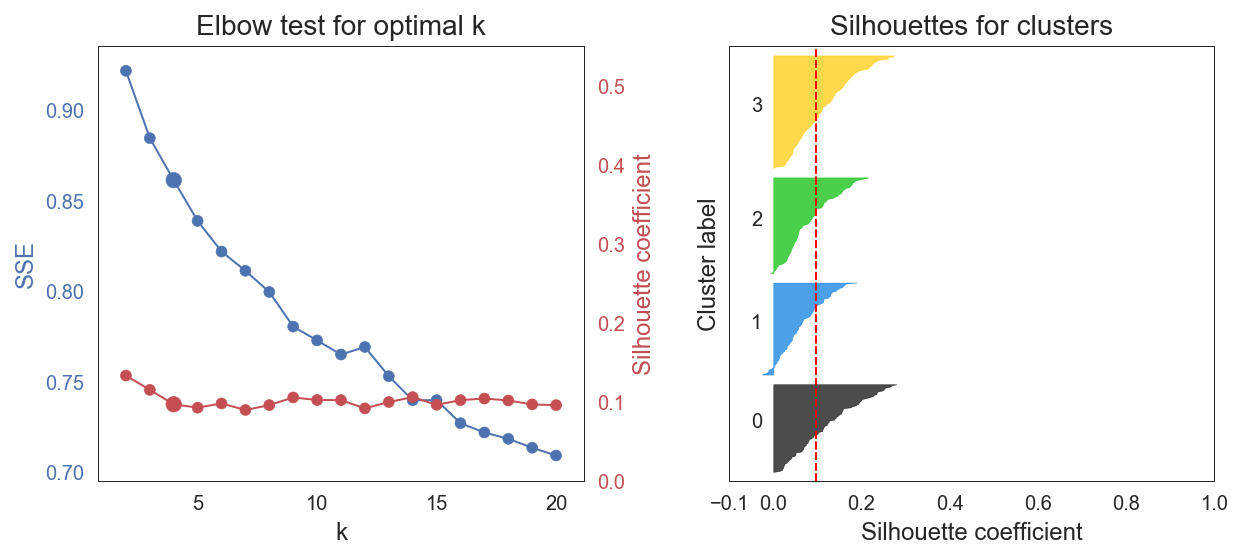

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.19548373  0.31157195]
With normalization
PCA explained ratio: [ 0.18650188  0.30506163]


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  wend_hrs  \
2   16  -0.24         -0.22     0.36  -1.46         -0.30      0.95      1.19   
1   76   0.25          1.02    -0.67   0.34          1.10     -0.49      0.01   
0  165   0.11         -0.01     0.34   0.39         -0.23     -0.03     -0.44   
3  185  -0.18         -0.39    -0.06  -0.36         -0.22      0.14      0.29   

   PriceRange  
2       -0.00  
1        0.46  
0        0.04  
3       -0.22

n  open_till_late  Rest  Food  Coffee/Tea  Shopping  Nightlife  \
2   16           -0.14 -0.11 -0.38       -0.17     -0.28      -0.17   
1   76            0.27  0.63  0.70        0.92     -0.07       1.31   
0  165           -0.67 -0.87 -0.51       -0.40     -0.16      -0.50   
3  185            0.49  0.52  0.20       -0.01      0.20      -0.07   

   HomeServices  LocalServices  
2         -0.18          -0.38  
1         -0.58          -0.43  
0          0.67           0.54  
3         -0.35          -0.27

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
2   16        -0.94         -0.44        0.49      -0.24           4.06   
1   76        -0.28         -0.42       -0.39       1.18           0.06   
0  165         0.22          0.50        0.11      -0.18          -0.22   
3  185         0.01         -0.23        0.02      -0.31          -0.18   

   Alcohol  DressFormal  AcceptTakeOut  
2    -0.29        -0.19           0.21  
1     1.17         0.78           0.49  
0    -0.59        -0.14          -0.82  
3     0.07        -0.18           0.51

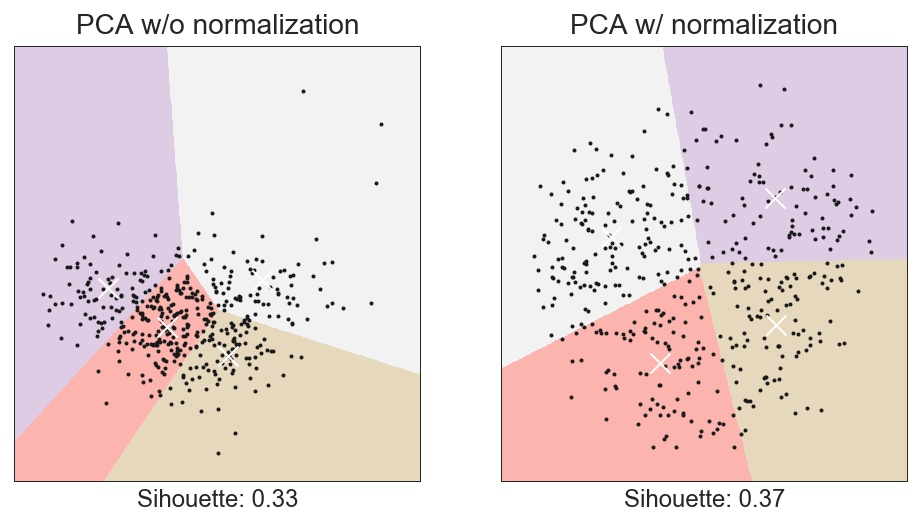

In [14]:
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(standardized(nbh_stats))
fig1.savefig('../tex/nbh-kmeans-standardized.pdf', bbox_inches='tight')
split_print(fitted1)

#### MinMaxScaled

Original:
For n_clusters = 4 The average silhouette_score is : 0.0845007735644


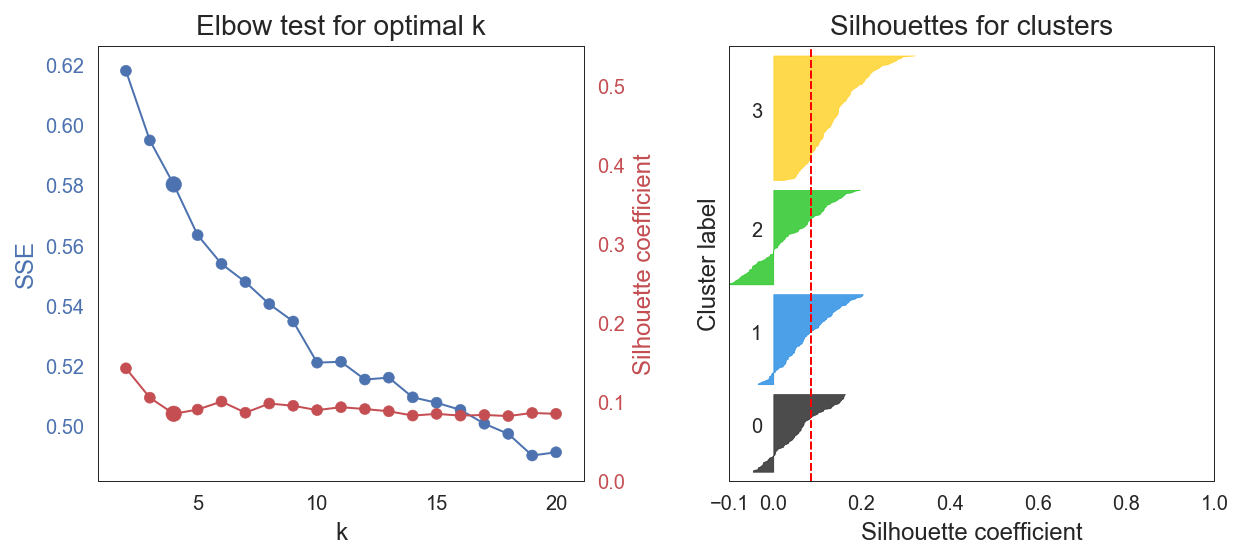

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.101205801013


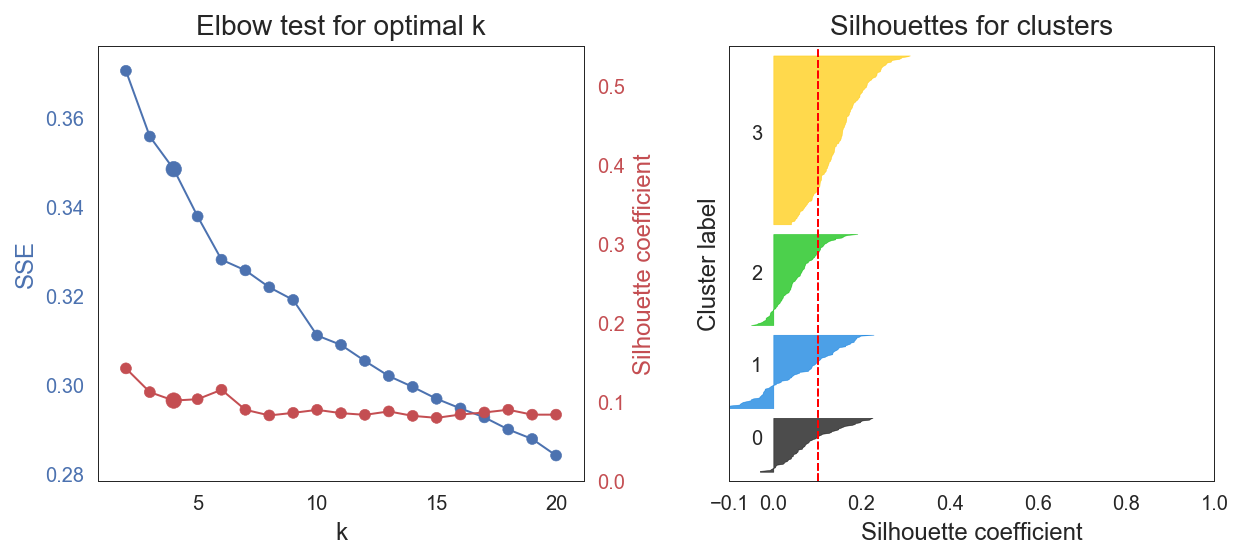

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.19548373  0.31157195]
With normalization
PCA explained ratio: [ 0.19053955  0.30959174]


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  wend_hrs  \
2   89   0.01          0.09     0.81   0.61          0.07      0.50      0.45   
3  103   0.07          0.15     0.68   0.67          0.13      0.42      0.34   
0  108   0.02          0.15     0.59   0.61          0.18      0.40      0.45   
1  142   0.02          0.11     0.61   0.56          0.14      0.52      0.53   

   PriceRange  
2        0.24  
3        0.30  
0        0.28  
1        0.29

n  open_till_late  Rest  Food  Coffee/Tea  Shopping  Nightlife  \
2   89            0.27  0.21  0.19        0.07      0.27       0.04   
3  103            0.30  0.21  0.18        0.10      0.28       0.05   
0  108            0.42  0.53  0.38        0.34      0.23       0.19   
1  142            0.49  0.37  0.28        0.12      0.46       0.10   

   HomeServices  LocalServices  
2          0.29           0.31  
3          0.16           0.17  
0          0.06           0.11  
1          0.10           0.14

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
2   89         0.09          0.07        0.23       0.06           0.10   
3  103         0.25          0.27        0.09       0.08           0.03   
0  108         0.10          0.05        0.07       0.17           0.09   
1  142         0.20          0.09        0.11       0.06           0.06   

   Alcohol  DressFormal  AcceptTakeOut  
2     0.10         0.00           0.28  
3     0.13         0.01           0.27  
0     0.32         0.04           0.59  
1     0.21         0.01           0.44

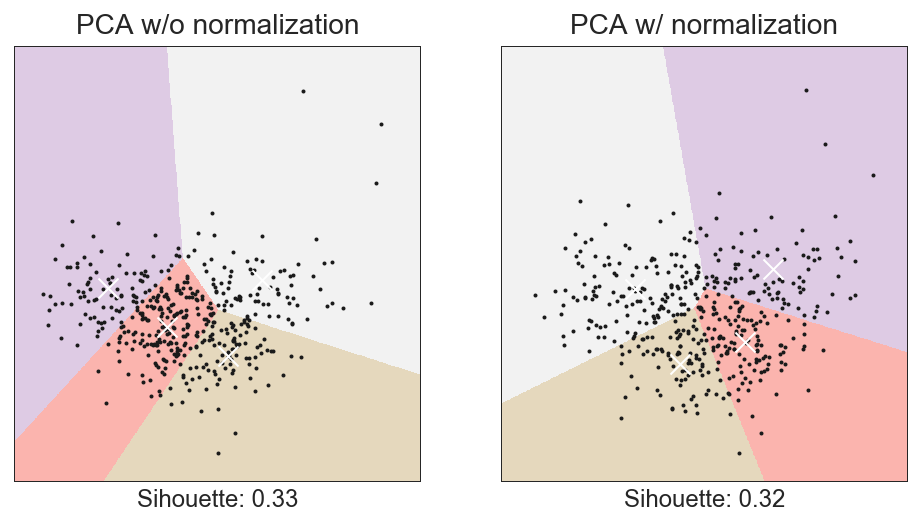

In [15]:
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(minmax_scaled(nbh_stats))
split_print(fitted1)

#### Non-linear transformation -> to quantiles

Original:
For n_clusters = 4 The average silhouette_score is : 0.0988187249087


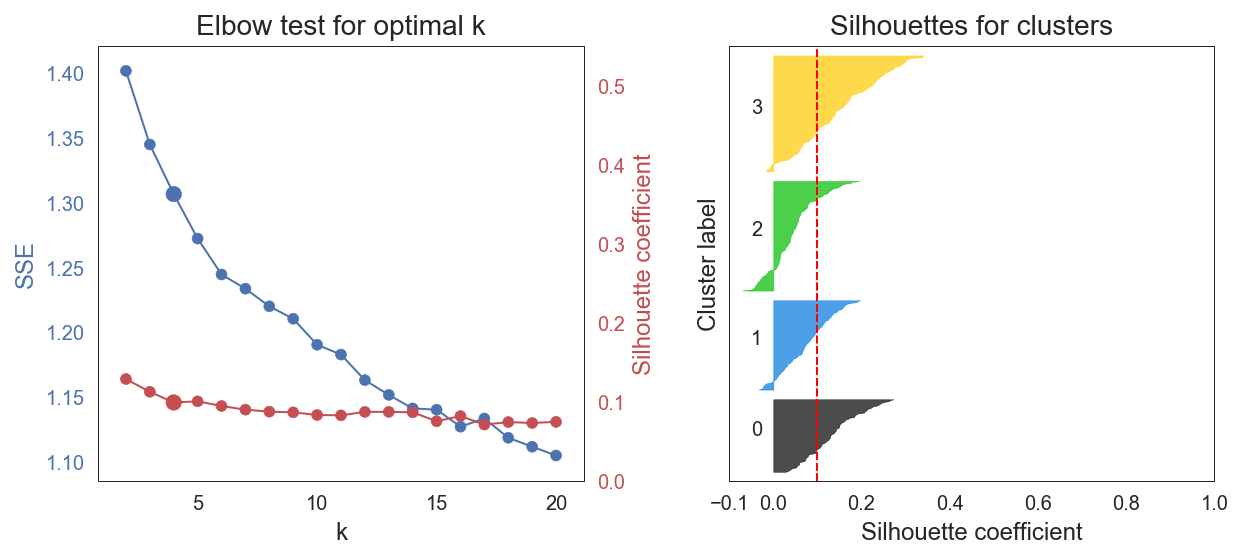

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.0797163326419


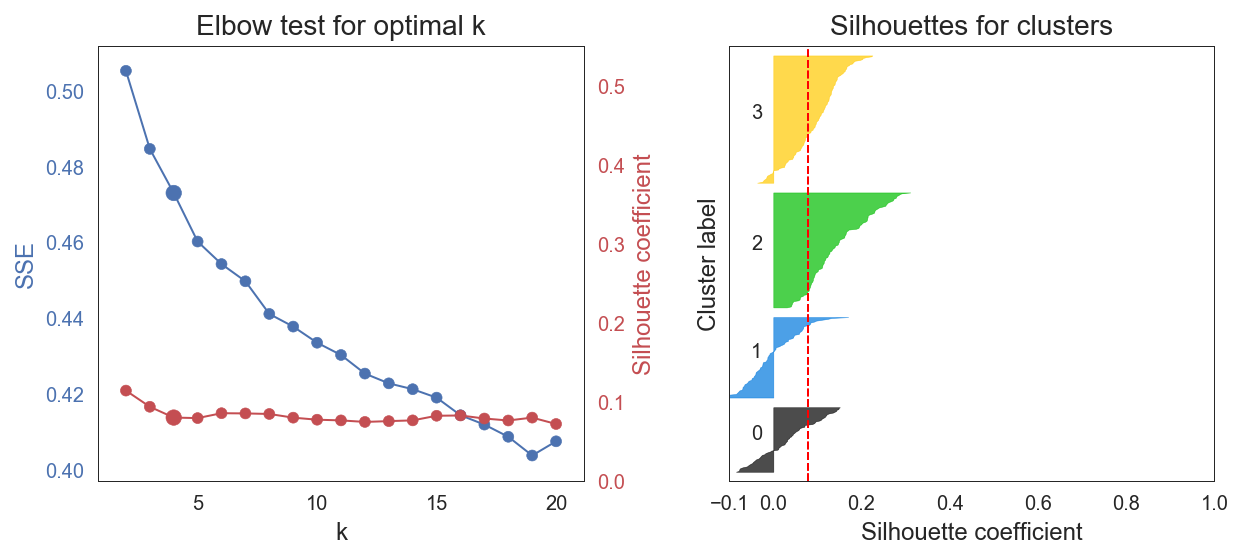

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.20586254  0.33796299]
With normalization
PCA explained ratio: [ 0.17716097  0.30668103]


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  wend_hrs  \
3   83   0.64          0.55     0.61   0.47          0.43      0.61      0.54   
0  102   0.34          0.49     0.62   0.61          0.39      0.48      0.32   
2  125   0.35          0.30     0.51   0.39          0.38      0.49      0.54   
1  132   0.68          0.67     0.34   0.54          0.75      0.46      0.58   

   PriceRange  
3        0.51  
0        0.54  
2        0.32  
1        0.64

n  open_till_late  Rest  Food  Coffee/Tea  Shopping  Nightlife  \
3   83            0.34  0.26  0.33        0.31      0.52       0.38   
0  102            0.34  0.23  0.33        0.25      0.45       0.21   
2  125            0.60  0.72  0.59        0.36      0.47       0.38   
1  132            0.63  0.64  0.65        0.67      0.55       0.75   

   HomeServices  LocalServices  
3          0.74           0.67  
0          0.65           0.60  
2          0.36           0.39  
1          0.34           0.40

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
3   83         0.41          0.47        0.70       0.51           0.72   
0  102         0.59          0.69        0.37       0.25           0.04   
2  125         0.44          0.32        0.53       0.15           0.24   
1  132         0.50          0.45        0.37       0.69           0.53   

   Alcohol  DressFormal  AcceptTakeOut  
3     0.31         0.24           0.25  
0     0.30         0.01           0.28  
2     0.49         0.01           0.73  
1     0.76         0.44           0.61

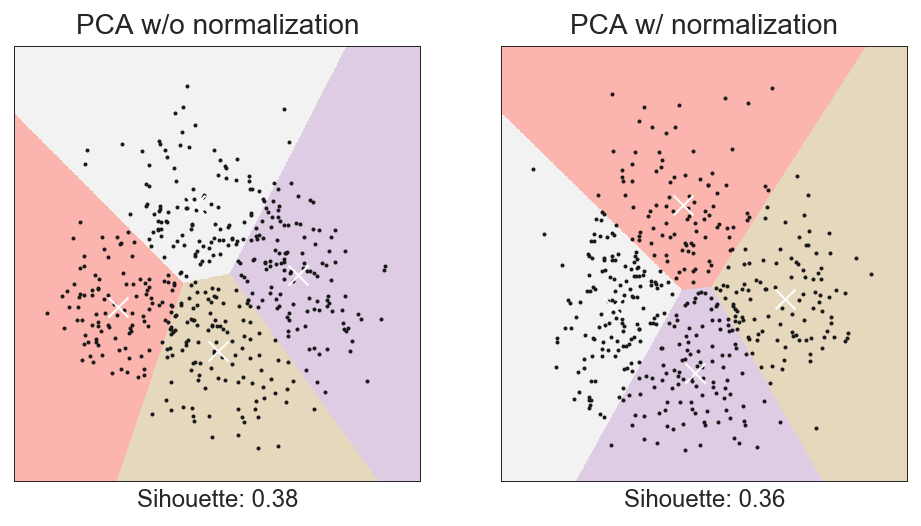

In [16]:
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(quantile_transformed(nbh_stats))
split_print(fitted1)

#### Normalized by features

(This is actually not a good idea. Because it would change the ranking of some variables for some observations.)

Original:
For n_clusters = 3 The average silhouette_score is : 0.228060182499


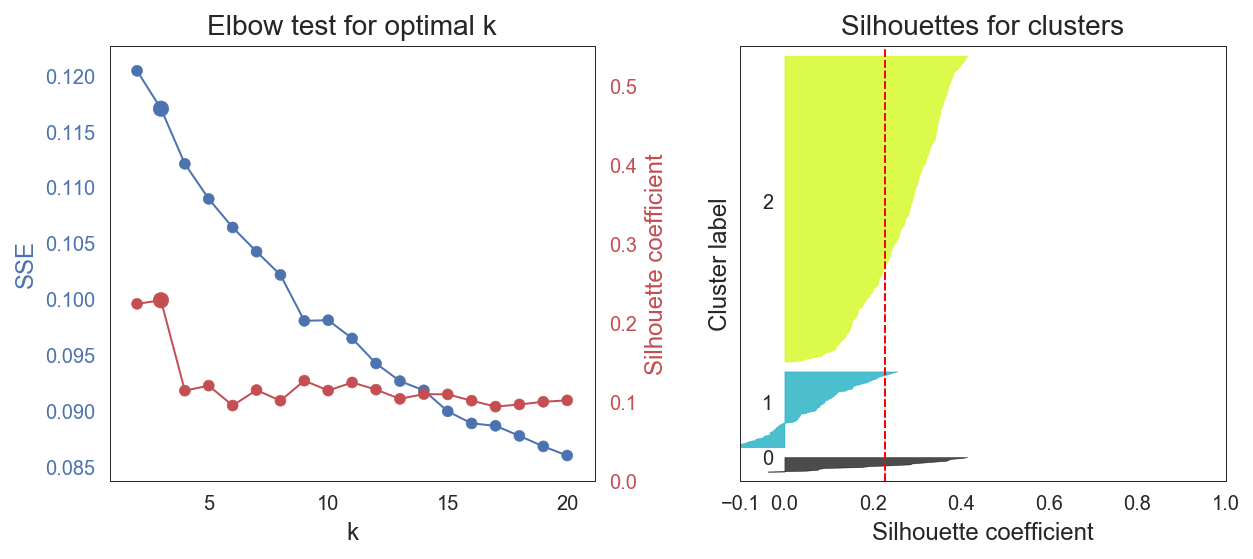

Normalized:
For n_clusters = 3 The average silhouette_score is : 0.100301133881


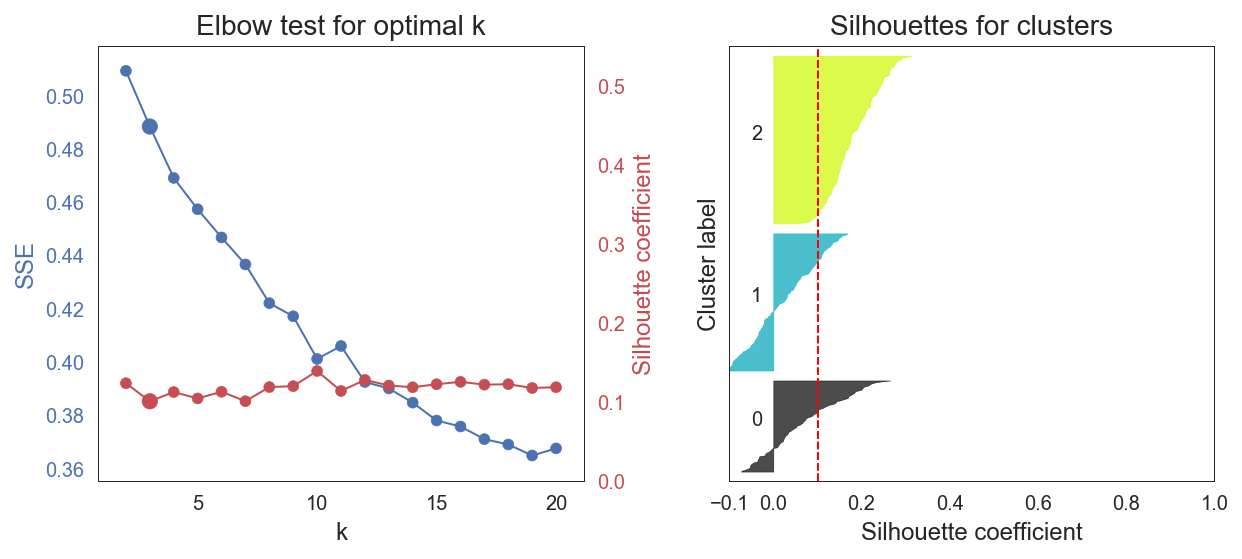

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.19548373  0.31157195]
With normalization
PCA explained ratio: [ 0.19701231  0.35552747]


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  wend_hrs  \
2   17   0.00          0.03     0.05   0.04          0.03      0.05      0.06   
1   85   0.02          0.06     0.04   0.05          0.06      0.04      0.05   
0  340   0.01          0.03     0.05   0.05          0.03      0.05      0.04   

   PriceRange  
2        0.05  
1        0.05  
0        0.05

n  open_till_late  Rest  Food  Coffee/Tea  Shopping  Nightlife  \
2   17            0.04  0.04  0.03        0.03      0.03       0.02   
1   85            0.05  0.06  0.06        0.07      0.04       0.08   
0  340            0.04  0.04  0.04        0.02      0.04       0.02   

   HomeServices  LocalServices  
2          0.03           0.02  
1          0.02           0.03  
0          0.04           0.04

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
2   17         0.01          0.01        0.05       0.02           0.19   
1   85         0.03          0.01        0.02       0.07           0.02   
0  340         0.04          0.03        0.03       0.02           0.01   

   Alcohol  DressFormal  AcceptTakeOut  
2     0.03         0.00           0.05  
1     0.07         0.04           0.05  
0     0.03         0.00           0.04

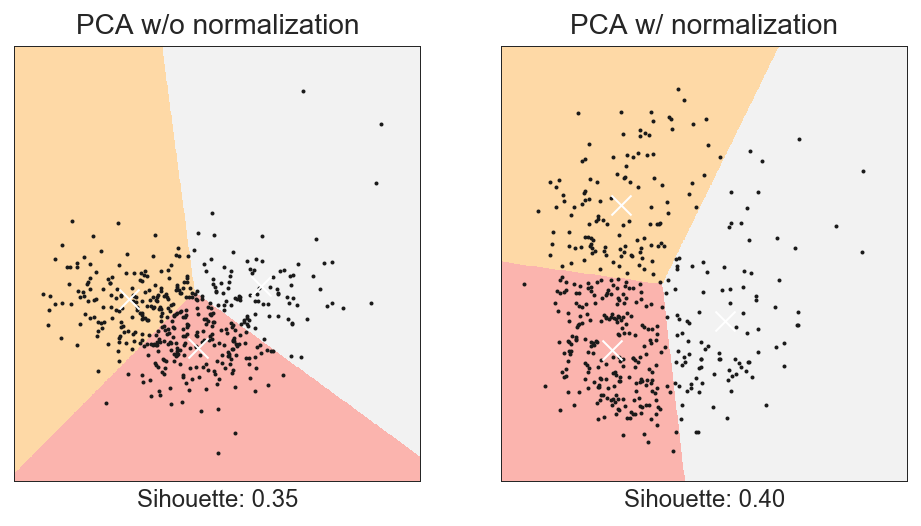

In [17]:
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(
    normalized_by_feature(nbh_stats),
    n_clusters=3
)
split_print(fitted1)
fig1.savefig('../tex/nbh-cluster-normalized.pdf', bbox_inches='tight')

The effect is very similar to standardization.

####  Log transformation

How about changing the counts to log values?

Original:
For n_clusters = 4 The average silhouette_score is : 0.582914386913


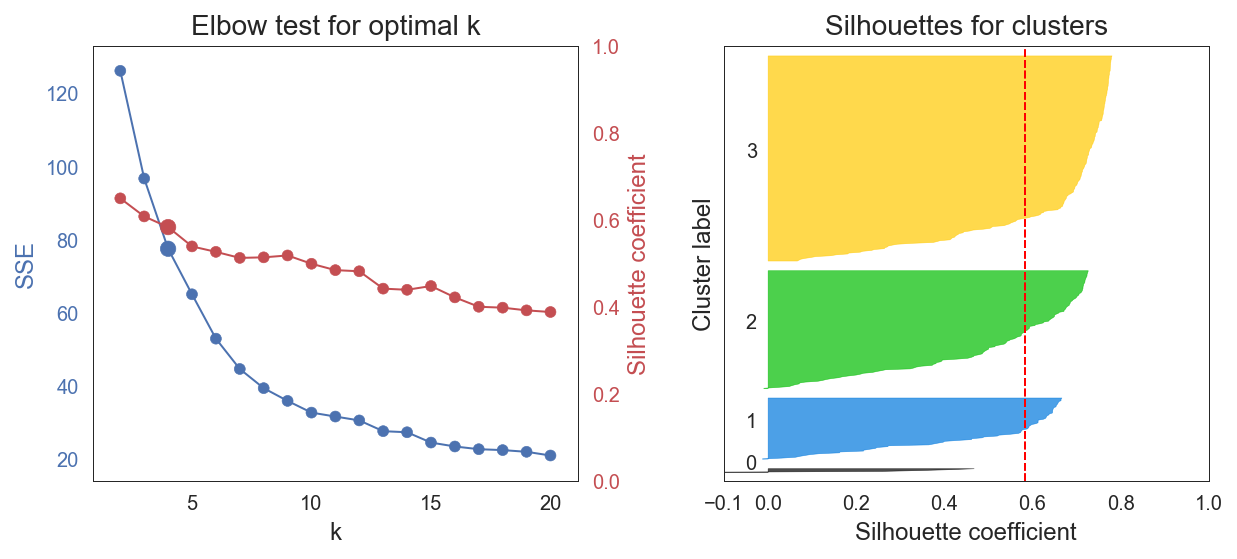

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.526055991575


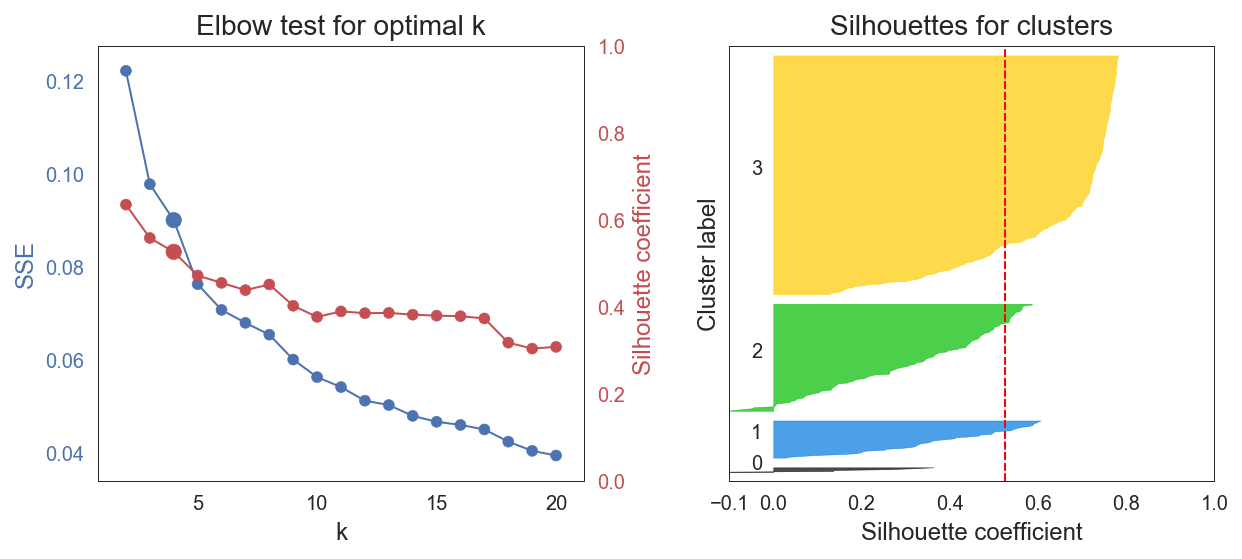

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.19640327  0.31335501]
With normalization
PCA explained ratio: [ 0.50946174  0.58974384]


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  wend_hrs  \
1    5   6.38       1600.58     0.80   3.76         74.29     41.39     13.87   
3   70   4.57        753.15     0.83   3.73         40.64     39.17     11.75   
2  134   3.96        386.67     0.84   3.79         30.13     39.79     11.19   
0  233   3.46        130.02     0.87   3.63         20.98     40.70     12.02   

   PriceRange  
1        2.00  
3        1.72  
2        1.70  
0        1.64

n  open_till_late  Rest  Food  Coffee/Tea  Shopping  Nightlife  \
1    5            0.32  0.30  0.14        0.04      0.19       0.19   
3   70            0.30  0.30  0.15        0.03      0.15       0.10   
2  134            0.31  0.24  0.13        0.03      0.16       0.05   
0  233            0.32  0.30  0.15        0.02      0.14       0.05   

   HomeServices  LocalServices  
1          0.06           0.05  
3          0.09           0.06  
2          0.11           0.08  
0          0.11           0.08

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
1    5         0.08          0.04        0.04       0.09           0.07   
3   70         0.09          0.07        0.07       0.06           0.04   
2  134         0.11          0.11        0.07       0.03           0.02   
0  233         0.09          0.08        0.08       0.02           0.03   

   Alcohol  DressFormal  AcceptTakeOut  
1     0.26         0.02           0.27  
3     0.16         0.01           0.31  
2     0.12         0.01           0.26  
0     0.12         0.00           0.33

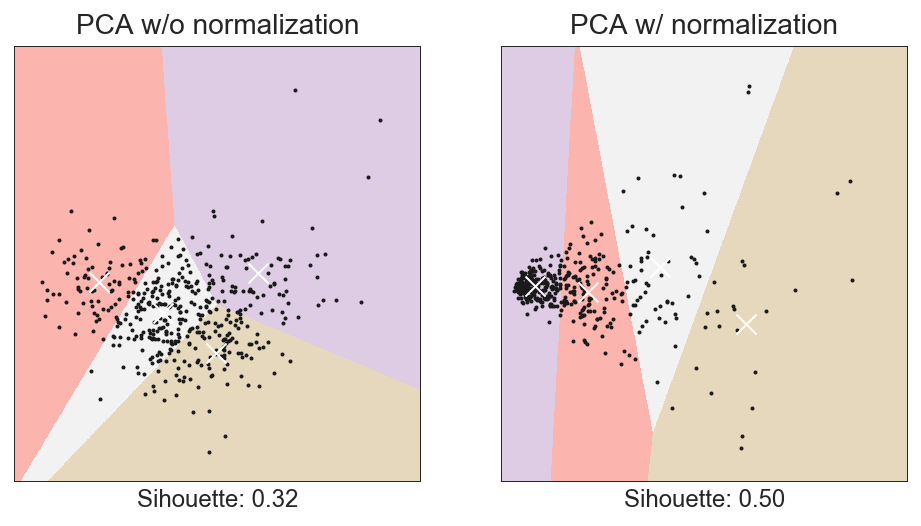

In [18]:
logged = nbh_stats.copy()
for col in ['n_biz']:
    logged[col] = np.log(logged[col])
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(logged, n_clusters=4)
split_print(fitted1)

We did see some improvements in terms of PCA variance if we apply log transformation to the variable `n_biz` only.

### Variable selection

How about we pick only a few most relevant variables?

#### Remove noise variables

What it we drop the number of businesses, the most skewed variable? This variable is skewed also because the sizes of neighborhoods vary a lot.

Original:
For n_clusters = 4 The average silhouette_score is : 0.421073691501


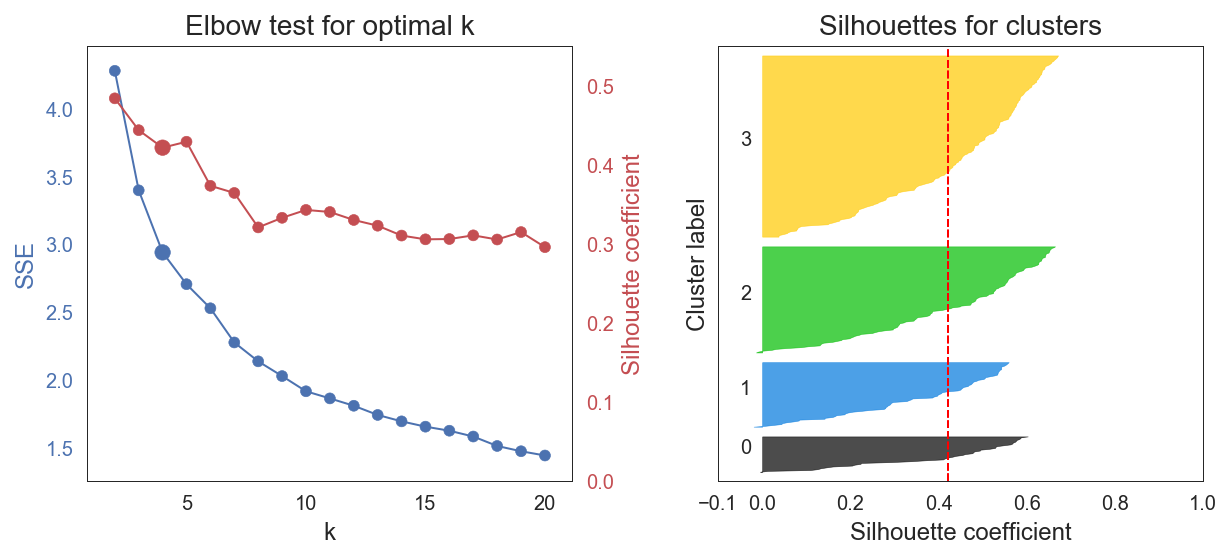

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.372866590028


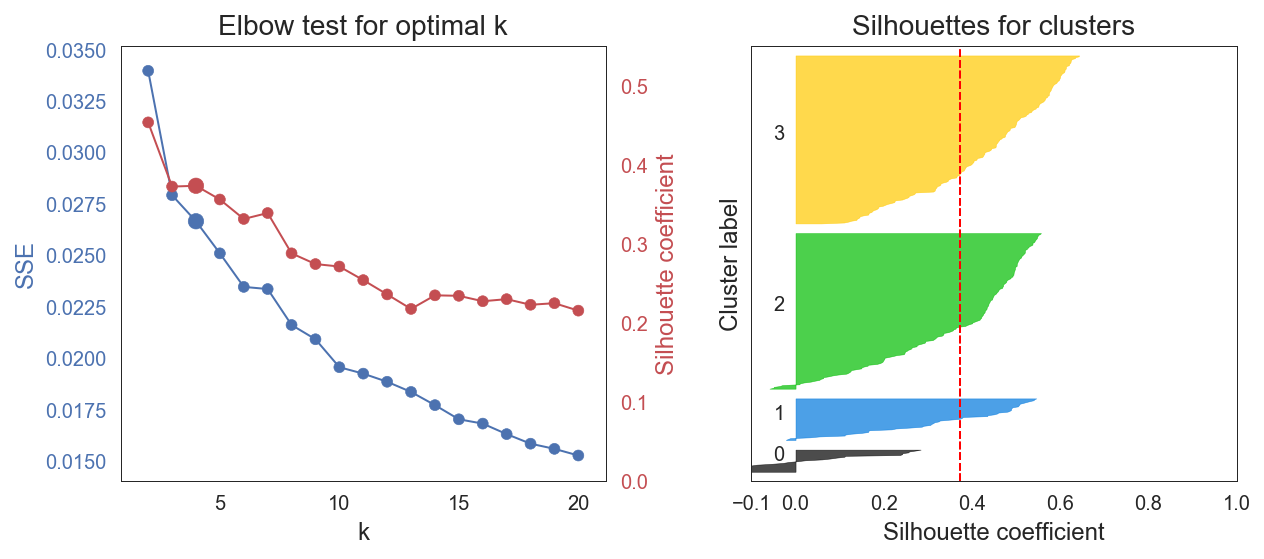

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.21143891  0.32811723]
With normalization
PCA explained ratio: [ 0.24005425  0.40325668]


n  is_open  stars  wday_hrs  wend_hrs  PriceRange  open_till_late  Rest  \
0   41     0.85   3.71     26.79      6.98        1.64            0.22  0.29   
3   74     0.87   3.66     50.28     15.66        1.68            0.39  0.28   
2  121     0.86   3.69     35.22     10.09        1.68            0.30  0.32   
1  206     0.85   3.70     42.15     12.26        1.67            0.32  0.26   

   Food  
0  0.14  
3  0.15  
2  0.16  
1  0.13

n  Coffee/Tea  Shopping  Nightlife  HomeServices  LocalServices  \
0   41        0.02      0.10       0.05          0.13           0.06   
3   74        0.03      0.16       0.06          0.14           0.09   
2  121        0.03      0.14       0.07          0.08           0.06   
1  206        0.02      0.15       0.05          0.11           0.08   

   Beauty/Spas  Health/Medic  Automotive  
0         0.07          0.11        0.09  
3         0.09          0.07        0.07  
2         0.09          0.09        0.06  
1         0.11          0.09        0.08

n  Arts/Ent.  Hotels/Travel  Alcohol  DressFormal  AcceptTakeOut
0   41       0.04           0.02     0.11         0.01           0.27
3   74       0.02           0.04     0.14         0.00           0.32
2  121       0.04           0.03     0.14         0.01           0.33
1  206       0.03           0.03     0.12         0.00           0.29

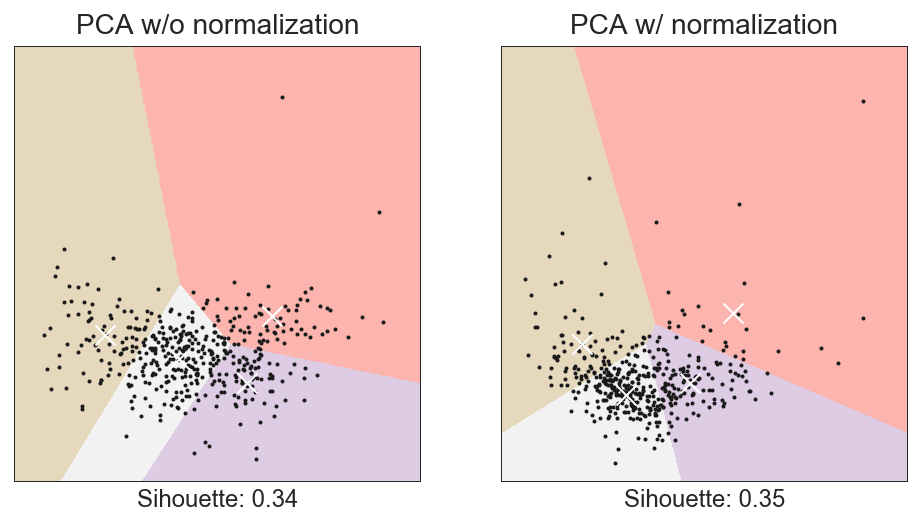

In [19]:
nbh_stats_wo_biz_count = nbh_stats.drop(['n_biz', 'n_biz_in_2km', 'review_count'], axis=1)
fig1, fig2, fi3, fitted1, fitted2, model = kmeans_and_pca(nbh_stats_wo_biz_count)
split_print(fitted1)

Doesn't seem to help.

Maybe hand-pick some of the most interesting one?

Original:
For n_clusters = 4 The average silhouette_score is : 0.122516846193


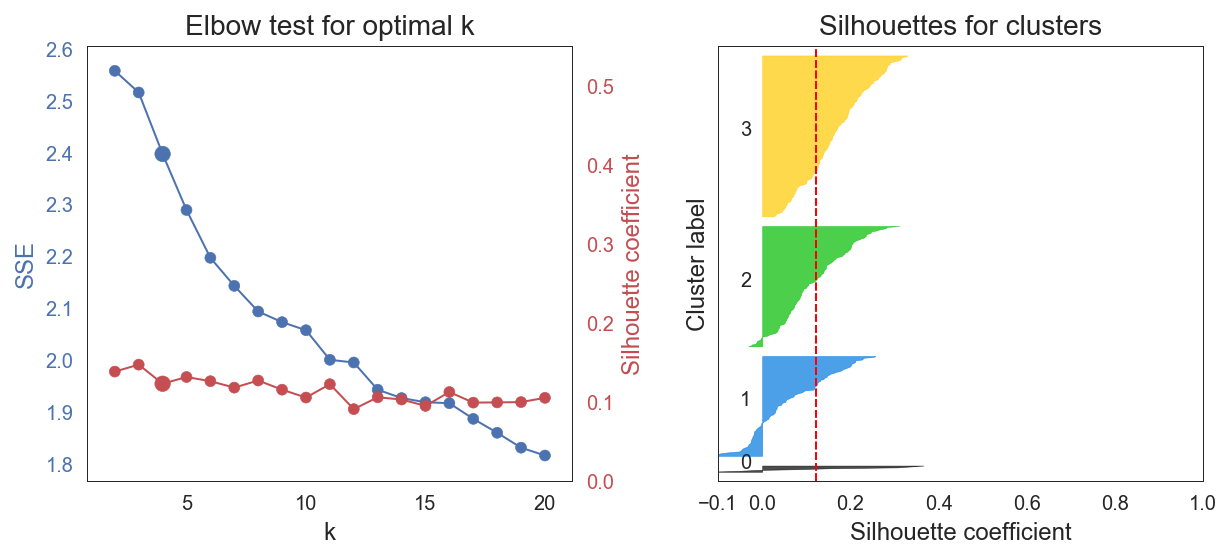

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.155989060806


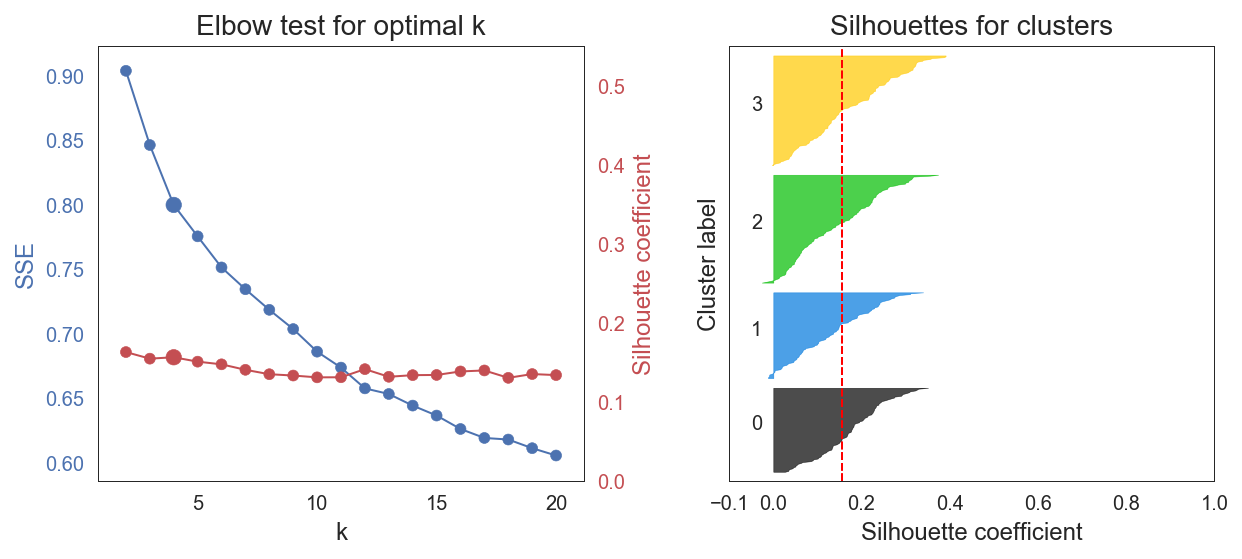

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.26183872  0.43961995]
With normalization
PCA explained ratio: [ 0.22859432  0.41504907]


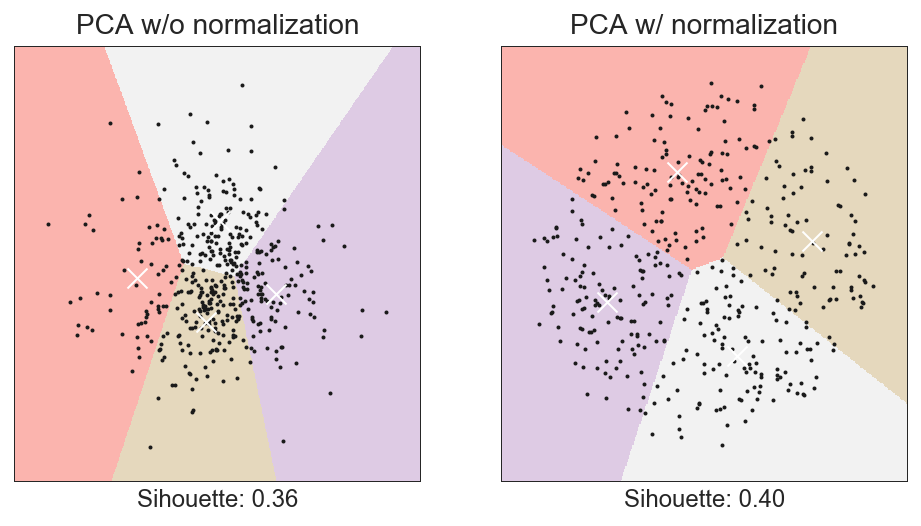

In [20]:
important_cols = [
    'review_count',
    'stars',
    'PriceRange',
    'Restaurants',
    'Shopping',
    'Food',
    'wday_hrs',
    'wend_hrs',
    'open_till_late',
]

_ = kmeans_and_pca(standardized(nbh_stats.loc[:, important_cols]), n_clusters=4)

#### Removing outliers

What if we remove those very large and dense neighborhoods, and clustering on the remaining "average" neighborhoods?

Original:
For n_clusters = 4 The average silhouette_score is : 0.437523156403


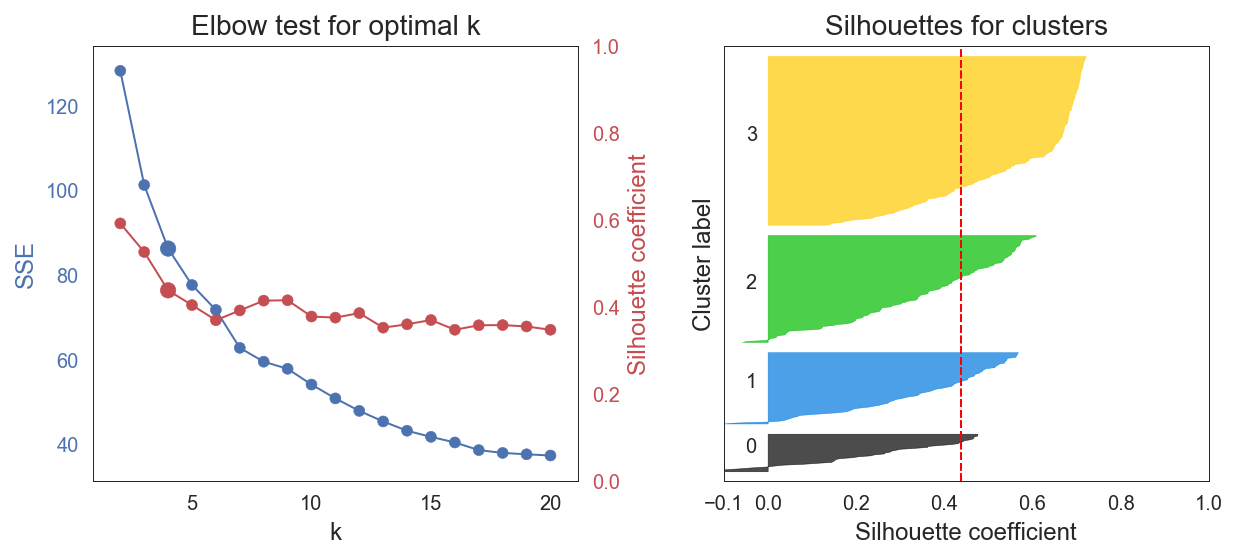

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.437868966259


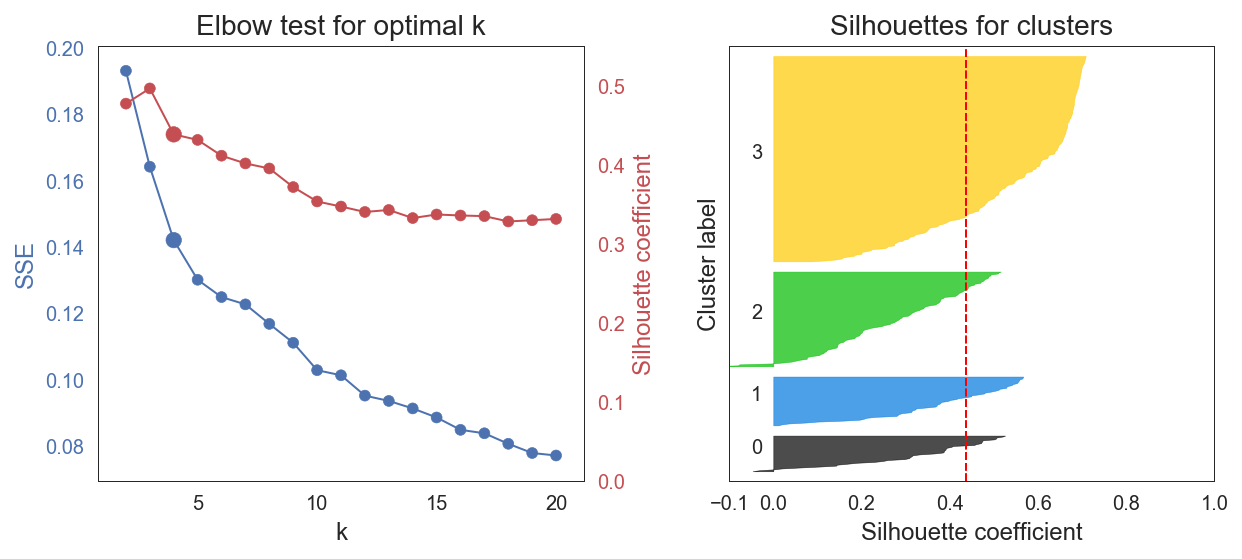

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.191829    0.30496194]
With normalization
PCA explained ratio: [ 0.45729364  0.53681435]


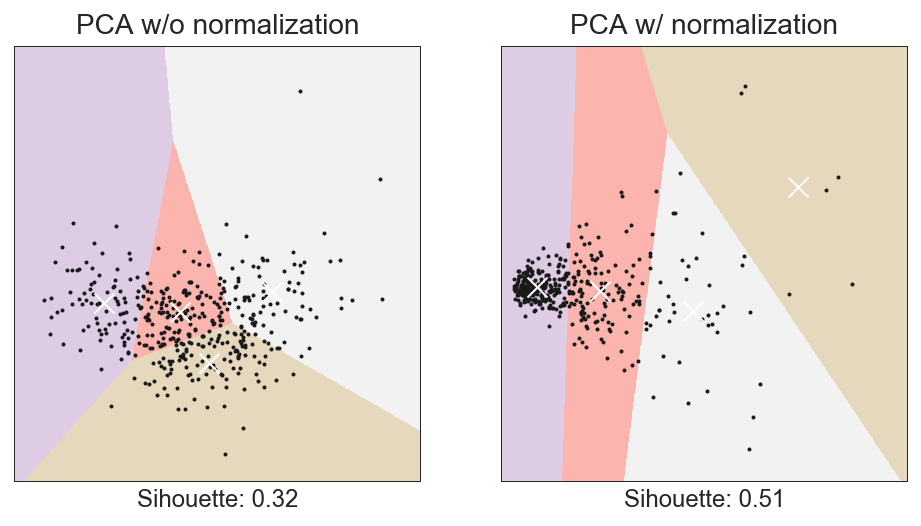

In [21]:
_ = kmeans_and_pca(nbh_stats[nbh_stats['n_biz'] < 500])

#### PCA?

How about apply PCA and reduced to higher dimensions (explain +90% variance)?

PCA explained ratio: [ 0.19548373  0.31157195  0.40220647  0.48105326  0.54235792  0.59746997
  0.64515352  0.68721726  0.7262369   0.75992777]
Original:
For n_clusters = 4 The average silhouette_score is : 0.130214429737


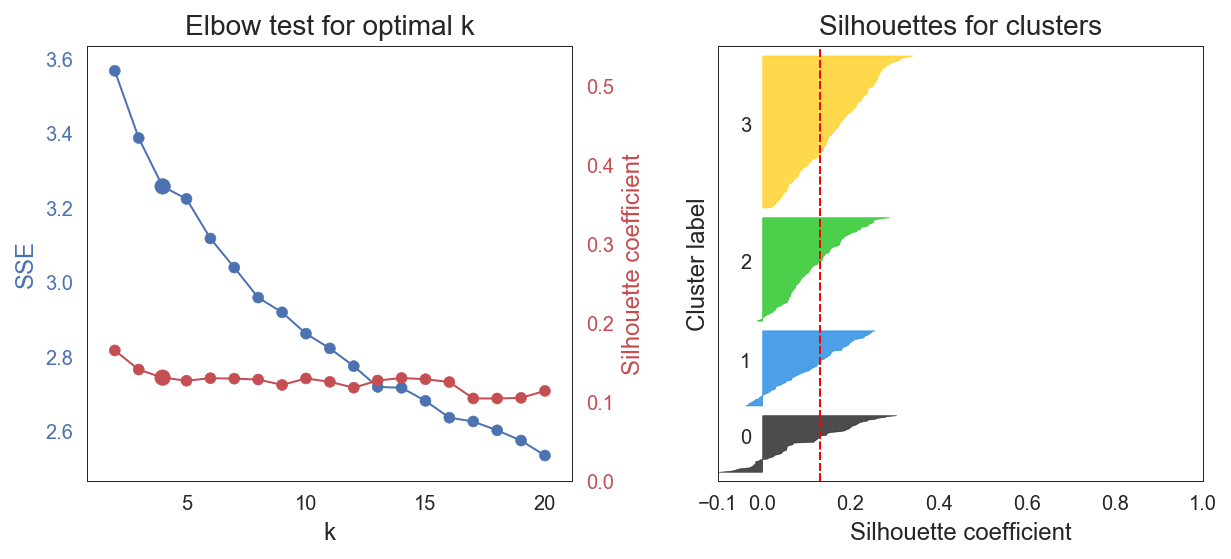

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.139965172168


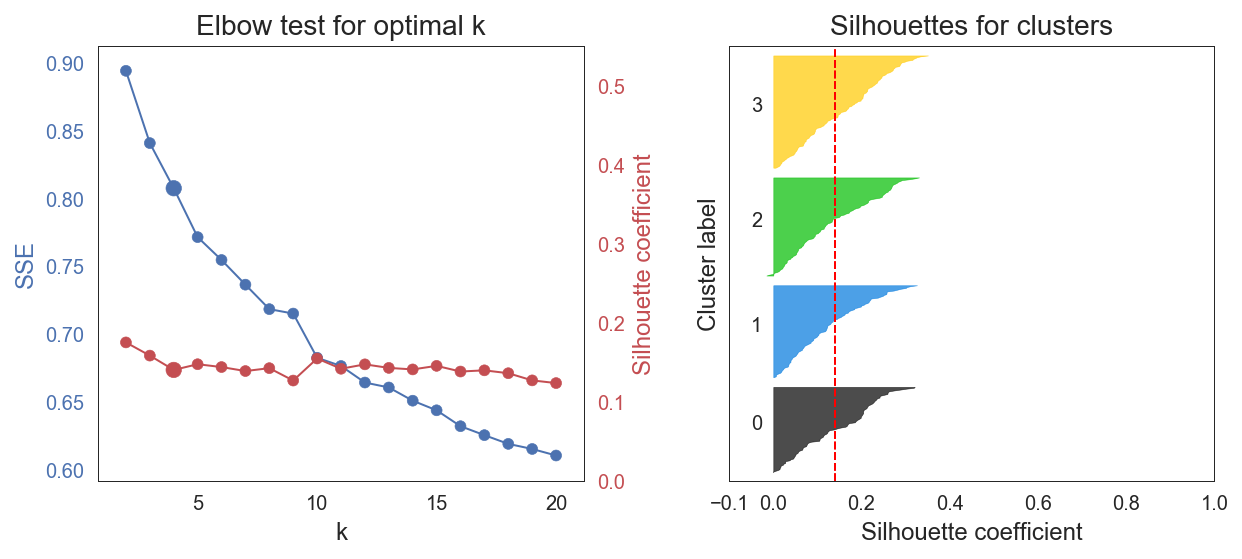

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.1  0.2]
With normalization
PCA explained ratio: [ 0.13150363  0.24939199]


n   pc1   pc2   pc3   pc4   pc5   pc6   pc7   pc8
1   65  3.17  1.36 -0.65  0.85 -0.45  0.16 -0.05  0.10
3   86 -2.32 -0.64  0.27  1.19 -0.45  0.34 -0.28 -0.04
0  118 -1.29  1.29 -0.06 -0.60  0.28 -0.33  0.40 -0.02
2  173  0.84 -1.07  0.15 -0.50  0.20 -0.01 -0.11 -0.00

n   pc9  pc10
1   65 -0.20  0.01
3   86  0.22 -0.13
0  118 -0.17 -0.02
2  173  0.08  0.07

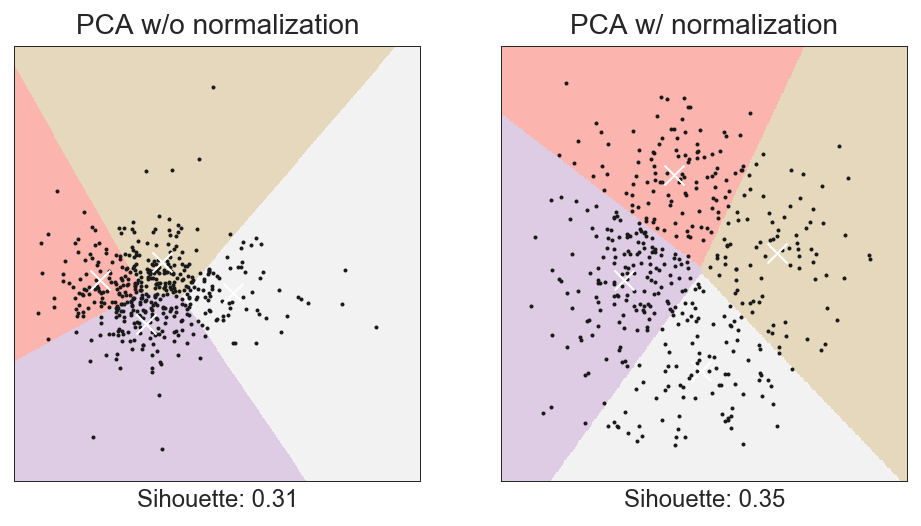

In [22]:
nbh_stats_reduced_dim = pca_reduced_data(nbh_stats, 10)
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(nbh_stats_reduced_dim)
split_print(fitted1)

### Weighted feature scaling

#### Assign weights

In [23]:
print({x: 1 for x in nbh_stats.columns})

{'n_biz': 1, 'n_biz_in_2km': 1, 'is_open': 1, 'stars': 1, 'review_count': 1, 'wday_hrs': 1, 'wend_hrs': 1, 'PriceRange': 1, 'open_till_late': 1, 'Restaurants': 1, 'Food': 1, 'Coffee/Tea': 1, 'Shopping': 1, 'Nightlife': 1, 'HomeServices': 1, 'LocalServices': 1, 'Beauty/Spas': 1, 'Health/Medical': 1, 'Automotive': 1, 'Arts/Ent.': 1, 'Hotels/Travel': 1, 'Alcohol': 1, 'DressFormal': 1, 'AcceptTakeOut': 1}


Original:
For n_clusters = 4 The average silhouette_score is : 0.39754985385


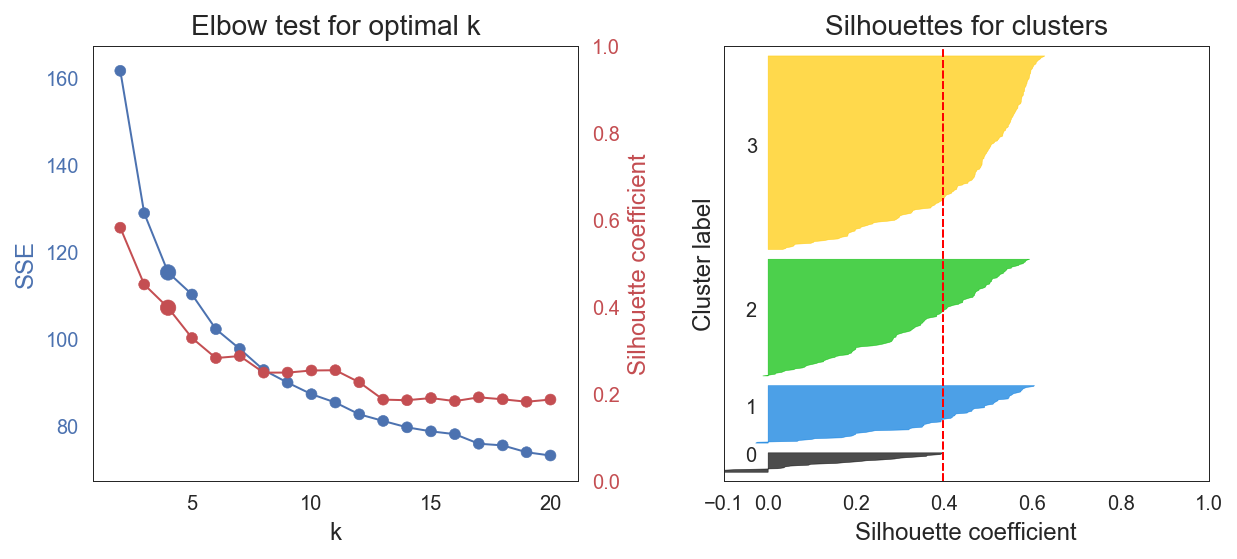

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.289004309331


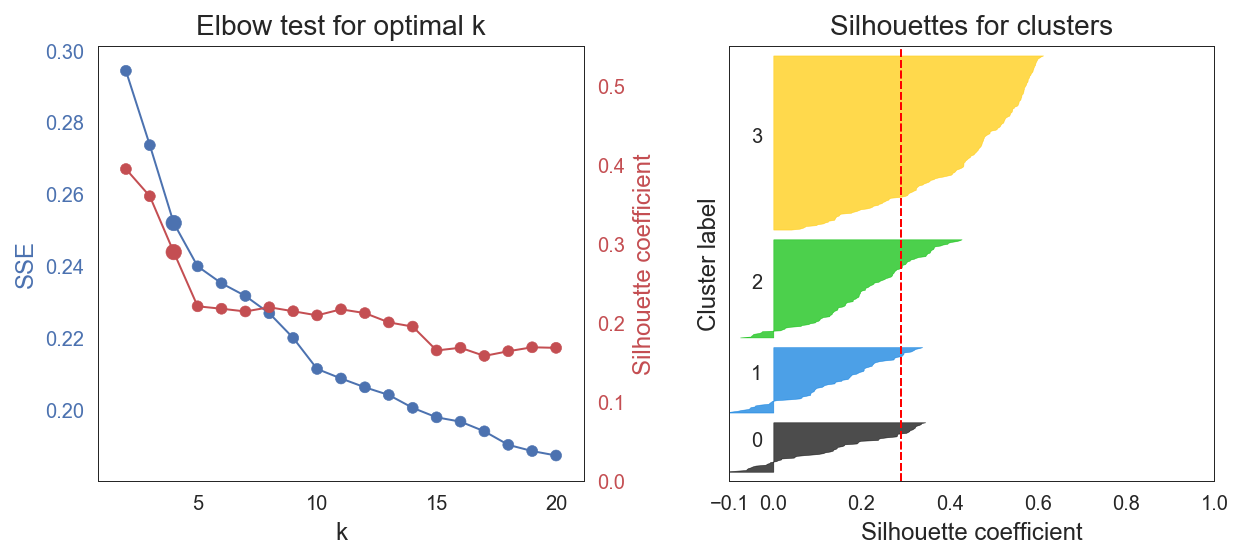

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.19548373  0.31157195]
With normalization
PCA explained ratio: [ 0.34317599  0.46107472]


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  wend_hrs  \
1   23   7.97       1103.08    81.37  73.67         45.29     52.48     41.37   
3   66   3.05        648.64    83.12  75.55         39.28     55.82     41.28   
2  133   1.52        357.73    84.32  75.31         29.90     56.11     39.38   
0  220   0.52        123.06    87.53  72.47         20.59     56.89     42.08   

   PriceRange  
1       91.17  
3       85.34  
2       85.01  
0       81.66

n  open_till_late   Rest   Food  Coffee/Tea  Shopping  Nightlife  \
1   23           28.09  33.89  15.84       36.68     12.15     163.52   
3   66           31.07  27.84  14.94       31.76     15.46      83.71   
2  133           30.95  23.66  12.59       25.72     16.50      47.99   
0  220           32.23  30.80  14.80       24.42     13.53      47.93   

   HomeServices  LocalServices  
1          7.04           6.51  
3         11.64           6.86  
2         10.72           8.00  
0         11.31           7.96

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
1   23         6.59          4.74        4.22      94.75           5.40   
3   66         9.44          7.76        7.78      47.80           2.72   
2  133        11.56         11.97        6.63      28.64           2.43   
0  220         8.99          7.69        8.00      20.51           2.89   

   Alcohol  DressFormal  AcceptTakeOut  
1    22.96        21.04          31.76  
3    14.47         6.09          29.14  
2    11.81         6.34          26.29  
0    11.75         2.61          33.16

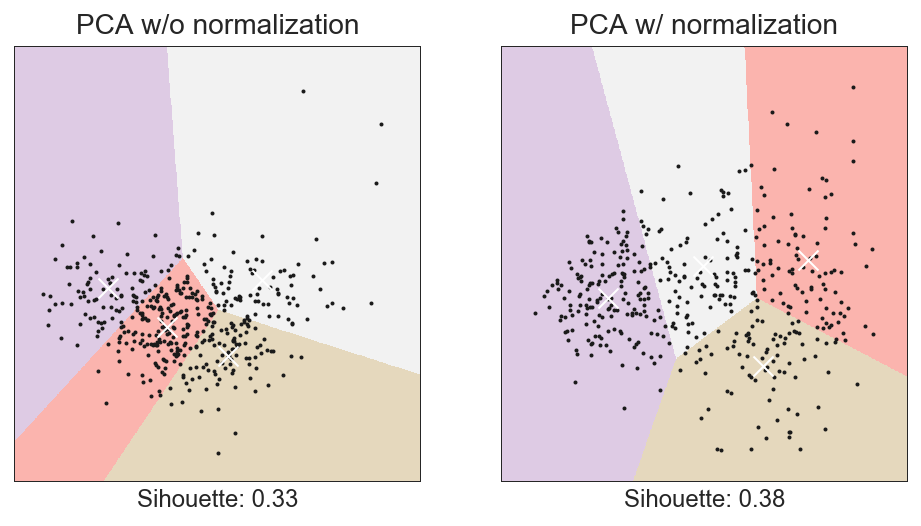

In [24]:
import math

minmax_weighted = lambda w: lambda x: minmax_scale(np.array(list(map(float, x))).T) * w
sqrt = lambda x: np.sqrt(x)
remove_mean_add_weight = lambda w: lambda x: x - np.mean(x) * w
log_and_scale = (lambda x: np.log(x) * 10, lambda x: np.exp(x/10))

WEIGHTS = {
    'n_biz': 0.01,
    'n_biz_in_2km': 1,
    
    'Coffee/Tea': 1000,
    'Nightlife': 1000,
    'DressFormal': 1000,
    'Arts/Ent.': 1000,
    'PriceRange': 50,
    
    'stars': 20,
    'review_count': 1,
    
    'wday_hrs': 7 / 5,
    'wend_hrs': 7 / 2,
    
    # proportions 0~100%
    'open_till_late': 100,
    'is_open': 100,
    'Restaurants': 100,
    'Food': 100,
    'Shopping': 100,
    
    'HomeServices': 100,
    'LocalServices': 100,
    'Beauty/Spas': 100,
    'Health/Medical': 100,
    'Automotive': 100,
    'Hotels/Travel': 100,
    'Alcohol': 100,
    'AcceptTakeOut': 100
}

def weighted_stats(data):
    data = data.copy()
    for k, val in WEIGHTS.items():
        if k not in data:
            continue
        # tuple means add weight and remove weith
        # i.e. to reverse the effect of the weight function
        if isinstance(val, tuple):
            val = val[0]
        if callable(val):
            ret = val(data[k])
            data[k] = ret
        else:
            data[k] = data[k] * val
    return data

nbh_stats_w = weighted_stats(nbh_stats)
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(nbh_stats_w)
fig1.savefig('../tex/nbh-kmeans-weighted.pdf', bbox_inches='tight')
split_print(fitted1)

In [25]:
split_print(fitted1, True)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &    n &  n\_biz &  n\_biz\_in\_2km &  is\_open &  stars &  review\_count &  wday\_hrs &  wend\_hrs &  PriceRange \\
\midrule
1 &   23 &   7.97 &       1103.08 &    81.37 &  73.67 &         45.29 &     52.48 &     41.37 &       91.17 \\
3 &   66 &   3.05 &        648.64 &    83.12 &  75.55 &         39.28 &     55.82 &     41.28 &       85.34 \\
2 &  133 &   1.52 &        357.73 &    84.32 &  75.31 &         29.90 &     56.11 &     39.38 &       85.01 \\
0 &  220 &   0.52 &        123.06 &    87.53 &  72.47 &         20.59 &     56.89 &     42.08 &       81.66 \\
\midrule
{} &    n &  open\_till\_late &   Rest &   Food &  Coffee/Tea &  Shopping &  Nightlife &  HomeServices &  LocalServices \\
\midrule
1 &   23 &           28.09 &  33.89 &  15.84 &       36.68 &     12.15 &     163.52 &          7.04 &           6.51 \\
3 &   66 &           31.07 &  27.84 &  14.94 &       31.76 &     15.46 &      83.71 &         11.64 &           6.86 \\
2 &  133 

<a name="nbh-gmm"></a>

### Gaussian Mixture Model

#### Determine the number of components

In [26]:
import matplotlib as mpl


cv_types = ["spherical", "tied", "diag", "full"]
n_components_range = range(2, 10)

def find_best_gmm(X, **gm_kw):
    lowest_bic = np.infty
    bic = []
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type=cv_type,
                **gm_kw)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    bic = np.array(bic)
    return best_gmm, bic

color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue",
                              "darkorange", "limegreen"])

def plot_bic(bic):
    # Plot the BIC scores to find no. of components
    bars = []
    fig, axis = plt.subplots()
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(axis.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                                      width=.2, color=color))
    axis.set_xticks(n_components_range)
    axis.set_ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    axis.set_title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + 1.5 + .2 * np.floor(bic.argmin() / len(n_components_range))
    axis.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    axis.set_xlabel('Number of components')
    axis.legend([b[0] for b in bars], cv_types, frameon=True, framealpha=0.9, facecolor='#ffffff')
    return fig

def fit_and_report_gmm(X, model, X_orig=None):
    model.fit(X)
    labels_km = model.predict(X)
    
    if X_orig is not None:
        labels = pd.DataFrame({'cluster': labels_km})
        labels.index = X_orig.index
        X_ref = pd.concat([labels, X_orig], axis=1)
        centroids = X_ref.groupby('cluster').mean()
    else:
        centroids = model.means_
    labels_count = pd.Series(labels_km).value_counts()
    centroids_df = pd.concat([pd.DataFrame(labels_count), pd.DataFrame(centroids)], axis=1)
    centroids_df.columns = ['n', *X.columns]
    centroids_df = round(centroids_df.sort_values("n"), 2)
    return centroids_df

def plot_gmm_2d(X, model, ax=None):
    """
    Plot the first two important components in GMM
    X: must be an nd array
    """
    columns = X.columns  # column names
    X = X.values
    Y_ = model.predict(X)
    is_spherical = model.covariance_type == 'spherical'
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'aspect': 'equal'})
        
    for i, (mean, cov, color) in enumerate(zip(model.means_, model.covariances_,
                                               color_iter)):
        if not np.any(Y_ == i):
            continue
        ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 5, color=color)

        if len(cov.shape) == 2 and cov.shape[0] == cov.shape[1]:
            v, w = linalg.eigh(cov)
            # Plot an ellipse to show the Gaussian component
            angle = np.arctan2(w[0][1], w[0][0])
            angle = 180. * angle / np.pi  # convert to degrees
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(.5)
            ax.add_artist(ell)
    ax.set_title('GMM components on the first 2 PCs')
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    return fig
        
def fit_gmm(X, force_k=None, **gm_kw):
    model, bic = find_best_gmm(X, **gm_kw)
    print(model)
    fig1 = plot_bic(bic)
    
    if force_k is not None:
        # ignore the best k automatically picked
        model = GaussianMixture(
            n_components=force_k,
            covariance_type=model.covariance_type,
            **gm_kw
        )
        
    fitted = fit_and_report_gmm(X, model)
    fitted = fitted.reset_index(drop=True)
    
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig2.subplots_adjust(wspace=0.3)
    
    plot_gmm_2d(X, model, ax=ax1)
    plot_silhouette(X, model, model.n_components, ax=ax2)
    return fig1, fig2, fitted, model

#### Raw data 

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=500,
        means_init=None, n_components=9, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 9 The average silhouette_score is : -0.0279380550471


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  wend_hrs  \
0  13  -0.06         -0.18     0.42  -0.24         -0.51     -0.04      0.04   
1  23   0.28          1.61    -0.60  -0.03          1.26     -0.67     -0.06   
2  34  -0.05          0.32    -0.29   0.15          0.37     -0.20      0.04   
3  42   1.86          0.81    -0.08   0.05          0.41      0.22      0.11   
4  46  -0.27         -0.80     0.33  -0.62         -0.51     -0.42     -0.07   
5  52  -0.27         -0.01     0.31  -0.12         -0.46      0.47      0.25   
6  74  -0.28         -0.33     0.49   0.30         -0.62     -0.12     -0.68   
7  78  -0.23          0.06    -0.54   0.11          0.58      0.11      0.42   
8  80  -0.21         -0.31    -0.04  -0.01         -0.07      0.11      0.02   

   PriceRange  
0       -0.01  
1        0.81  
2        0.79  
3        0.23  
4       -0.55  
5       -0.06  
6       -0.10  
7       -0.14  
8       -0.10

n  open_till_late  Rest  Food  Coffee/Tea  Shopping  Nightlife  \
0  13           -0.94 -0.56 -0.53       -0.69     -0.01      -0.23   
1  23            0.16  1.08  0.64        0.66     -0.33       2.02   
2  34            0.65  0.47  0.28        0.22      0.34       0.61   
3  42           -0.35 -0.48 -0.48       -0.30      0.16      -0.26   
4  46            0.01  0.86  0.50        0.42     -0.39      -0.21   
5  52           -0.16 -0.71 -0.24       -0.12      0.20      -0.13   
6  74           -0.68 -0.93 -0.57       -0.73     -0.20      -0.87   
7  78            0.57  0.74  0.48        0.53     -0.01       0.56   
8  80            0.19 -0.07 -0.04       -0.03      0.16      -0.23   

   HomeServices  LocalServices  
0          0.81           0.73  
1         -0.72          -0.84  
2         -0.47          -0.32  
3          0.19           0.05  
4         -0.38          -0.41  
5          0.50           0.36  
6          0.84           0.49  
7         -0.56          -0.28  
8         -0.16           0.06

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
0  13        -0.43         -0.41        0.73       0.20           0.58   
1  23        -0.70         -0.52       -0.60       1.97           0.47   
2  34         0.23         -0.09       -0.54       0.27          -0.30   
3  42         0.24          0.40       -0.03      -0.07          -0.03   
4  46        -0.32         -0.78        0.29      -0.54           0.45   
5  52        -0.44         -0.41        0.99       0.35           0.82   
6  74         0.09          0.80        0.07      -0.36          -0.39   
7  78        -0.19         -0.27       -0.20       0.13          -0.08   
8  80         0.64          0.29       -0.39      -0.41          -0.45   

   Alcohol  DressFormal  AcceptTakeOut  
0    -0.44         0.50          -0.95  
1     1.88         1.93           0.63  
2     0.76         0.97           0.36  
3    -0.34        -0.10          -0.62  
4    -0.22        -0.24           0.86  
5    -0.46        -0.24          -0.72  
6    -0.76        -0.24          -0.68  
7     0.71        -0.24           0.84  
8    -0.21        -0.24          -0.07

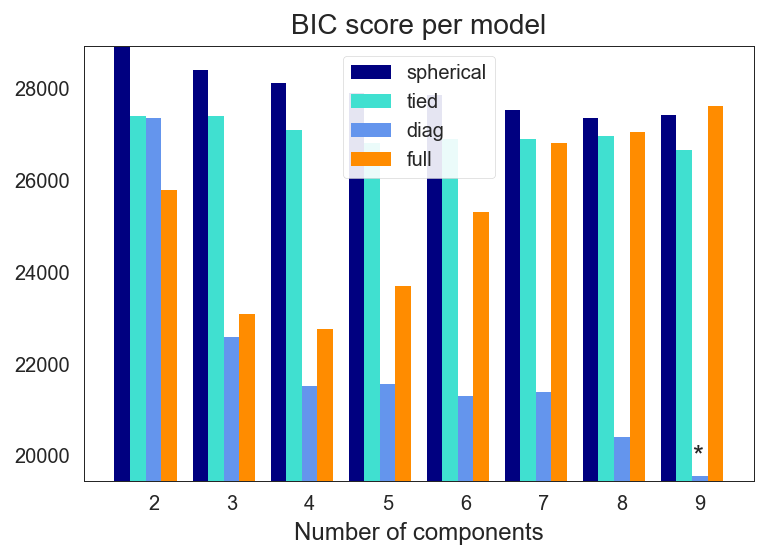

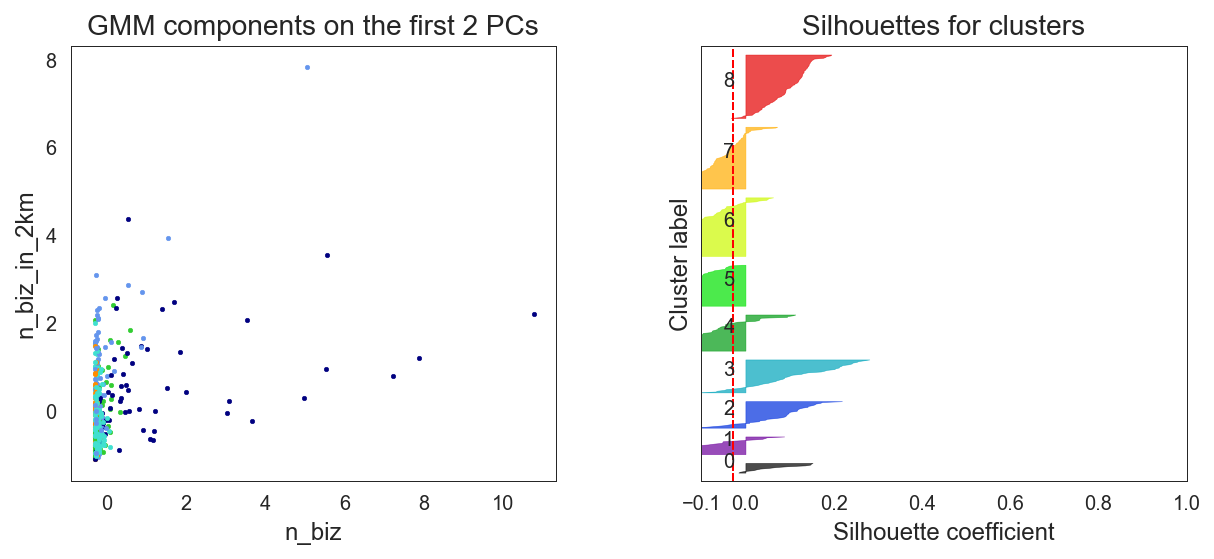

In [27]:
X = standardized(nbh_stats)
fig1, fig2, fitted, model = fit_gmm(X, max_iter=500)
split_print(fitted)

This looks really bad. Maybe remove business count?

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=500,
        means_init=None, n_components=9, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 9 The average silhouette_score is : -0.0895586772192


n  is_open  stars  wday_hrs  wend_hrs  PriceRange  open_till_late  Rest  \
0   21     0.68   0.62      0.47      0.48        0.30            0.33  0.25   
1   25     0.81   0.70      0.50      0.47        0.28            0.22  0.11   
2   28     0.79   0.71      0.43      0.24        0.32            0.22  0.08   
3   36     0.66   0.62      0.50      0.47        0.29            0.32  0.26   
4   37     0.55   0.62      0.37      0.44        0.35            0.43  0.53   
5   39     0.63   0.59      0.49      0.48        0.36            0.48  0.35   
6   53     0.62   0.57      0.46      0.49        0.25            0.40  0.46   
7   71     0.74   0.53      0.48      0.45        0.23            0.35  0.30   
8  132     0.63   0.62      0.47      0.46        0.26            0.45  0.40   

   Food  
0  0.26  
1  0.17  
2  0.10  
3  0.19  
4  0.36  
5  0.26  
6  0.35  
7  0.20  
8  0.31

n  Coffee/Tea  Shopping  Nightlife  HomeServices  LocalServices  \
0   21        0.18      0.46       0.15          0.18           0.22   
1   25        0.10      0.19       0.02          0.48           0.35   
2   28        0.03      0.18       0.00          0.19           0.14   
3   36        0.10      0.34       0.06          0.18           0.19   
4   37        0.30      0.26       0.30          0.05           0.08   
5   39        0.14      0.43       0.11          0.10           0.13   
6   53        0.34      0.25       0.13          0.08           0.12   
7   71        0.00      0.35       0.03          0.18           0.22   
8  132        0.19      0.35       0.09          0.09           0.17   

   Beauty/Spas  Health/Medic  Automotive  
0         0.13          0.03        0.16  
1         0.11          0.06        0.16  
2         0.25          0.52        0.10  
3         0.21          0.17        0.12  
4         0.10          0.04        0.04  
5         0.22          0.15        0.06  
6         0.10          0.04        0.14  
7         0.10          0.06        0.27  
8         0.22          0.11        0.07

n  Arts/Ent.  Hotels/Travel  Alcohol  DressFormal  AcceptTakeOut
0   21       0.25           0.15     0.19         0.03           0.26
1   25       0.11           0.05     0.08         0.00           0.19
2   28       0.03           0.02     0.08         0.00           0.19
3   36       0.06           0.05     0.13         0.01           0.30
4   37       0.29           0.09     0.45         0.11           0.53
5   39       0.08           0.05     0.25         0.03           0.41
6   53       0.08           0.16     0.23         0.00           0.54
7   71       0.03           0.14     0.10         0.00           0.38
8  132       0.06           0.00     0.20         0.00           0.47

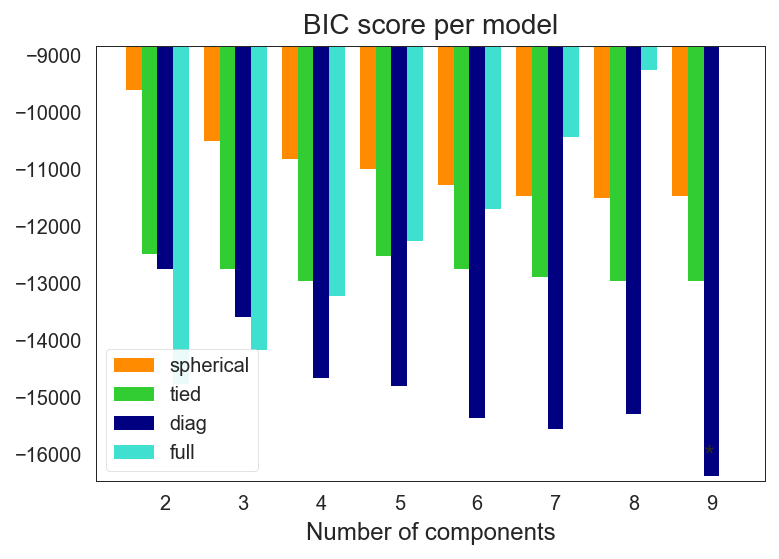

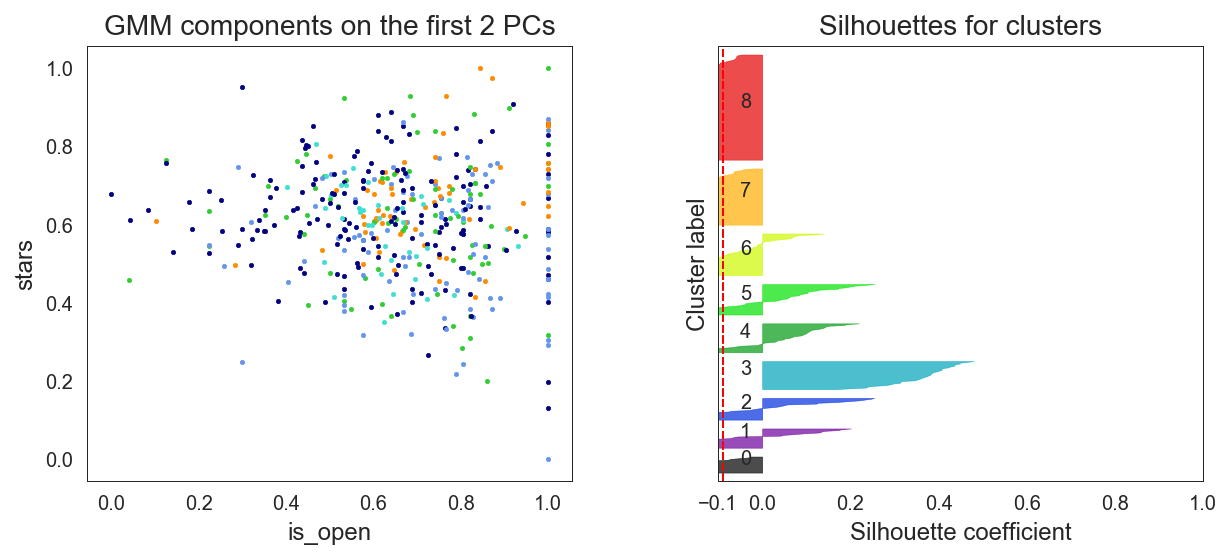

In [28]:
X = minmax_scaled(nbh_stats_wo_biz_count)
fig1, fig2, fitted, model = fit_gmm(X, max_iter=500)
split_print(fitted)

Still quite random.

#### Normalization

Maybe normalization would help?

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=200,
        means_init=None, n_components=8, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-10, tol=0.0001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 8 The average silhouette_score is : 0.0447180740356


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  wend_hrs  \
0   36   0.41          0.18    -0.03  -0.05          0.12      0.05      0.06   
1   38   0.02          0.22    -0.12   0.03          0.16     -0.12      0.00   
..  ..    ...           ...      ...    ...           ...       ...       ...   
6   72  -0.07         -0.10     0.02  -0.00         -0.05     -0.04     -0.07   
7   84  -0.06         -0.00    -0.13   0.04          0.09      0.04      0.09   

    PriceRange  open_till_late  Restaurants  Food  Coffee/Tea  Shopping  \
0         0.01           -0.09        -0.11 -0.14       -0.09      0.11   
1         0.06            0.05         0.19  0.16        0.15     -0.04   
..         ...             ...          ...   ...         ...       ...   
6        -0.05           -0.05        -0.09 -0.02       -0.05      0.05   
7        -0.00            0.18         0.16  0.10        0.10      0.05   

    Nightlife  HomeServices  LocalServices  Beauty/Spas  Health/Medical  \
0       -0.05          0.05           0.04         0.01            0.01   
1        0.31         -0.13          -0.12        -0.10           -0.11   
..        ...           ...            ...          ...             ...   
6       -0.14         -0.00           0.05         0.14            0.08   
7        0.08         -0.14          -0.05         0.05           -0.05   

    Automotive  Arts/Ent.  Hotels/Travel  Alcohol  DressFormal  AcceptTakeOut  
0         0.07       0.02          -0.00    -0.09        -0.03          -0.16  
1        -0.10       0.28           0.03     0.27         0.17           0.14  
..         ...        ...            ...      ...          ...            ...  
6        -0.07      -0.12          -0.14    -0.13        -0.07          -0.07  
7        -0.09      -0.03          -0.09     0.16        -0.06           0.18  

[8 rows x 25 columns]

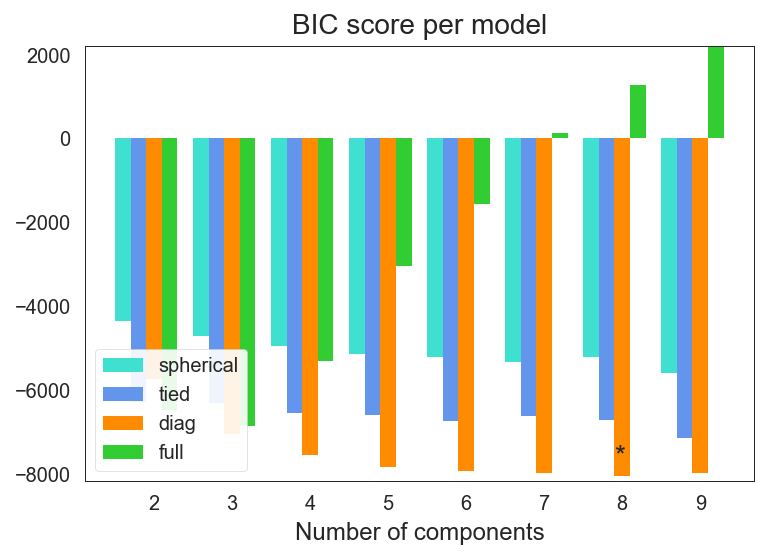

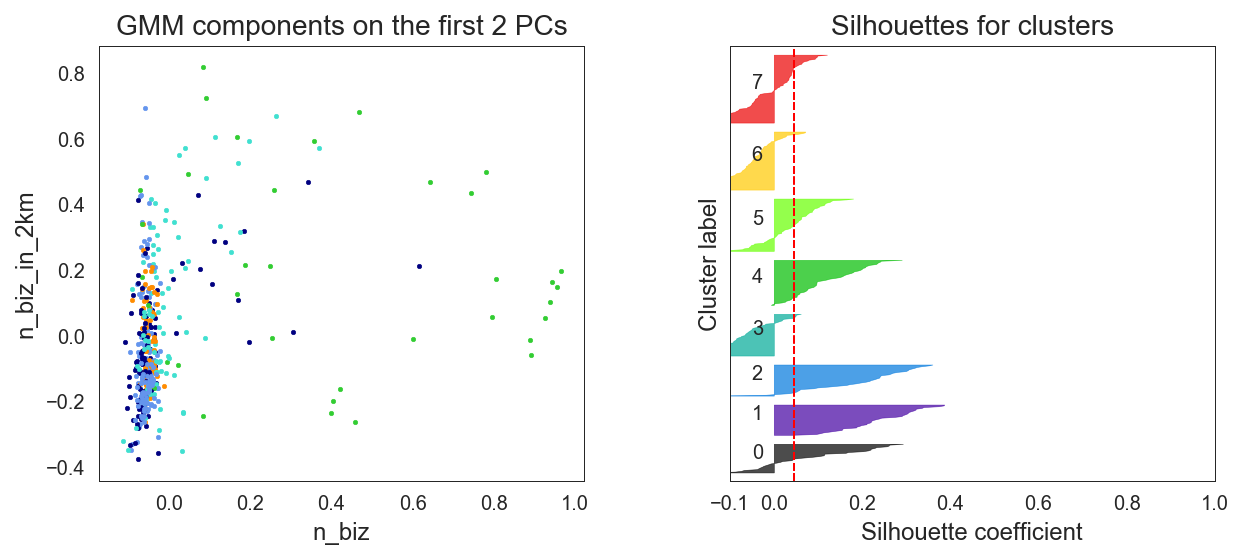

In [29]:
X = normalized(standardized(nbh_stats))
fig1, fig2, fitted, model = fit_gmm(X, reg_covar=1e-10, tol=1e-4, max_iter=200)
display(fitted)

#### PCA reduced - 16D

PCA explained ratio: [ 0.19548373  0.31157195  0.40220647  0.48105326  0.54235792  0.59746997
  0.64515352  0.68721726  0.7262369   0.75992777  0.7923103   0.82227794
  0.8485819   0.87126405  0.89330693  0.91405017]
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-10, tol=0.0001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 4 The average silhouette_score is : 0.0605041182029


n   pc1   pc2   pc3   pc4   pc5   pc6   pc7   pc8   pc9  pc10  pc11  \
0    6  5.43  5.14 -0.76  3.29  1.80  1.80 -0.48 -0.30  0.34  0.21  0.23   
1   68 -0.39  0.20  0.82  1.03  0.54 -0.75  0.80  0.30  0.23 -0.15 -0.10   
2  167  1.48 -0.06 -0.43 -0.17 -0.38  0.00 -0.14  0.02  0.00  0.01 -0.02   
3  201 -1.30 -0.18  0.11 -0.30  0.09  0.20 -0.14 -0.11 -0.09  0.03  0.05   

   pc12  pc13  pc14  pc15  pc16  
0  0.29 -0.43 -0.53  0.36 -0.44  
1  0.04 -0.00 -0.06 -0.02  0.24  
2 -0.00 -0.01  0.08  0.02 -0.08  
3 -0.02  0.02 -0.04 -0.02  0.00

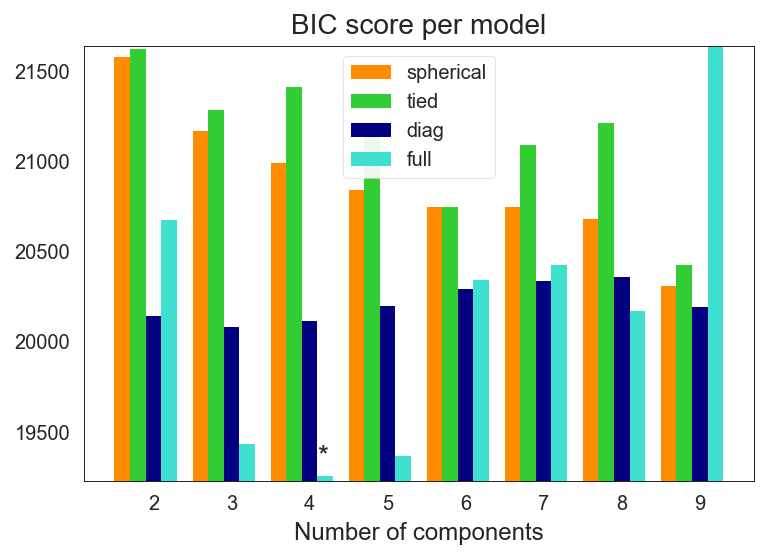

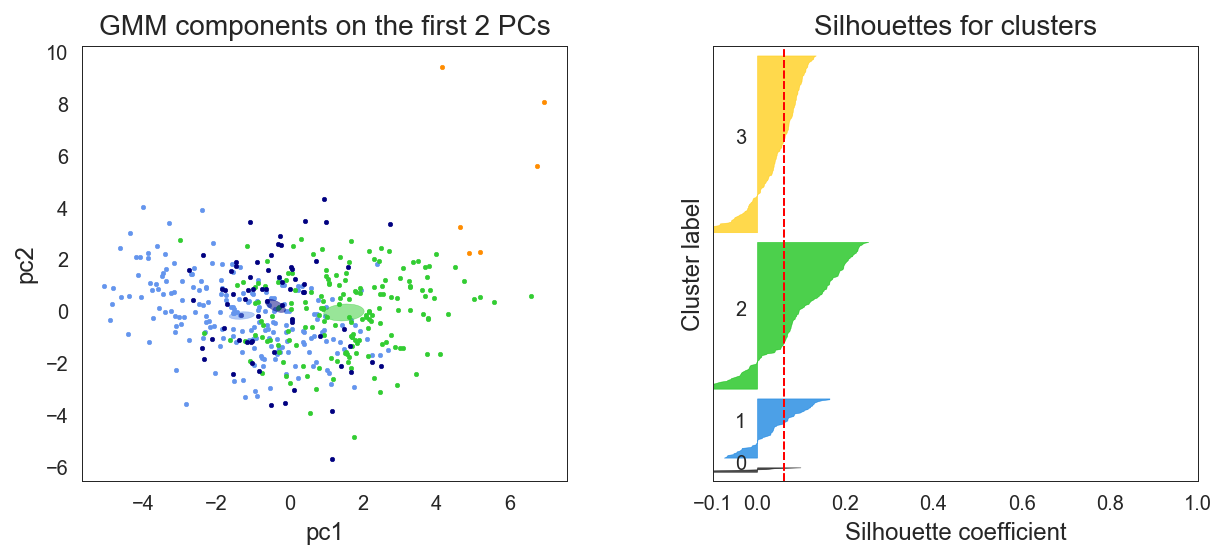

In [30]:
X = pca_reduced_data(nbh_stats, 16)
fig1, fig2, fitted, model = fit_gmm(X, reg_covar=1e-10, tol=1e-4, max_iter=200)

fig1.savefig('../tex/nbh-gmm-bic.pdf', bbox_inches='tight')
fig2.savefig('../tex/nbh-gmm.pdf', bbox_inches='tight')

display(fitted)

#### Normalized and Standardized?

PCA explained ratio: [ 0.18650188  0.30506163  0.39442789  0.47577597  0.53424447  0.58849878
  0.6378629   0.68039328  0.71668607  0.75089948  0.78090241  0.80930324
  0.83742023  0.86306249  0.88613871  0.90754281]
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-10, tol=0.0001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 3 The average silhouette_score is : 0.0617371928566


n   pc1   pc2   pc3   pc4   pc5   pc6   pc7   pc8   pc9  pc10  pc11  \
0   75 -2.11  1.06  0.24  0.26 -0.38 -0.10 -0.88  0.36  0.14 -0.26 -0.17   
1   90  2.13  1.28 -0.45  0.30 -0.12  0.43  0.27 -0.09  0.20 -0.41  0.06   
2  277 -0.12 -0.71  0.08 -0.17  0.14 -0.11  0.15 -0.07 -0.11  0.20  0.03   

   pc12  pc13  pc14  pc15  pc16  
0 -0.08 -0.44  0.11 -0.14 -0.04  
1  0.07  0.39  0.07 -0.01  0.13  
2 -0.00 -0.01 -0.05  0.04 -0.03

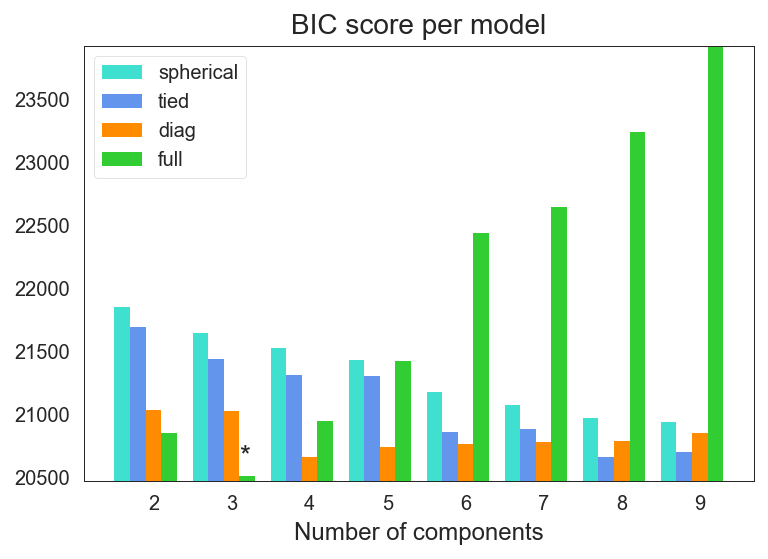

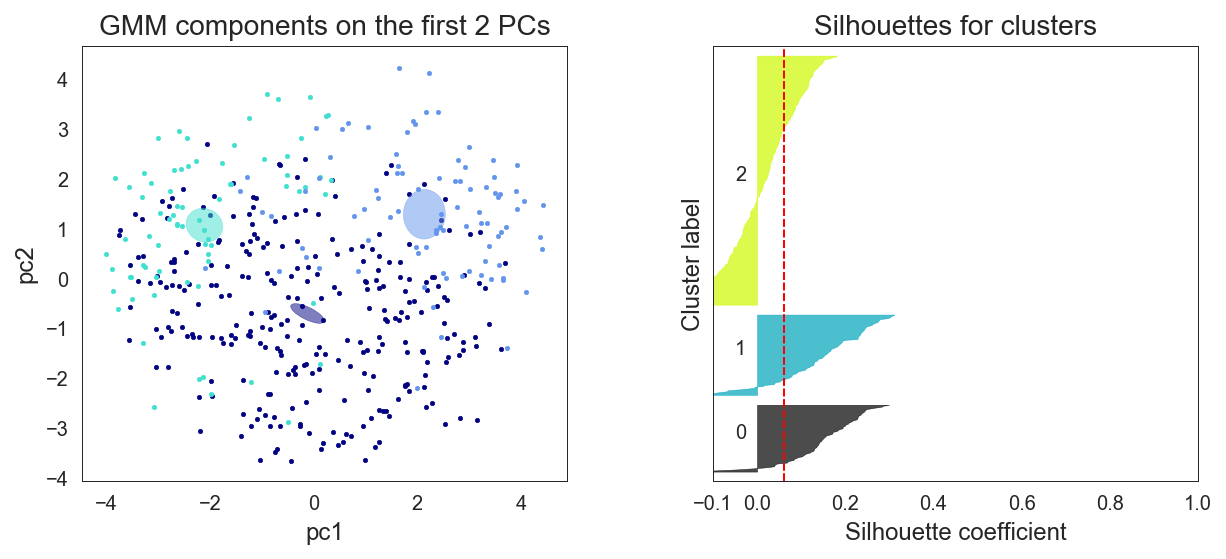

In [31]:
X = pca_reduced_data(normalized(standardized(nbh_stats)), 16)
fig1, fig2, fitted, model = fit_gmm(X, reg_covar=1e-10, tol=1e-4, max_iter=200)
display(fitted)

#### Weighted feature scaling (GMM)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=200,
        means_init=None, n_components=9, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-10, tol=0.0001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 9 The average silhouette_score is : -0.201767130677


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  \
0     1  26.43       2522.92    79.27  71.42        177.99     57.69   
1     6   2.06        345.00    87.91  72.78         31.67     48.74   
..  ...    ...           ...      ...    ...           ...       ...   
7   133   0.22        219.11    90.67  73.00         14.70     56.18   
8   134   0.40        289.45    82.03  74.29         32.19     56.97   

    wend_hrs  PriceRange  open_till_late  Restaurants   Food  Coffee/Tea  \
0      57.83      117.11           36.44        32.27  14.15       45.02   
1      30.65      107.23           24.30        21.87   8.59        7.32   
..       ...         ...             ...          ...    ...         ...   
7      37.50       80.69           24.77        19.33  11.86       16.35   
8      44.64       81.83           38.86        38.12  17.80       39.48   

    Shopping  Nightlife  HomeServices  LocalServices  Beauty/Spas  \
0      23.76     211.88          0.61           1.32         7.23   
1      16.06      34.79         13.80           7.54         8.38   
..       ...        ...           ...            ...          ...   
7      12.68      16.05         17.77           9.40         8.27   
8      15.41      82.30          5.18           6.12         9.60   

    Health/Medical  Automotive  Arts/Ent.  Hotels/Travel  Alcohol  \
0             0.98        0.45     179.34           8.25    33.26   
1            18.98        5.83       8.48           1.65    12.68   
..             ...         ...        ...            ...      ...   
7            12.21       10.69      19.31           4.05     5.53   
8             5.13        5.46      35.17           1.87    17.82   

    DressFormal  AcceptTakeOut  
0         48.43          27.13  
1         74.95          16.68  
..          ...            ...  
7          0.00          24.49  
8          0.00          39.98  

[9 rows x 25 columns]

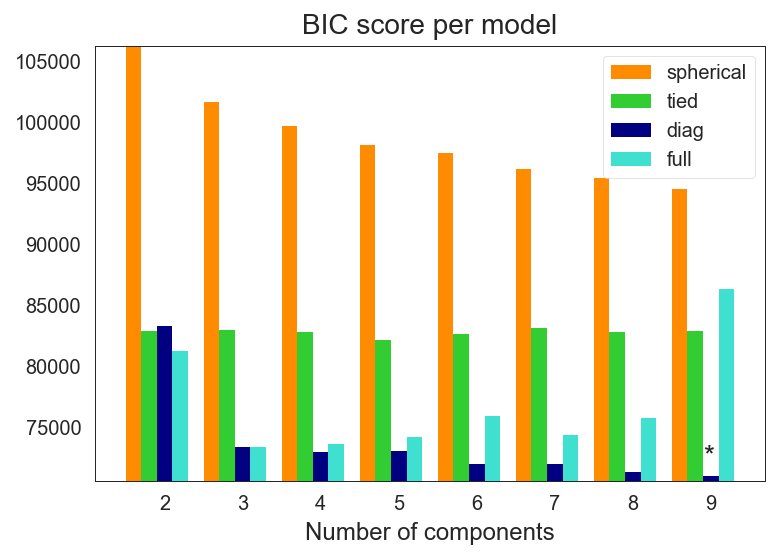

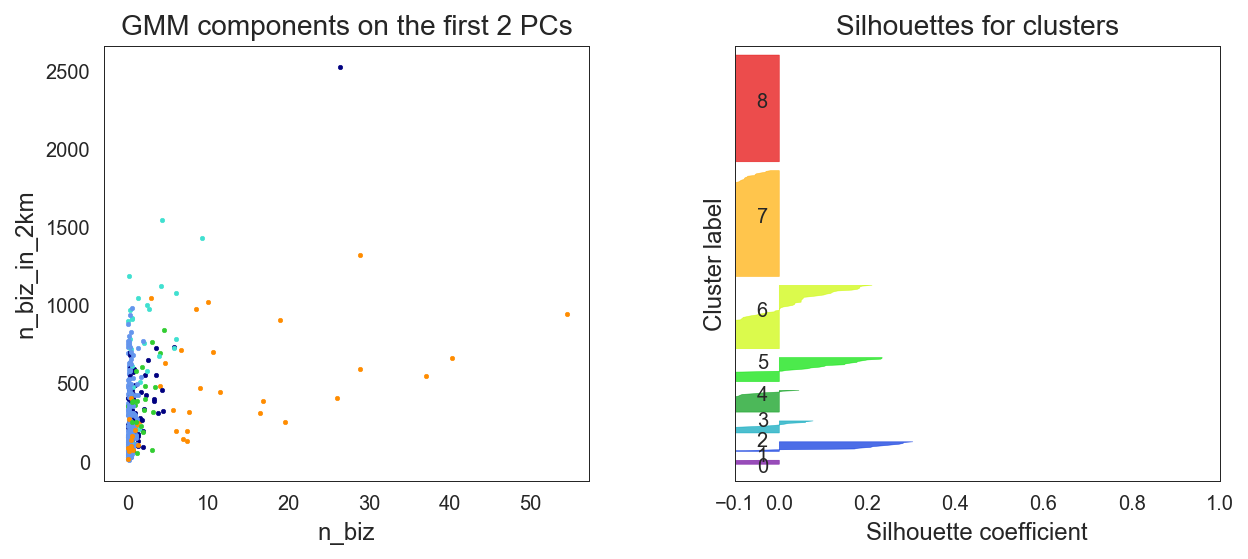

In [32]:
fig1, fig2, fitted, model = fit_gmm(nbh_stats_w, reg_covar=1e-10, tol=1e-4, max_iter=200)
display(fitted)

## Cluster by census tracts

<a name="ct-main"></a>

We run similar clustering algorithms at the census tract level.

In [33]:
ct_stats = load_stats('../data/step2/ct_stats_min_10.csv')
ct_stats_min_20 = load_stats('../data/step2/ct_stats_min_20.csv')

../data/step2/ct_stats_min_10.csv


n_biz  n_biz_in_2km   is_open     stars  review_count   wday_hrs  \
CT_ID                                                                           
32003006700   1767   2742.401245  0.802490  3.594793    203.042445  43.269053   
32003002302    602   2404.418605  0.790698  3.665282    101.425249  37.732558   
...            ...           ...       ...       ...           ...        ...   
04013010102     29      1.758621  0.965517  4.224138     20.620690  20.086207   
04013040517     16      0.000000  0.875000  4.062500      4.875000  42.625000   

              wend_hrs  PriceRange  open_till_late  Restaurants      Food  \
CT_ID                                                                       
32003006700  17.418487    2.371550        0.353707     0.331070  0.150538   
32003002302  14.210548    2.299550        0.390365     0.255814  0.101329   
...                ...         ...             ...          ...       ...   
04013010102   6.551724    2.000000        0.068966     0.206897  0.034483   
04013040517  10.250000    1.666667        0.250000     0.062500  0.062500   

             Coffee/Tea  Shopping  Nightlife  HomeServices  LocalServices  \
CT_ID                                                                       
32003006700     0.04867  0.237125   0.228636      0.007357       0.011885   
32003002302     0.02990  0.305648   0.132890      0.009967       0.026578   
...                 ...       ...        ...           ...            ...   
04013010102     0.00000  0.000000   0.034483      0.137931       0.000000   
04013040517     0.00000  0.062500   0.000000      0.562500       0.187500   

             Beauty/Spas  Health/Medical  Automotive  Arts/Ent.  \
CT_ID                                                             
32003006700     0.063384        0.007357    0.003396   0.175439   
32003002302     0.109635        0.024917    0.011628   0.137874   
...                  ...             ...         ...        ...   
04013010102     0.034483        0.000000    0.034483   0.000000   
04013040517     0.000000        0.000000    0.062500   0.000000   

             Hotels/Travel   Alcohol  DressFormal  AcceptTakeOut  
CT_ID                                                             
32003006700       0.074137  0.353707     0.052632       0.292586  
32003002302       0.093023  0.200997     0.031561       0.196013  
...                    ...       ...          ...            ...  
04013010102       0.172414  0.068966     0.000000       0.103448  
04013040517       0.062500  0.062500     0.000000       0.000000  

[1987 rows x 24 columns]

n_biz  n_biz_in_2km      is_open        stars  review_count  \
count  1987.000000   1987.000000  1987.000000  1987.000000   1987.000000   
mean     56.095118    273.588037     0.866948     3.653962     24.374807   
std      82.070804    287.740041     0.079869     0.312622     17.553983   
min      10.000000      0.000000     0.540541     2.166667      4.133333   
25%      19.000000     85.199020     0.818182     3.456709     13.112500   
50%      34.000000    180.538462     0.874552     3.670139     19.341463   
75%      63.000000    363.030735     0.923077     3.861111     30.444444   
max    1767.000000   2742.401245     1.000000     4.750000    203.042445   

          wday_hrs     wend_hrs   PriceRange  open_till_late  Restaurants  \
count  1987.000000  1987.000000  1987.000000     1987.000000  1987.000000   
mean     40.368418    12.039827     1.671725        0.309400     0.286507   
std       7.099435     3.110406     0.249077        0.135124     0.151100   
min      10.600000     0.000000     1.000000        0.000000     0.000000   
25%      36.167793    10.061905     1.509447        0.214286     0.181818   
50%      40.653846    11.923469     1.666667        0.302326     0.272727   
75%      44.810907    13.931187     1.810102        0.400000     0.379796   
max      65.409091    25.050000     3.400000        0.733333     0.900000   

              Food   Coffee/Tea     Shopping    Nightlife  HomeServices  \
count  1987.000000  1987.000000  1987.000000  1987.000000   1987.000000   
mean      0.130843     0.022694     0.143169     0.059468      0.111136   
std       0.078510     0.030837     0.091597     0.065736      0.099722   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       0.080000     0.000000     0.080863     0.000000      0.042553   
50%       0.120000     0.011527     0.133333     0.043478      0.088889   
75%       0.176471     0.035714     0.190476     0.086957      0.157895   
max       0.545455     0.300000     0.661616     0.605263      0.687500   

       LocalServices  Beauty/Spas  Health/Medical   Automotive    Arts/Ent.  \
count    1987.000000  1987.000000     1987.000000  1987.000000  1987.000000   
mean        0.072580     0.097803        0.083134     0.084781     0.025772   
std         0.060730     0.073580        0.100939     0.093671     0.040172   
min         0.000000     0.000000        0.000000     0.000000     0.000000   
25%         0.030303     0.047619        0.000000     0.021165     0.000000   
50%         0.065421     0.090909        0.057143     0.058824     0.008646   
75%         0.100000     0.138614        0.110501     0.117647     0.037500   
max         0.384615     0.735294        0.818182     0.800000     0.342105   

       Hotels/Travel      Alcohol  DressFormal  AcceptTakeOut  
count    1987.000000  1987.000000  1987.000000    1987.000000  
mean        0.029299     0.125218     0.004339       0.298283  
std         0.051425     0.096900     0.017034       0.142992  
min         0.000000     0.000000     0.000000       0.000000  
25%         0.000000     0.060606     0.000000       0.195122  
50%         0.000000     0.104167     0.000000       0.285714  
75%         0.041381     0.172414     0.000000       0.391304  
max         0.500000     0.657895     0.363636       0.846154

../data/step2/ct_stats_min_20.csv


n_biz  n_biz_in_2km   is_open     stars  review_count   wday_hrs  \
CT_ID                                                                           
32003006700   1767   2742.401245  0.802490  3.594793    203.042445  43.269053   
32003002302    602   2404.418605  0.790698  3.665282    101.425249  37.732558   
...            ...           ...       ...       ...           ...        ...   
32003007500     60      2.766667  0.933333  4.075000     28.983333  36.050000   
04013010102     29      1.758621  0.965517  4.224138     20.620690  20.086207   

              wend_hrs  PriceRange  open_till_late  Restaurants      Food  \
CT_ID                                                                       
32003006700  17.418487    2.371550        0.353707     0.331070  0.150538   
32003002302  14.210548    2.299550        0.390365     0.255814  0.101329   
...                ...         ...             ...          ...       ...   
32003007500  13.783333    1.923077        0.166667     0.166667  0.050000   
04013010102   6.551724    2.000000        0.068966     0.206897  0.034483   

             Coffee/Tea  Shopping  Nightlife  HomeServices  LocalServices  \
CT_ID                                                                       
32003006700     0.04867  0.237125   0.228636      0.007357       0.011885   
32003002302     0.02990  0.305648   0.132890      0.009967       0.026578   
...                 ...       ...        ...           ...            ...   
32003007500     0.00000  0.033333   0.050000      0.066667       0.033333   
04013010102     0.00000  0.000000   0.034483      0.137931       0.000000   

             Beauty/Spas  Health/Medical  Automotive  Arts/Ent.  \
CT_ID                                                             
32003006700     0.063384        0.007357    0.003396   0.175439   
32003002302     0.109635        0.024917    0.011628   0.137874   
...                  ...             ...         ...        ...   
32003007500     0.000000        0.016667    0.000000   0.066667   
04013010102     0.034483        0.000000    0.034483   0.000000   

             Hotels/Travel   Alcohol  DressFormal  AcceptTakeOut  
CT_ID                                                             
32003006700       0.074137  0.353707     0.052632       0.292586  
32003002302       0.093023  0.200997     0.031561       0.196013  
...                    ...       ...          ...            ...  
32003007500       0.183333  0.116667     0.000000       0.116667  
04013010102       0.172414  0.068966     0.000000       0.103448  

[1454 rows x 24 columns]

n_biz  n_biz_in_2km      is_open        stars  review_count  \
count  1454.000000   1454.000000  1454.000000  1454.000000   1454.000000   
mean     71.456671    320.010978     0.858827     3.656206     27.103448   
std      91.230544    308.384366     0.071989     0.286109     18.112376   
min      20.000000      1.758621     0.540541     2.634615      5.360000   
25%      30.000000    113.547619     0.812500     3.471749     15.029199   
50%      46.000000    224.369048     0.865385     3.673913     21.646336   
75%      81.000000    425.815455     0.909091     3.845238     33.890212   
max    1767.000000   2742.401245     1.000000     4.750000    203.042445   

          wday_hrs     wend_hrs   PriceRange  open_till_late  Restaurants  \
count  1454.000000  1454.000000  1454.000000     1454.000000  1454.000000   
mean     40.976797    12.153662     1.695591        0.314218     0.275210   
std       5.884100     2.717967     0.216722        0.125858     0.129898   
min      18.380435     3.846154     1.000000        0.000000     0.000000   
25%      37.295728    10.383333     1.557456        0.226708     0.181818   
50%      41.123409    12.081989     1.687906        0.306287     0.263158   
75%      44.811250    13.885361     1.817672        0.400000     0.351801   
max      63.833333    22.833333     2.846154        0.708333     0.730769   

              Food   Coffee/Tea     Shopping    Nightlife  HomeServices  \
count  1454.000000  1454.000000  1454.000000  1454.000000   1454.000000   
mean      0.127611     0.022717     0.152751     0.058135      0.109874   
std       0.067068     0.025202     0.086243     0.059050      0.089451   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       0.083333     0.000000     0.093817     0.019608      0.046512   
50%       0.119048     0.018018     0.141621     0.043478      0.090909   
75%       0.166667     0.035714     0.196970     0.081633      0.151803   
max       0.500000     0.157895     0.661616     0.605263      0.621622   

       LocalServices  Beauty/Spas  Health/Medical   Automotive    Arts/Ent.  \
count    1454.000000  1454.000000     1454.000000  1454.000000  1454.000000   
mean        0.074017     0.103056        0.091897     0.081647     0.025502   
std         0.053129     0.067074        0.099707     0.085384     0.036056   
min         0.000000     0.000000        0.000000     0.000000     0.000000   
25%         0.038586     0.054054        0.029412     0.028571     0.000000   
50%         0.066667     0.098746        0.064516     0.056338     0.015873   
75%         0.097986     0.142857        0.119345     0.108108     0.036331   
max         0.350000     0.735294        0.794118     0.800000     0.342105   

       Hotels/Travel      Alcohol  DressFormal  AcceptTakeOut  
count    1454.000000  1454.000000  1454.000000    1454.000000  
mean        0.029688     0.124890     0.003750       0.286074  
std         0.049409     0.089099     0.010800       0.129032  
min         0.000000     0.000000     0.000000       0.013889  
25%         0.000000     0.062609     0.000000       0.193032  
50%         0.012579     0.106383     0.000000       0.277778  
75%         0.038462     0.169769     0.000000       0.367307  
max         0.500000     0.657895     0.107143       0.730769

### Correlation analysis

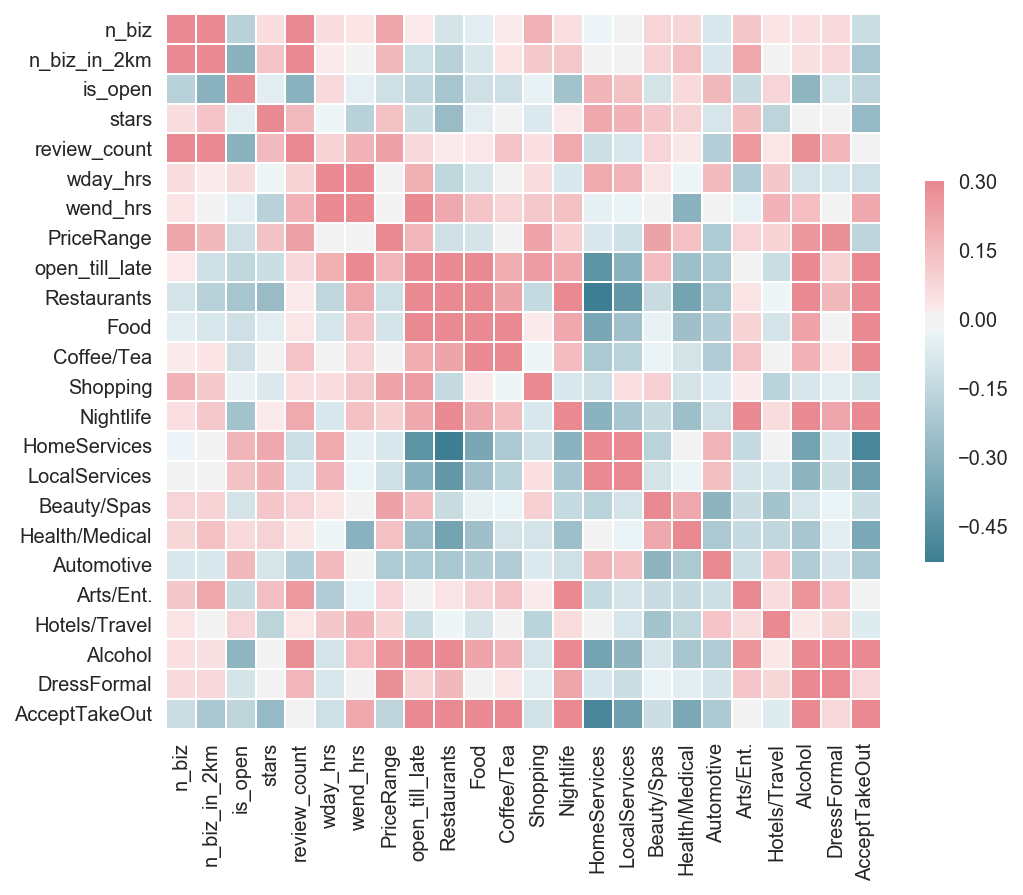

In [34]:
_ = plot_corr(ct_stats)

### K-Means

Original:
For n_clusters = 4 The average silhouette_score is : 0.540991789749


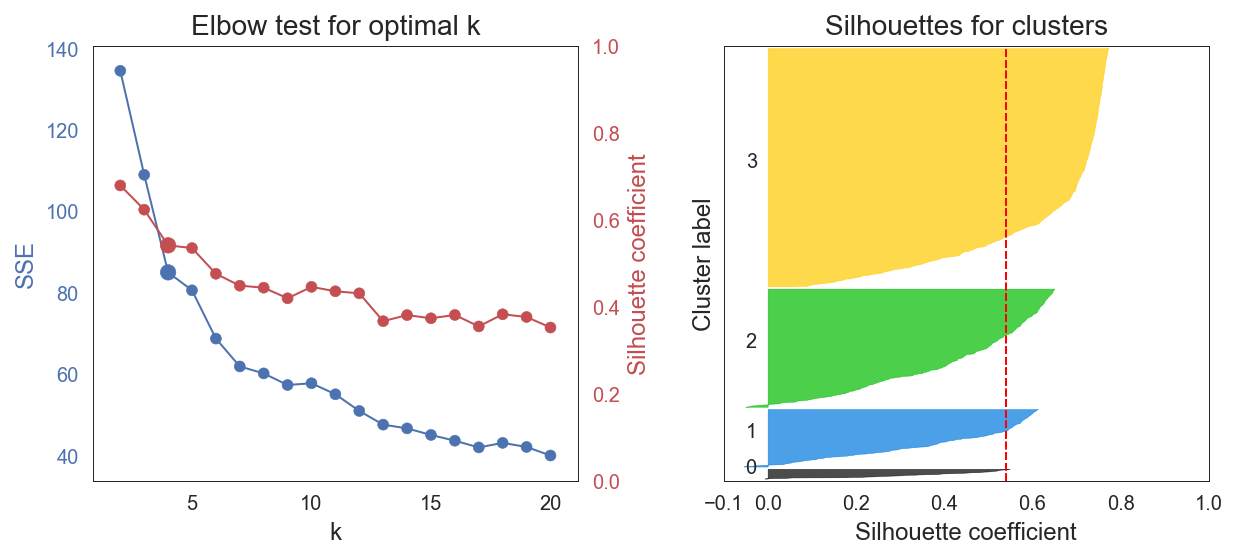

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.448643351516


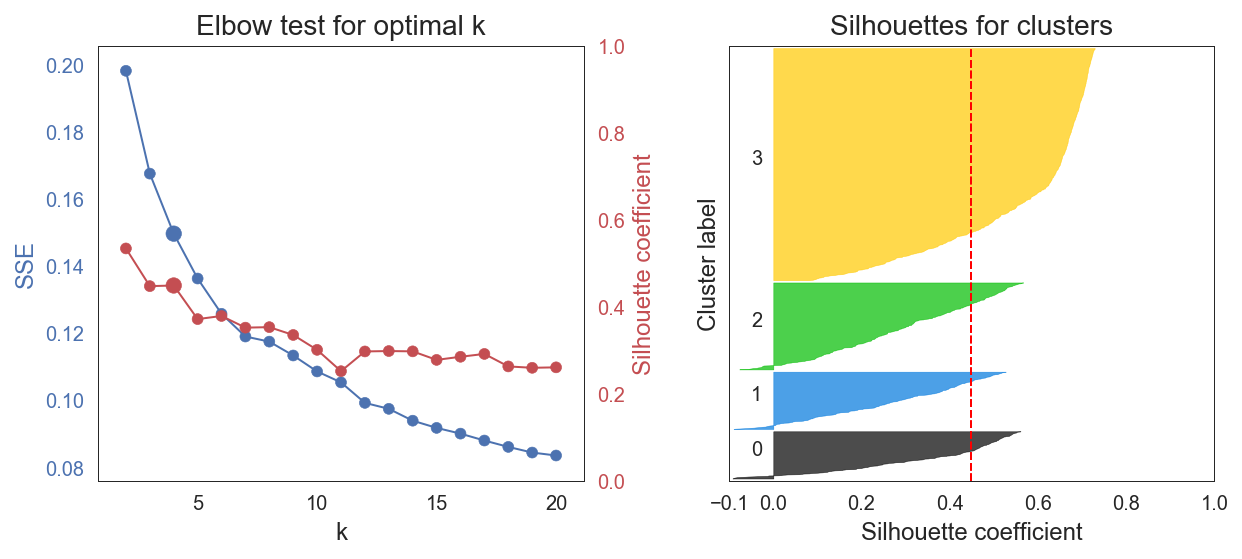

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.19401182  0.31287463]
With normalization
PCA explained ratio: [ 0.4732068   0.55990546]


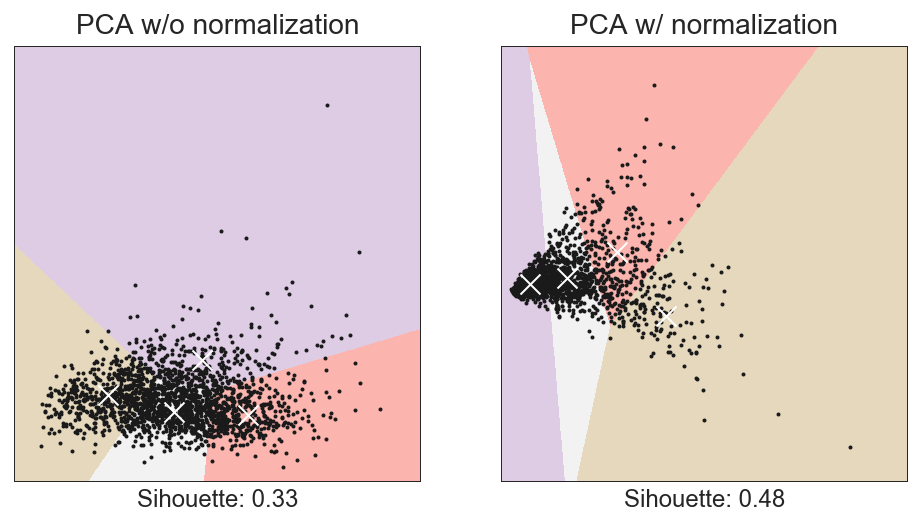

In [35]:
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(ct_stats)

fig1.savefig('../tex/ct-kmeans.pdf', bbox_inches='tight')
fig2.savefig('../tex/ct-kmeans-normalized.pdf', bbox_inches='tight')
fig3.savefig('../tex/ct-kmeans-pca.pdf', bbox_inches='tight')

In [36]:
split_print(fitted1)

n   n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  \
1    46  240.37       1461.03     0.79   3.71         66.22     39.79   
3   270  111.10        684.52     0.82   3.74         37.99     40.21   
2   554   61.45        325.69     0.86   3.69         27.51     40.98   
0  1117   32.56         99.51     0.89   3.61         17.80     40.13   

   wend_hrs  PriceRange  
1     12.84        1.85  
3     11.77        1.73  
2     11.76        1.66  
0     12.21        1.65

n  open_till_late  Rest  Food  Coffee/Tea  Shopping  Nightlife  \
1    46            0.28  0.28  0.12        0.03      0.17       0.12   
3   270            0.29  0.26  0.13        0.03      0.16       0.07   
2   554            0.28  0.23  0.11        0.02      0.15       0.05   
0  1117            0.33  0.32  0.14        0.02      0.14       0.06   

   HomeServices  LocalServices  
1          0.08           0.06  
3          0.10           0.07  
2          0.13           0.08  
0          0.11           0.07

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
1    46         0.10          0.06        0.06       0.07           0.06   
3   270         0.11          0.12        0.07       0.04           0.02   
2   554         0.10          0.11        0.09       0.02           0.03   
0  1117         0.09          0.06        0.09       0.02           0.03   

   Alcohol  DressFormal  AcceptTakeOut  
1     0.20         0.01           0.26  
3     0.13         0.01           0.26  
2     0.10         0.00           0.24  
0     0.13         0.00           0.34

#### Weighted feature scaling

Original:
For n_clusters = 4 The average silhouette_score is : 0.405653508925


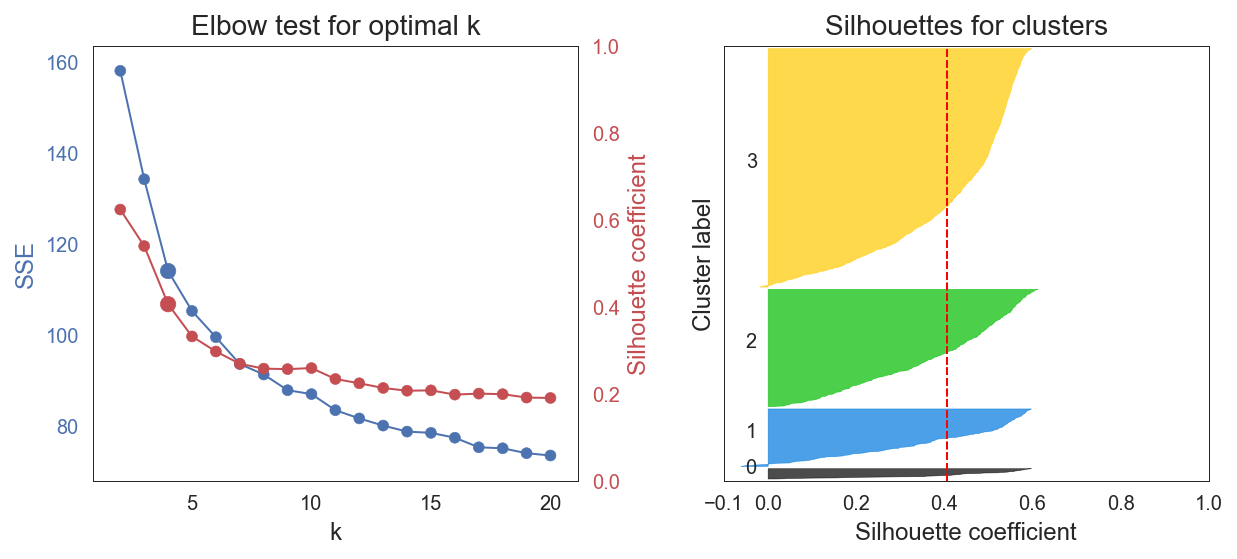

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.279431661462


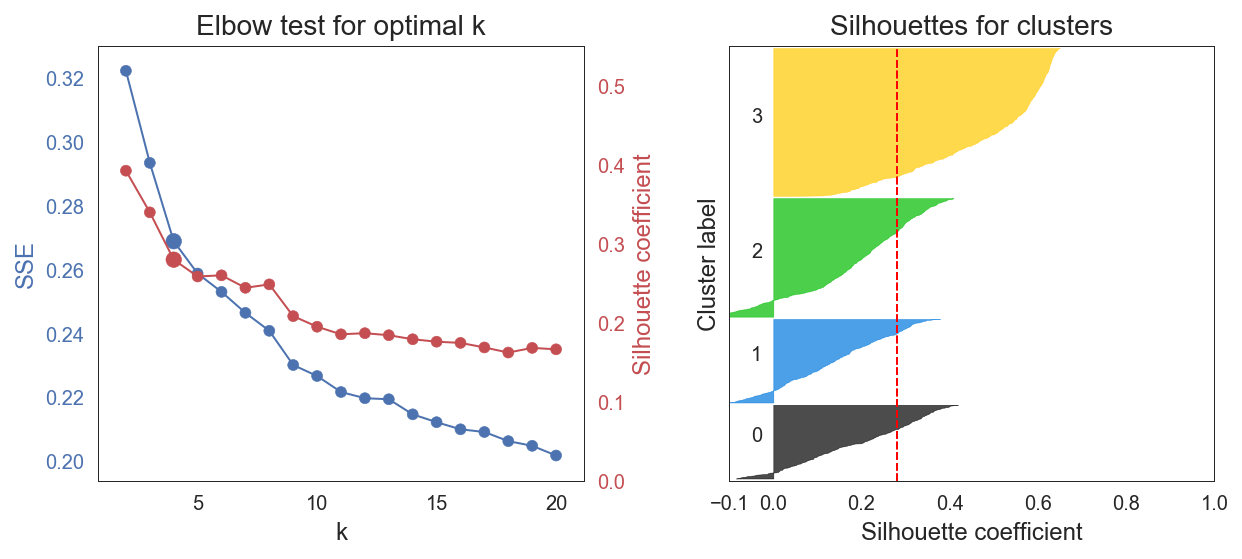

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.19401182  0.31287463]
With normalization
PCA explained ratio: [ 0.3312074   0.45674822]


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  \
1    49   2.28       1437.68    79.07  74.18         64.23     55.36   
3   270   1.11        678.05    82.30  74.93         37.94     56.23   
2   550   0.61        324.96    85.69  73.84         27.49     57.37   
0  1118   0.33         99.61    88.59  72.21         17.82     56.21   

   wend_hrs  PriceRange  
1     44.49       92.64  
3     41.21       86.32  
2     41.03       83.26  
0     42.81       82.69

n  open_till_late   Rest   Food  Coffee/Tea  Shopping  Nightlife  \
1    49           27.47  27.73  12.27       27.19     16.19     122.06   
3   270           29.01  25.70  12.79       28.45     15.84      71.67   
2   550           27.74  22.60  11.18       18.61     14.92      45.05   
0  1118           33.14  32.38  14.13       23.12     13.57      60.87   

   HomeServices  LocalServices  
1          7.93           6.06  
3         10.04           6.97  
2         13.10           8.50  
0         10.53           6.77

n  Beauty/Spas  Health/Medic  Automotive  Arts/Ent.  Hotels/Travel  \
1    49         9.61          6.02        5.49      72.95           5.75   
3   270        11.39         11.69        6.54      35.75           2.32   
2   550        10.24         10.95        8.95      23.36           2.49   
0  1118         9.17          6.30        8.84      22.48           3.17   

   Alcohol  DressFormal  AcceptTakeOut  
1    20.60        13.11          26.32  
3    12.95         6.62          26.09  
2    10.17         2.87          24.00  
0    13.22         4.12          33.75

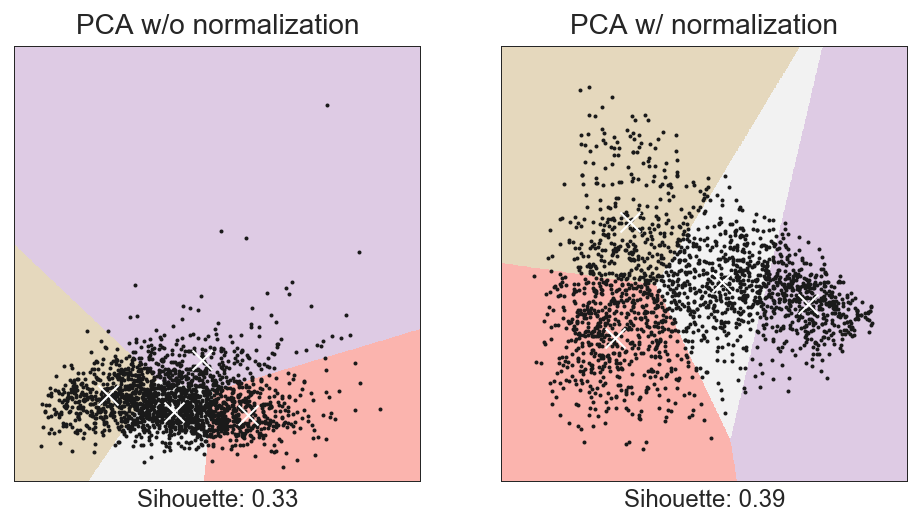

In [37]:
ct_stats_w = weighted_stats(ct_stats)
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(ct_stats_w)
# fig1.savefig('../tex/ct-kmeans-weighted.pdf', bbox_inches='tight')
split_print(fitted1)

#### Without  business density measurements

Original:
For n_clusters = 4 The average silhouette_score is : 0.247492813511


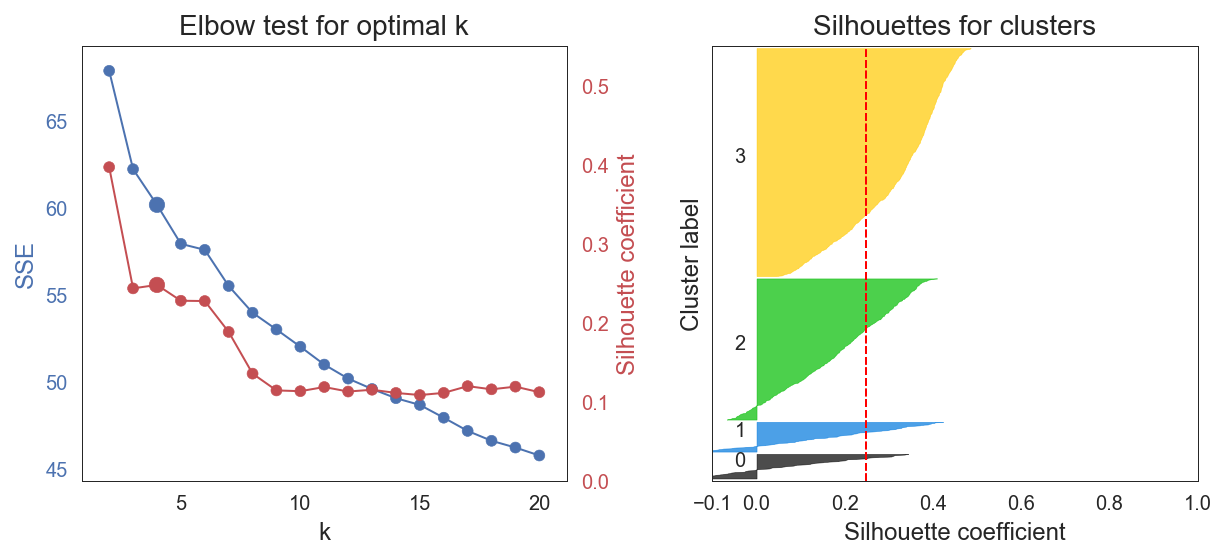

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.161547814946


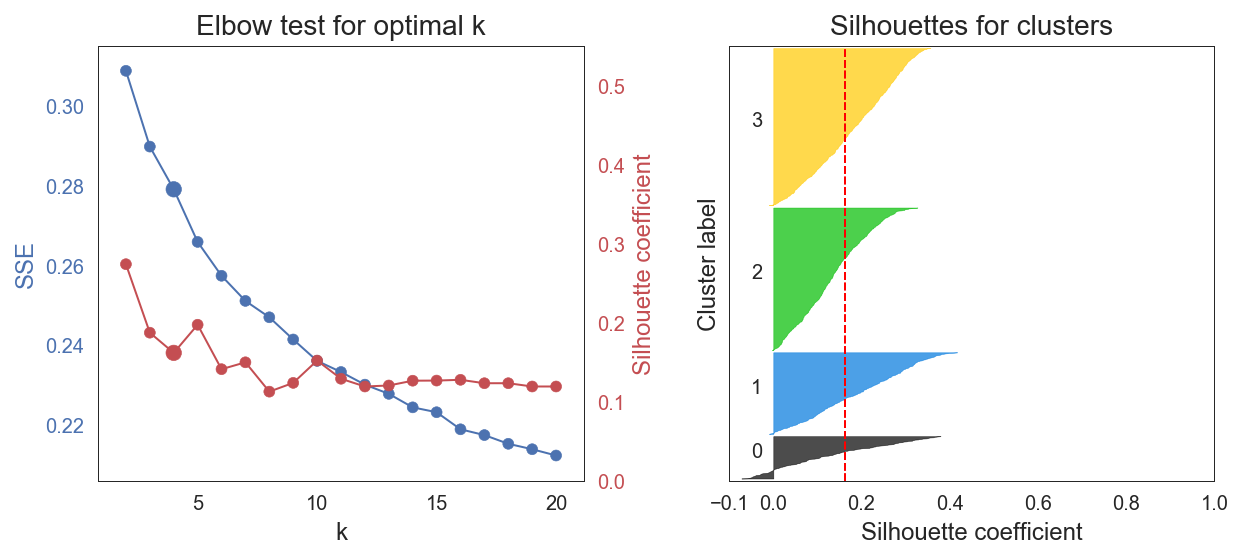

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.21956065  0.32600594]
With normalization
PCA explained ratio: [ 0.25945097  0.40168375]


n  is_open  stars  wday_hrs  wend_hrs  PriceRange  open_till_late  \
3   116    85.65  74.56     51.25     40.25       84.34           28.97   
0   140    83.07  73.91     52.22     43.74       84.82           34.22   
2   662    85.31  72.40     57.43     44.60       84.79           36.25   
1  1069    88.14  73.23     57.09     40.61       82.60           27.43   

    Rest   Food  
3  27.43  14.76  
0  42.66  17.61  
2  35.25  14.64  
1  22.86  11.34

n  Coffee/Tea  Shopping  Nightlife  HomeServices  LocalServices  \
3   116       37.62     14.12      72.79          9.05           6.49   
0   140       35.57     10.95     231.84          5.16           3.40   
2   662       26.73     14.71      89.53          7.80           6.32   
1  1069       16.89     14.53      16.83         14.17           8.43   

   Beauty/Spas  Health/Medic  Automotive  
3         6.99          4.00        7.04  
0         6.65          2.25        5.59  
2         9.53          6.14        7.86  
1        10.65         10.92        9.39

n  Arts/Ent.  Hotels/Travel  Alcohol  DressFormal  AcceptTakeOut
3   116     124.29           3.66    13.71         6.72          26.90
0   140      68.13           3.70    29.98        15.38          40.99
2   662      19.99           3.08    16.85         5.49          35.77
1  1069      13.12           2.66     7.43         1.92          25.00

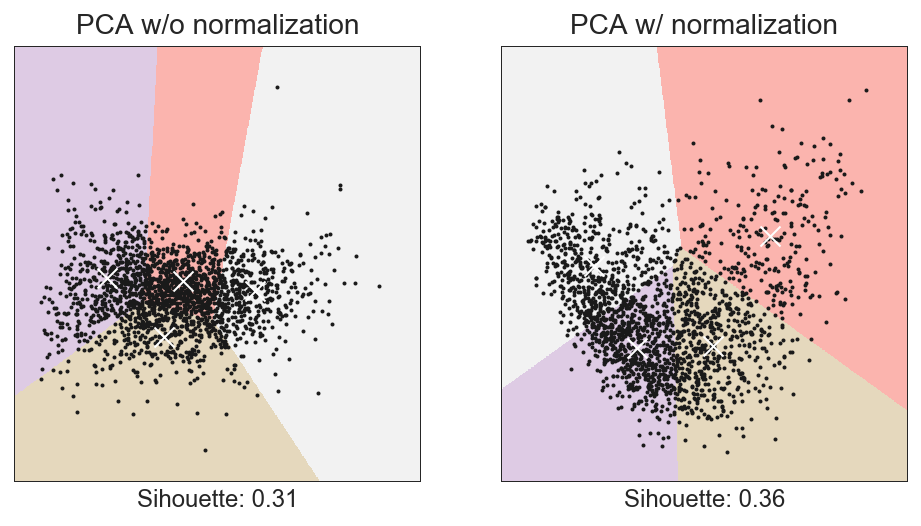

In [38]:
ct_stats_no_dens_w = weighted_stats(ct_stats.drop(['n_biz', 'n_biz_in_2km', 'review_count'], axis=1))
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(ct_stats_no_dens_w)
split_print(fitted1)

#### Standardized

Original:
For n_clusters = 4 The average silhouette_score is : 0.0888990462346


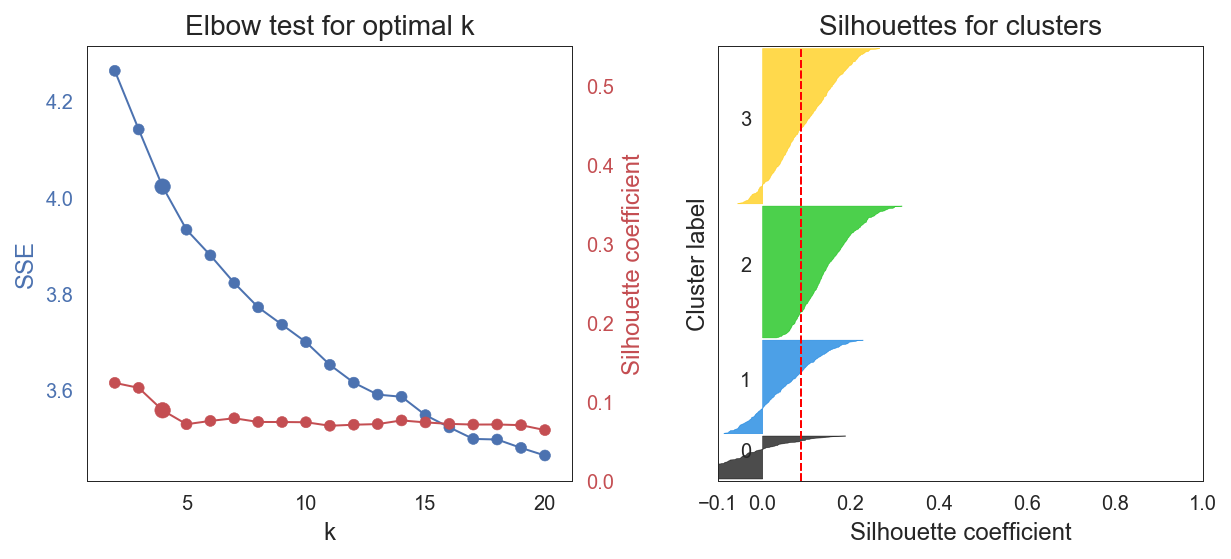

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.102128741631


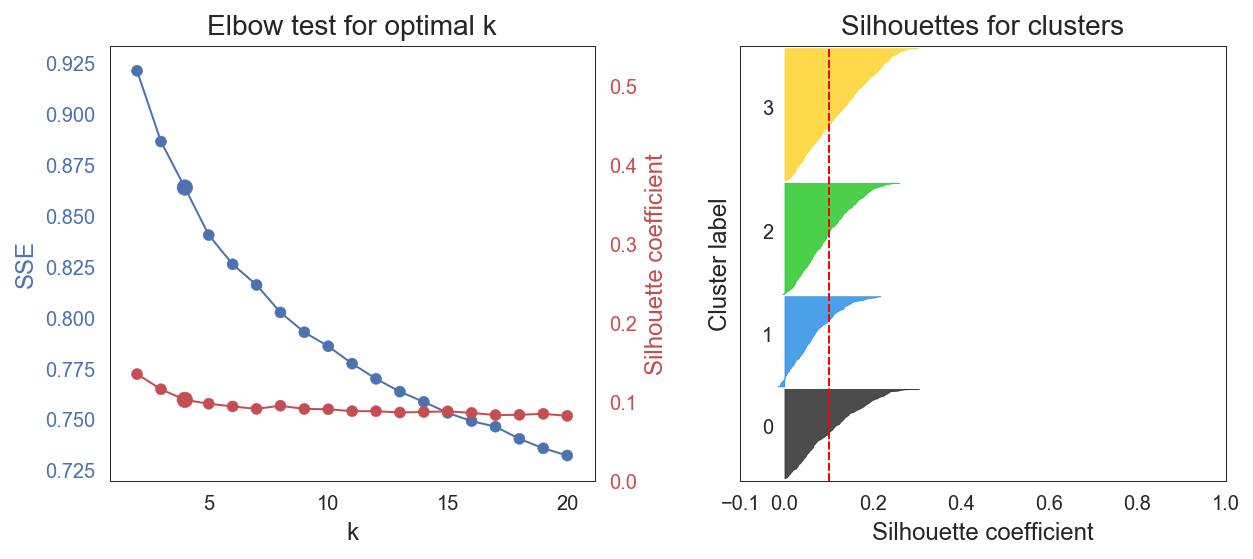

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.19401182  0.31287463]
With normalization
PCA explained ratio: [ 0.18341245  0.30098966]


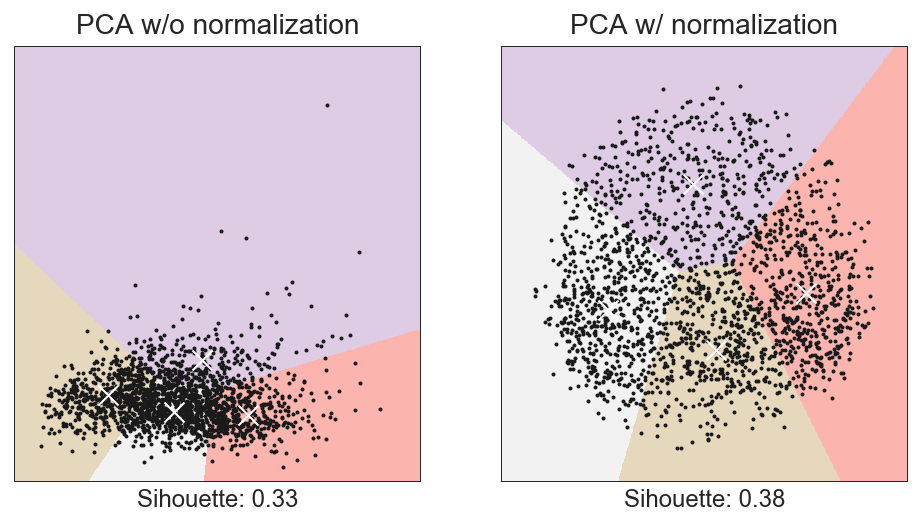

In [39]:
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(standardized(ct_stats))

### GMM

#### PCA Reduced - 16D

PCA explained ratio: [ 0.19401182  0.31287463  0.40173201  0.48083185  0.53930764  0.59149579
  0.64057217  0.68569362  0.72270776  0.75523008  0.78622467  0.81488045
  0.84315546  0.86760466  0.88970134  0.91009141]
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-10, tol=0.0001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 5 The average silhouette_score is : 0.0146864433145


n   pc1   pc2   pc3   pc4   pc5   pc6   pc7   pc8   pc9  pc10  pc11  \
0  191  0.79  2.57  0.41 -0.05  0.38  0.24  0.25  0.05  0.53 -0.06  0.27   
1  263  1.63  0.32 -0.35  1.27  0.00 -0.30 -0.07  0.57 -0.06  0.03 -0.06   
2  438 -1.35 -1.08  0.74  0.81  0.17 -0.05  0.05  0.01  0.01  0.22 -0.13   
3  533 -0.76  0.68 -0.10 -0.68 -0.10  0.29 -0.22 -0.14 -0.08 -0.16  0.09   
4  562  0.76 -0.84 -0.47 -0.61 -0.18 -0.19  0.12 -0.17 -0.08 -0.01 -0.04   

   pc12  pc13  pc14  pc15  pc16  
0  0.22  0.01 -0.02  0.15 -0.09  
1 -0.28  0.37  0.00 -0.02 -0.05  
2  0.21 -0.10 -0.00 -0.09 -0.04  
3 -0.12 -0.11 -0.10 -0.06 -0.05  
4  0.01  0.00  0.11  0.09  0.14

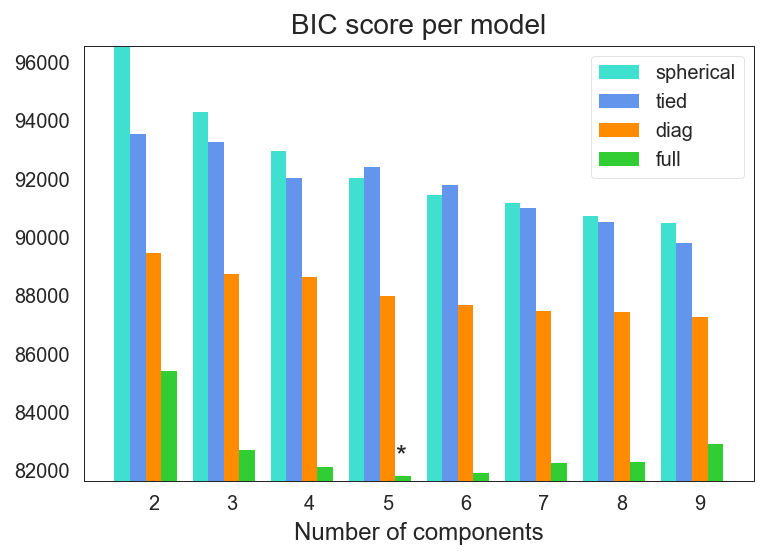

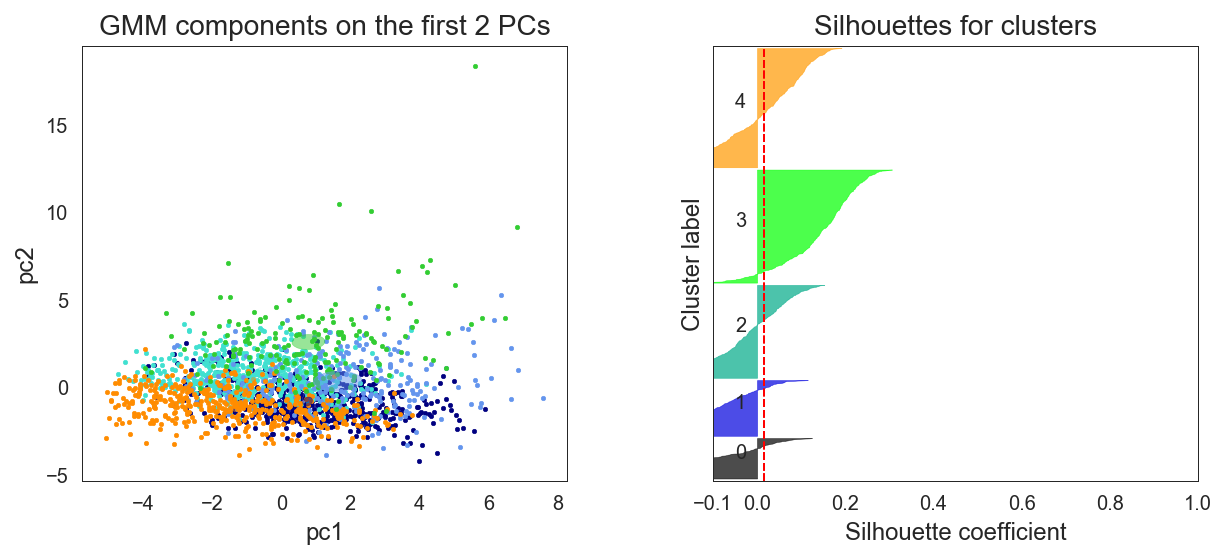

In [66]:
X = pca_reduced_data(ct_stats, 16)
fig1, fig2, fitted, model = fit_gmm(X, reg_covar=1e-10, tol=1e-4, max_iter=200)
fig1.savefig('../tex/ct-gmm-bic.pdf', bbox_inches='tight')
fig2.savefig('../tex/ct-gmm.pdf', bbox_inches='tight')
display(fitted)

#### Normalized

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-10, tol=0.0001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 4 The average silhouette_score is : 0.0408306240505


n  n_biz  n_biz_in_2km  is_open  stars  review_count  wday_hrs  wend_hrs  \
0  358   0.25          0.19    -0.10   0.05          0.17      0.05      0.01   
1  372   0.00          0.06    -0.08  -0.03          0.09      0.02      0.05   
2  386  -0.03         -0.01     0.08   0.07         -0.07      0.03     -0.09   
3  871  -0.08         -0.11     0.03  -0.04         -0.09     -0.02      0.02   

   PriceRange  open_till_late  Restaurants  Food  Coffee/Tea  Shopping  \
0        0.11            0.06        -0.08 -0.06       -0.02      0.15   
1        0.04            0.04         0.06  0.03        0.04     -0.00   
2       -0.05           -0.18        -0.20 -0.13       -0.09     -0.05   
3       -0.05            0.06         0.08  0.06        0.01     -0.01   

   Nightlife  HomeServices  LocalServices  Beauty/Spas  Health/Medical  \
0      -0.05         -0.02          -0.00         0.13            0.11   
1       0.06         -0.07          -0.03        -0.03           -0.06   
2      -0.14          0.19           0.16        -0.03            0.13   
3       0.01         -0.06          -0.04         0.01           -0.06   

   Automotive  Arts/Ent.  Hotels/Travel  Alcohol  DressFormal  AcceptTakeOut  
0       -0.08      -0.01          -0.06    -0.02        -0.01          -0.08  
1       -0.04       0.05           0.11     0.08         0.12           0.05  
2        0.09      -0.09          -0.03    -0.16        -0.06          -0.19  
3       -0.00      -0.02          -0.05     0.01        -0.06           0.09

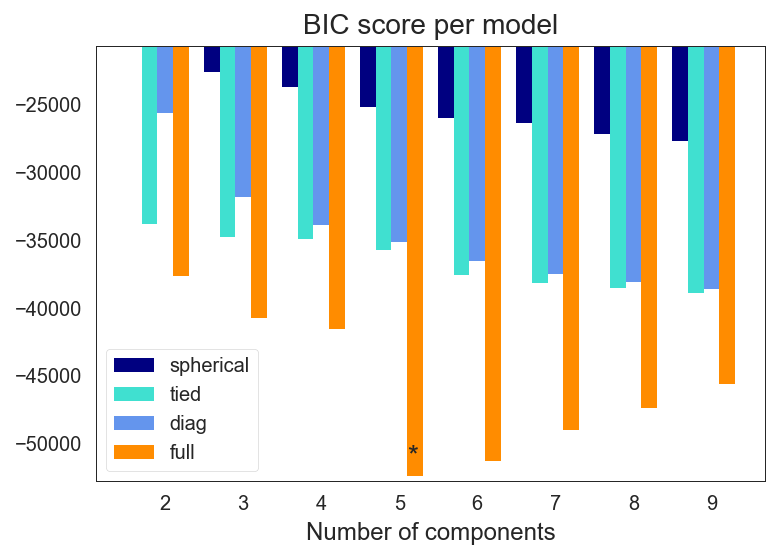

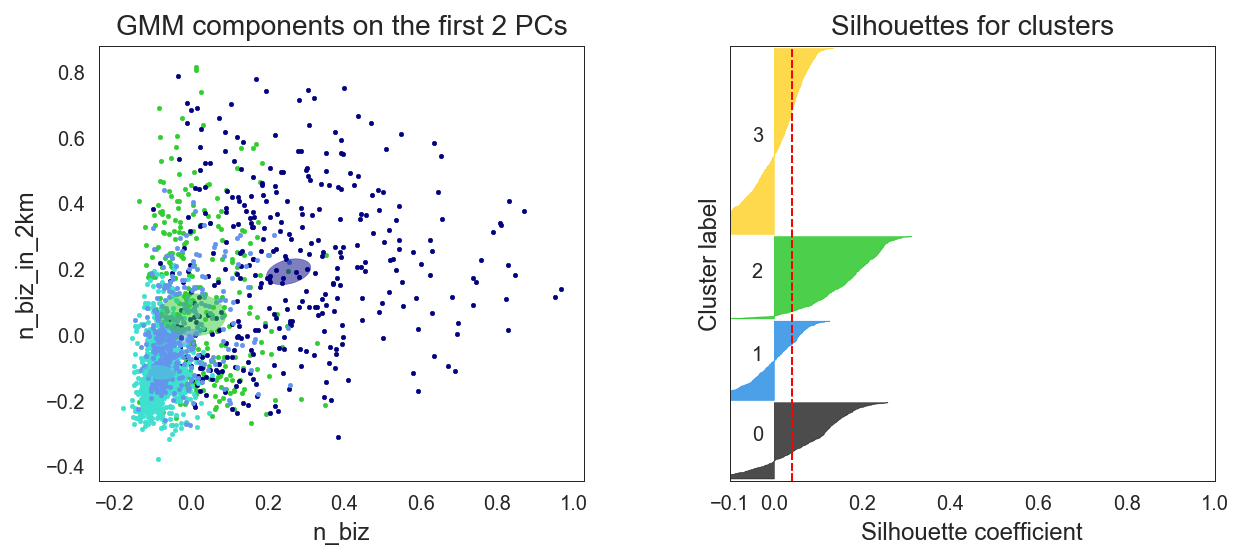

In [41]:
X = normalized(standardized(ct_stats))
fig1, fig2, fitted, model = fit_gmm(X, force_k=4, reg_covar=1e-10, tol=1e-4, max_iter=200)
display(fitted)

#### Without density

When not account for business density

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-10, tol=0.0001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 4 The average silhouette_score is : -0.165868435167


n  is_open  stars  wday_hrs  wend_hrs  PriceRange  open_till_late  \
0  132     0.85   3.66     37.31     11.45        1.83            0.31   
1  166     0.83   3.71     41.28     12.48        1.88            0.35   
2  822     0.88   3.64     39.96     12.30        1.61            0.30   
3  867     0.87   3.65     41.06     11.80        1.66            0.31   

   Restaurants  Food  Coffee/Tea  Shopping  Nightlife  HomeServices  \
0         0.35  0.14        0.03      0.11       0.12          0.07   
1         0.28  0.12        0.02      0.20       0.07          0.10   
2         0.32  0.14        0.02      0.12       0.07          0.12   
3         0.25  0.12        0.02      0.16       0.04          0.11   

   LocalServices  Beauty/Spas  Health/Medical  Automotive  Arts/Ent.  \
0           0.04         0.08            0.09        0.05       0.06   
1           0.06         0.12            0.10        0.06       0.03   
2           0.07         0.07            0.04        0.12       0.03   
3           0.08         0.13            0.12        0.07       0.02   

   Hotels/Travel  Alcohol  DressFormal  AcceptTakeOut  
0           0.05     0.22         0.05           0.34  
1           0.03     0.16         0.02           0.27  
2           0.04     0.13         0.00           0.33  
3           0.01     0.10         0.00           0.27

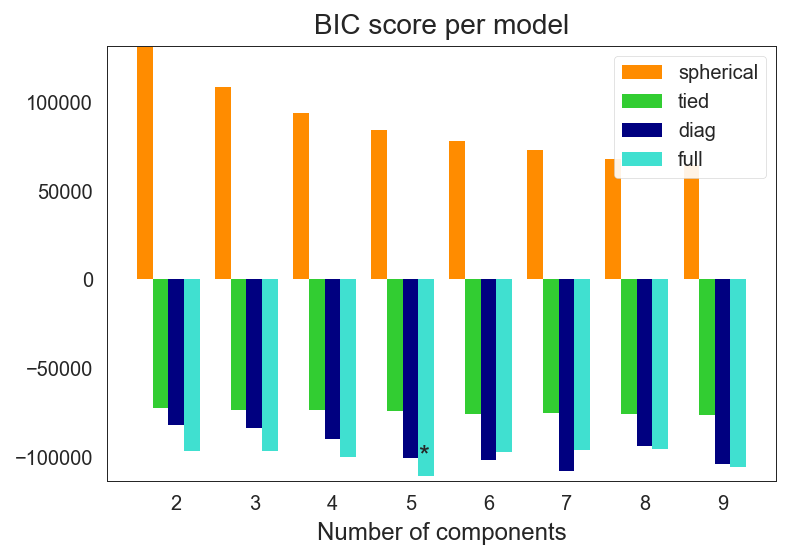

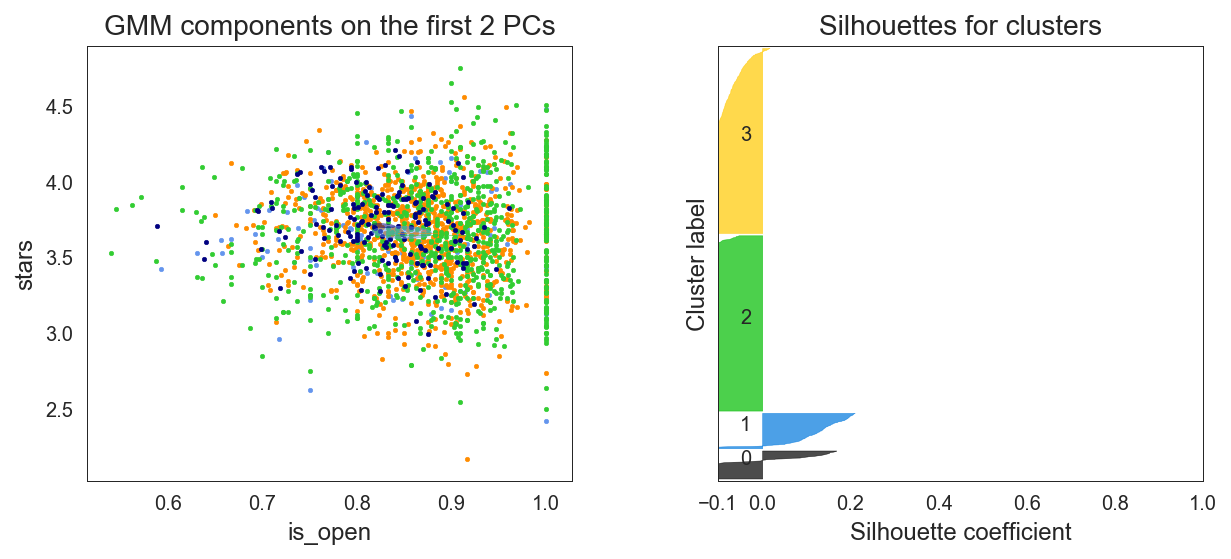

In [42]:
ct_stats_wo_biz_count = ct_stats.drop(['n_biz', 'n_biz_in_2km', 'review_count'], axis=1)
X = ct_stats_wo_biz_count
fig1, fig2, fitted, model = fit_gmm(X, force_k=4, reg_covar=1e-10, tol=1e-4, max_iter=200)
display(fitted)

<a name="census-main"></a>

# Clustering on Census Data

## Load data

In [65]:
def load_aci(csv_file):
    """
    aci stands for Americon Community Survey Indicators
    """
    aci = pd.read_csv(csv_file, dtype={'ct_id': str})
    
    # there are NA's in the ACI dataset, let's find out where are they
    display(aci[aci.isnull().mean(axis=1) != 0])
    
    # It's mostly those without any population and those missing values
    # for housing related variables. We'll remove those without any population
    # (and those with less than 10 people), and impute the housing variables
    # with median values of the whole dataset.
    aci = aci[aci['TotalPop'] >= 10]
    
    # impute missing values with medians
    aci = aci.fillna(aci.median())
    
    # remove the two geographic reliant variables
    aci = aci.drop(['TotalPop', 'land_area'], axis=1)
    
    return aci
    
aci = load_aci("../data/step0/aci.csv")
aci_name_only = aci.loc[:,['ct_name','ct_id']]

# drop non-numeric variables - or move them to index
aci = aci.set_index('ct_id')
aci = aci.drop(['ct_name'], axis=1)

aci

ct_name        ct_id  \
321   Census Tract 9801, Mecklenburg County, North C...  37119980100   
322   Census Tract 9802, Mecklenburg County, North C...  37119980200   
...                                                 ...          ...   
2944        Census Tract 60, Champaign County, Illinois  17019006000   
2960           Census Tract 9800, Cook County, Illinois  17031980000   

      TotalPop    Female      Male     AgeU5    Age517   Age1824   Age2534  \
321        0.0       NaN       NaN       NaN       NaN       NaN       NaN   
322        0.0       NaN       NaN       NaN       NaN       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
2944    3573.0  0.471592  0.528408  0.051217  0.026308  0.675903  0.169605   
2960       0.0       NaN       NaN       NaN       NaN       NaN       NaN   

       Age3544   Age4554   Age5559  Age6061   Age6264   Age6574    Age75P  \
321        NaN       NaN       NaN      NaN       NaN       NaN       NaN   
322        NaN       NaN       NaN      NaN       NaN       NaN       NaN   
...        ...       ...       ...      ...       ...       ...       ...   
2944  0.052617  0.005877  0.003918      0.0  0.001679  0.006437  0.006437   
2960       NaN       NaN       NaN      NaN       NaN       NaN       NaN   

      BornInState  BornInOtherState  NativeBornOutOfUS  \
321           NaN               NaN                NaN   
322           NaN               NaN                NaN   
...           ...               ...                ...   
2944     0.520571          0.160929           0.017072   
2960          NaN               NaN                NaN   

      ForeignBornNaturalized  ForeignBornNonCitizen     White     Black  \
321                      NaN                    NaN       NaN       NaN   
322                      NaN                    NaN       NaN       NaN   
...                      ...                    ...       ...       ...   
2944                0.043101               0.258326  0.425133  0.097117   
2960                     NaN                    NaN       NaN       NaN   

         Asian  OtherRace     ...      PopPerHousing  VacentUnits  \
321        NaN        NaN     ...                NaN          NaN   
322        NaN        NaN     ...                NaN          NaN   
...        ...        ...     ...                ...          ...   
2944  0.383151        0.0     ...              119.1     0.950495   
2960       NaN        NaN     ...                NaN          NaN   

      OwnerOccupied  RenterOccupied  BelowHalfPoverty  BelowPoverty  \
321             NaN             NaN               NaN           NaN   
322             NaN             NaN               NaN           NaN   
...             ...             ...               ...           ...   
2944       0.049505        0.950495          0.249036      0.423285   
2960            NaN             NaN               NaN           NaN   

      BelowTwoPoverty  AboveTwoPoverty  PubAssist  UnempRate  ChildInNeed  \
321               NaN              NaN        NaN        NaN          NaN   
322               NaN              NaN        NaN        NaN          NaN   
...               ...              ...        ...        ...          ...   
2944          0.69468          0.30532        0.0   0.162088     0.146067   
2960              NaN              NaN        NaN        NaN          NaN   

      ChildInNeed_SingleParent  ChildInNeed_SingleMom  ChildInNeed_Nonfamily  \
321                        NaN                    NaN                    NaN   
322                        NaN                    NaN                    NaN   
...                        ...                    ...                    ...   
2944                  0.022472               0.022472                    0.0   
2960                       NaN                    NaN                    NaN   

        EthHet  HH_MarriedCouple  HH_SingleHead  HH_MaleHead  HH_FemaleHead  \
321        NaN    

Female      Male     AgeU5    Age517   Age1824   Age2534  \
ct_id                                                                     
37001021500  0.463551  0.536449  0.059190  0.152856  0.037175  0.131049   
37021003001  0.488012  0.511988  0.037454  0.130483  0.100873  0.155010   
...               ...       ...       ...       ...       ...       ...   
17147954800  0.514755  0.485245  0.070975  0.205080  0.091894  0.094135   
17183010800  0.497261  0.502739  0.058807  0.163159  0.091957  0.094263   

              Age3544   Age4554   Age5559   Age6061   Age6264   Age6574  \
ct_id                                                                     
37001021500  0.120457  0.204154  0.086812  0.018692  0.037383  0.091796   
37021003001  0.111700  0.113468  0.070158  0.040327  0.053254  0.113689   
...               ...       ...       ...       ...       ...       ...   
17147954800  0.132238  0.143071  0.054539  0.024281  0.026522  0.078820   
17183010800  0.102623  0.164312  0.067455  0.036610  0.036033  0.096858   

               Age75P  BornInState  BornInOtherState  NativeBornOutOfUS  \
ct_id                                                                     
37001021500  0.060436     0.699273          0.242575           0.004361   
37021003001  0.073583     0.528339          0.435201           0.003867   
...               ...          ...               ...                ...   
17147954800  0.078446     0.845349          0.150168           0.000747   
17183010800  0.087922     0.878063          0.118766           0.000000   

             ForeignBornNaturalized  ForeignBornNonCitizen     White  \
ct_id                                                                  
37001021500                0.011007               0.042783  0.891381   
37021003001                0.012374               0.020219  0.865982   
...                             ...                    ...       ...   
17147954800                0.000000               0.003736  0.961524   
17183010800                0.000577               0.002594  0.934563   

                Black     Asian  OtherRace  Hispanic  TwoOrMore  \
ct_id                                                             
37001021500  0.046314  0.000000   0.000000  0.057736   0.004569   
37021003001  0.049387  0.001657   0.005414  0.051486   0.026074   
...               ...       ...        ...       ...        ...   
17147954800  0.005230  0.000000   0.000000  0.002241   0.031005   
17183010800  0.006342  0.002018   0.000000  0.041799   0.015278   

             MedHouseIncome     ...      AtLeastBachelor  PopPerHousing  \
ct_id                           ...                                       
37001021500         54674.0     ...             0.164315       3.059085   
37021003001         48500.0     ...             0.308552       3.597377   
...                     ...     ...                  ...            ...   
17147954800         60185.0     ...             0.221631       3.031710   
17183010800         53021.0     ...             0.158403       2.932375   

             VacentUnits  OwnerOccupied  RenterOccupied  BelowHalfPoverty  \
ct_id                                                                       
37001021500     0.125556       0.874444        0.125556          0.014746   
37021003001     0.319632       0.680368        0.319632          0.056817   
...                  ...            ...             ...               ...   
17147954800     0.146035       0.853965        0.146035          0.009012   
17183010800     0.191388       0.808612        0.191388          0.026293   

             BelowPoverty  BelowTwoPoverty  AboveTwoPoverty  PubAssist  \
ct_id                                                                    
37001021500      0.087850         0.252544         0.747456   0.005000   
37021003001      0.120736         0.366282         0.633718   0.005408   
...                   ...              ...              ...        ...   
17147954800      0.078107 

The ACI dataset includes all census tracts that have a business. Since we have filtered our aggregated measurements by minimal business count, we would want to filter the ACI data too.

In [44]:
def semi_join(df1, df2):
    idxer = pd.Series(df1.index.values).isin(df2.index.tolist())
    idxer.index = df1.index
    return df1[idxer]

aci_min_10 = semi_join(aci, ct_stats)
ct_stats_min_10 = semi_join(ct_stats, aci)

display(aci_min_10)
display(ct_stats_min_10)

Female      Male     AgeU5    Age517   Age1824   Age2534  \
ct_id                                                                     
37021003203  0.523864  0.476136  0.059823  0.199902  0.040700  0.151847   
37025040500  0.486941  0.513059  0.100632  0.189741  0.083646  0.143052   
...               ...       ...       ...       ...       ...       ...   
17041952200  0.518552  0.481448  0.027492  0.192669  0.084041  0.096558   
17147954600  0.530652  0.469348  0.061466  0.179209  0.044437  0.127960   

              Age3544   Age4554   Age5559   Age6061   Age6264   Age6574  \
ct_id                                                                     
37021003203  0.135011  0.101994  0.077313  0.040536  0.033344  0.107061   
37025040500  0.162854  0.100973  0.058211  0.015449  0.033544  0.067600   
...               ...       ...       ...       ...       ...       ...   
17041952200  0.141484  0.165177  0.063701  0.030398  0.027716  0.087841   
17147954600  0.122770  0.120175  0.078819  0.022056  0.045410  0.108336   

               Age75P  BornInState  BornInOtherState  NativeBornOutOfUS  \
ct_id                                                                     
37021003203  0.052468     0.456685          0.490029           0.007028   
37025040500  0.044298     0.593547          0.317258           0.015108   
...               ...          ...               ...                ...   
17041952200  0.082924     0.795932          0.163165           0.006482   
17147954600  0.089361     0.870581          0.122446           0.001622   

             ForeignBornNaturalized  ForeignBornNonCitizen     White  \
ct_id                                                                  
37021003203                0.012259               0.033998  0.805002   
37025040500                0.010157               0.063930  0.661830   
...                             ...                    ...       ...   
17041952200                0.026822               0.007599  0.911489   
17147954600                0.000000               0.005352  0.974862   

                Black     Asian  OtherRace  Hispanic  TwoOrMore  \
ct_id                                                             
37021003203  0.096437  0.002125   0.000000  0.049199   0.047238   
37025040500  0.162086  0.000000   0.000000  0.165671   0.010413   
...               ...       ...        ...       ...        ...   
17041952200  0.011846  0.023022   0.001788  0.051855   0.000000   
17147954600  0.006649  0.000000   0.000000  0.017353   0.001135   

             MedHouseIncome     ...      AtLeastBachelor  PopPerHousing  \
ct_id                           ...                                       
37021003203         51731.0     ...             0.410514       4.452693   
37025040500         60521.0     ...             0.230843       3.701738   
...                     ...     ...                  ...            ...   
17041952200         50019.0     ...             0.222615       3.053925   
17147954600         73134.0     ...             0.386570       2.961575   

             VacentUnits  OwnerOccupied  RenterOccupied  BelowHalfPoverty  \
ct_id                                                                       
37021003203     0.404163       0.595837        0.404163          0.036098   
37025040500     0.221019       0.778981        0.221019          0.012120   
...                  ...            ...             ...               ...   
17041952200     0.234187       0.765813        0.234187          0.015267   
17147954600     0.171178       0.828822        0.171178          0.013862   

             BelowPoverty  BelowTwoPoverty  AboveTwoPoverty  PubAssist  \
ct_id                                                                    
37021003203      0.086467         0.333445         0.666555   0.010408   
37025040500      0.114971         0.319648         0.680352   0.000000   
...                   ...              ...              ...        ...   
17041952200      0.092726 

n_biz  n_biz_in_2km   is_open     stars  review_count   wday_hrs  \
CT_ID                                                                           
32003006700   1767   2742.401245  0.802490  3.594793    203.042445  43.269053   
32003002302    602   2404.418605  0.790698  3.665282    101.425249  37.732558   
...            ...           ...       ...       ...           ...        ...   
04013010102     29      1.758621  0.965517  4.224138     20.620690  20.086207   
04013040517     16      0.000000  0.875000  4.062500      4.875000  42.625000   

              wend_hrs  PriceRange  open_till_late  Restaurants      Food  \
CT_ID                                                                       
32003006700  17.418487    2.371550        0.353707     0.331070  0.150538   
32003002302  14.210548    2.299550        0.390365     0.255814  0.101329   
...                ...         ...             ...          ...       ...   
04013010102   6.551724    2.000000        0.068966     0.206897  0.034483   
04013040517  10.250000    1.666667        0.250000     0.062500  0.062500   

             Coffee/Tea  Shopping  Nightlife  HomeServices  LocalServices  \
CT_ID                                                                       
32003006700     0.04867  0.237125   0.228636      0.007357       0.011885   
32003002302     0.02990  0.305648   0.132890      0.009967       0.026578   
...                 ...       ...        ...           ...            ...   
04013010102     0.00000  0.000000   0.034483      0.137931       0.000000   
04013040517     0.00000  0.062500   0.000000      0.562500       0.187500   

             Beauty/Spas  Health/Medical  Automotive  Arts/Ent.  \
CT_ID                                                             
32003006700     0.063384        0.007357    0.003396   0.175439   
32003002302     0.109635        0.024917    0.011628   0.137874   
...                  ...             ...         ...        ...   
04013010102     0.034483        0.000000    0.034483   0.000000   
04013040517     0.000000        0.000000    0.062500   0.000000   

             Hotels/Travel   Alcohol  DressFormal  AcceptTakeOut  
CT_ID                                                             
32003006700       0.074137  0.353707     0.052632       0.292586  
32003002302       0.093023  0.200997     0.031561       0.196013  
...                    ...       ...          ...            ...  
04013010102       0.172414  0.068966     0.000000       0.103448  
04013040517       0.062500  0.062500     0.000000       0.000000  

[1969 rows x 24 columns]

### Correlation

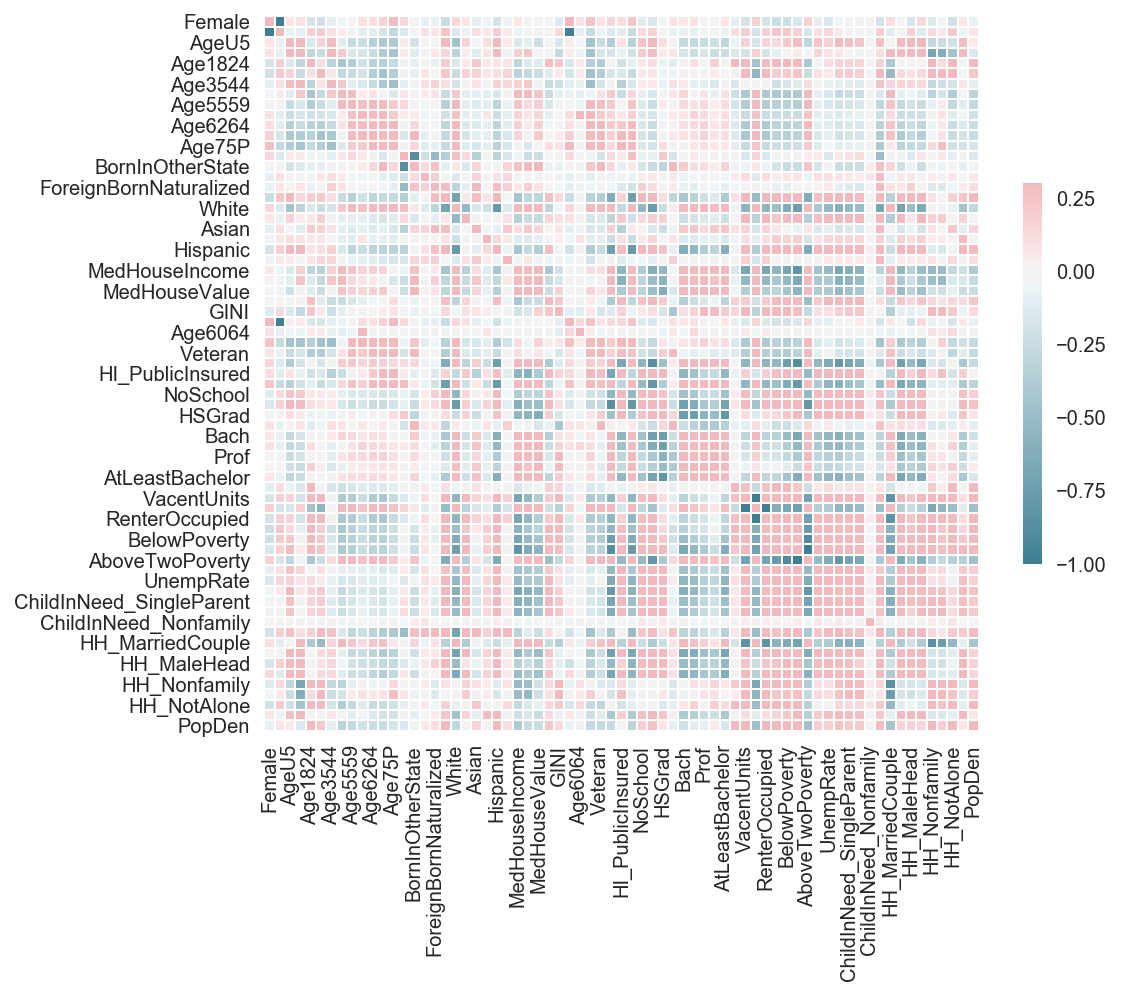

In [45]:
fig = plot_corr(aci_min_10)
fig.savefig('../tex/aci-corr.pdf', bbox_inches='tight')

In [46]:
# pretty print the variables
for i, name in enumerate(aci_min_10.columns):
    if i % 2 == 0:
        print(f'{name: <28}', end='')
    else:
        print(f'{name: <26}')

Female                      Male                      
AgeU5                       Age517                    
Age1824                     Age2534                   
Age3544                     Age4554                   
Age5559                     Age6061                   
Age6264                     Age6574                   
Age75P                      BornInState               
BornInOtherState            NativeBornOutOfUS         
ForeignBornNaturalized      ForeignBornNonCitizen     
White                       Black                     
Asian                       OtherRace                 
Hispanic                    TwoOrMore                 
MedHouseIncome              MedHousingCost            
MedHouseValue               MedRentAsIncomePct        
GINI                        SexRatio                  
Age6064                     AgeOld                    
Veteran                     HI_PrivateInsured         
HI_PublicInsured            HI_Insured                
NoSchool  

### K-Means

Original:
For n_clusters = 4 The average silhouette_score is : 0.108735752585


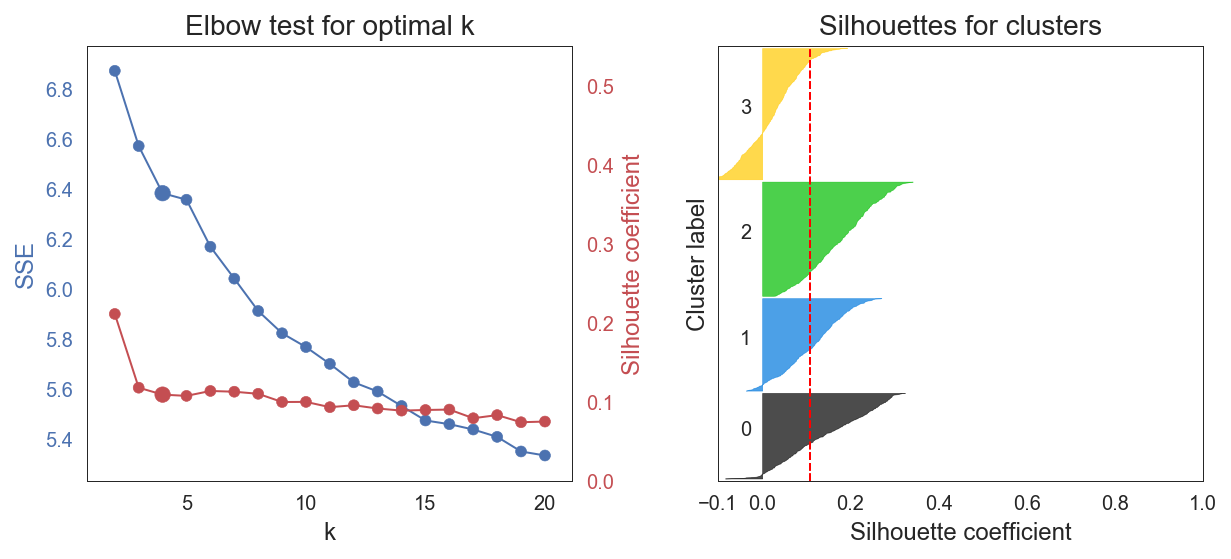

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.138139820029


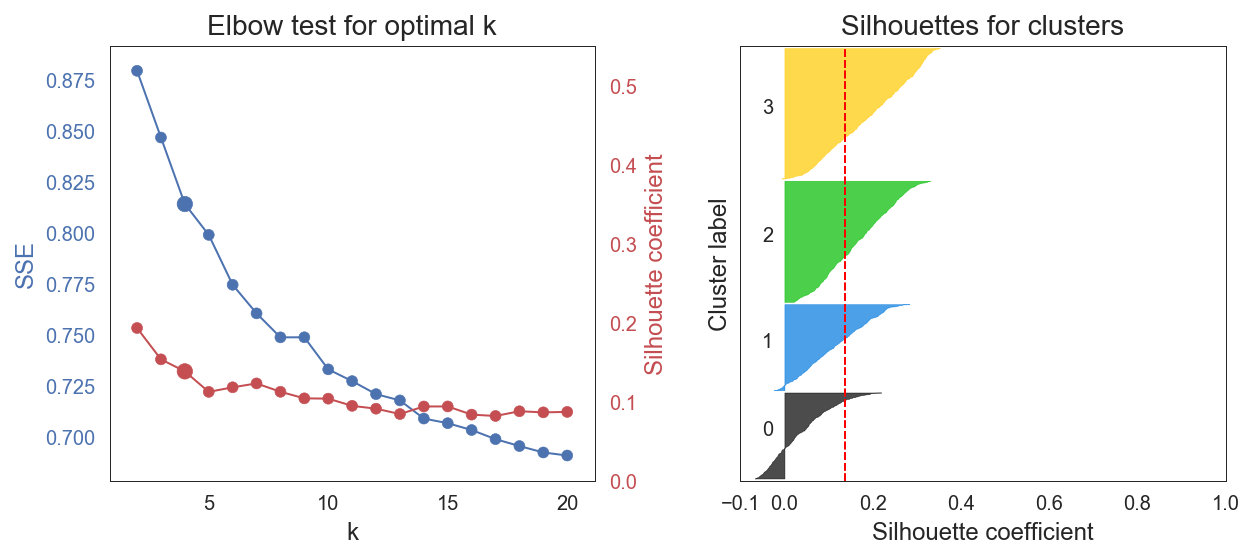

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.28695607  0.39454863]
With normalization
PCA explained ratio: [ 0.27111438  0.3690438 ]


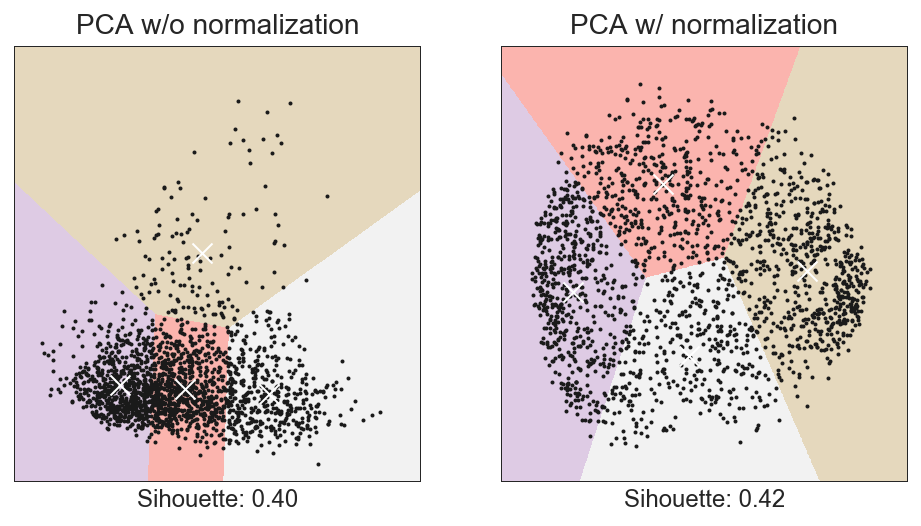

In [47]:
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(standardized(aci_min_10))

#### Minimal 20 businesses?

Original:
For n_clusters = 4 The average silhouette_score is : 0.523912054234


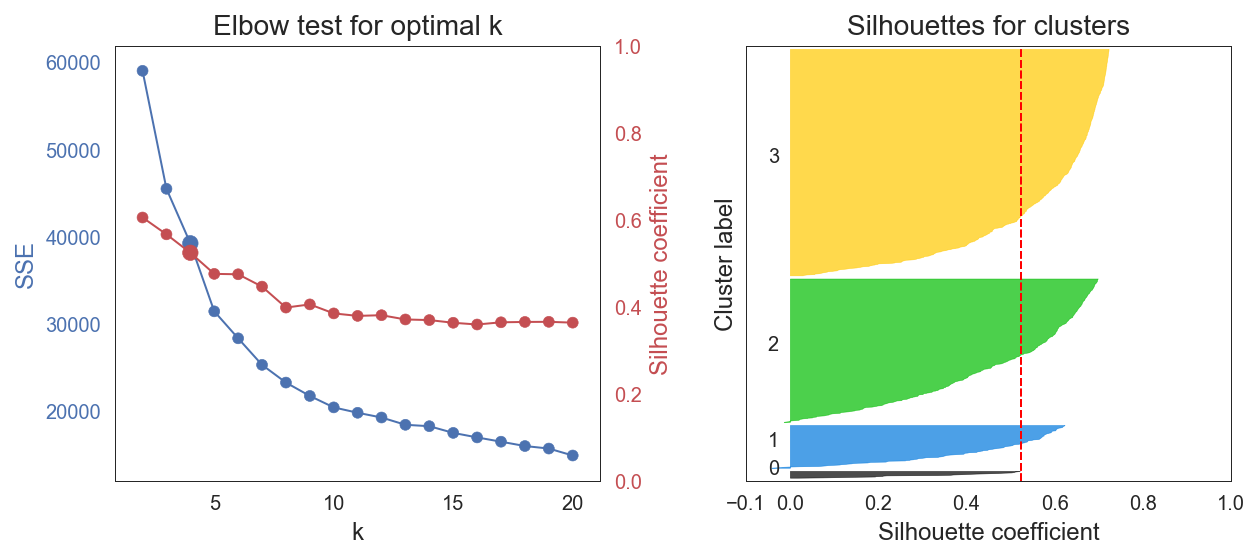

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.501602953183


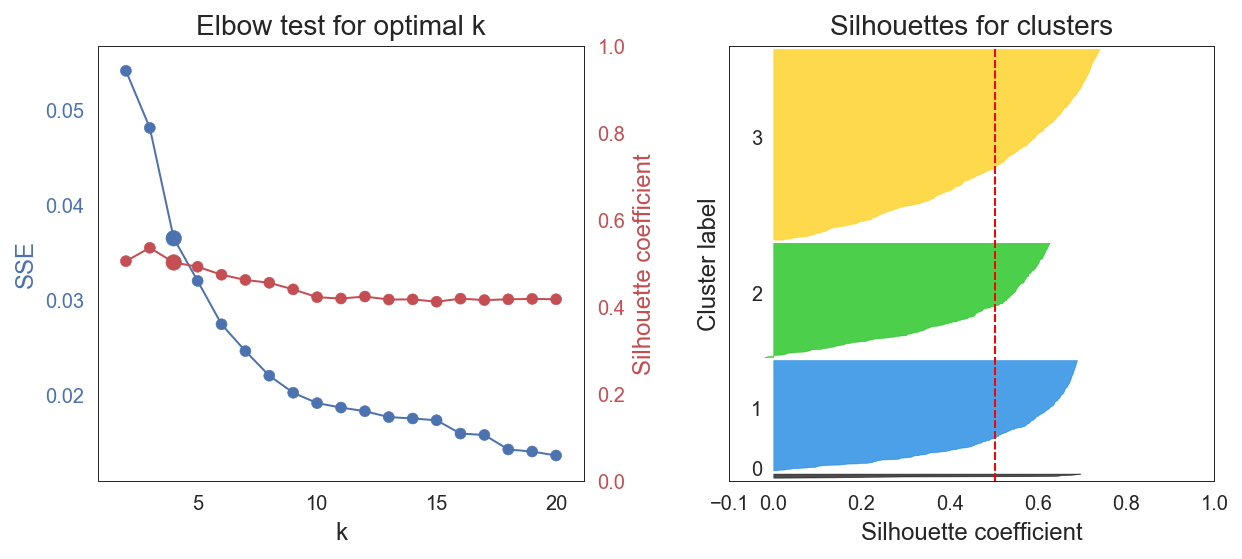

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.28247285  0.39594558]
With normalization
PCA explained ratio: [ 0.48477676  0.58761952]


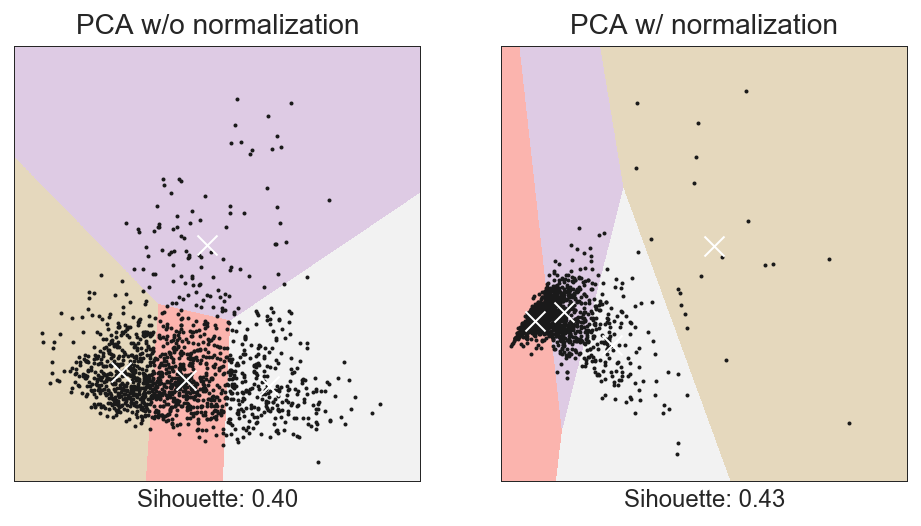

In [48]:
aci_min_20 = semi_join(aci, ct_stats_min_20)
ct_stats_min_20 = semi_join(ct_stats_min_20, aci)

fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(aci_min_20)

Doesn't make much difference.

### Apply PCA before Clustering 

PCA explained ratio: [ 0.28695607  0.39454863  0.48659793  0.54049727  0.58413375  0.62509259
  0.65842468  0.68453597  0.70808881  0.72740591  0.74378123  0.75917206
  0.77400876  0.78735452  0.79949442  0.81116869  0.822352    0.83306696
  0.84306599  0.85255741  0.86172875  0.87052976  0.87917547  0.8871202
  0.89485987  0.90247441]
Original:
For n_clusters = 4 The average silhouette_score is : 0.142947939923


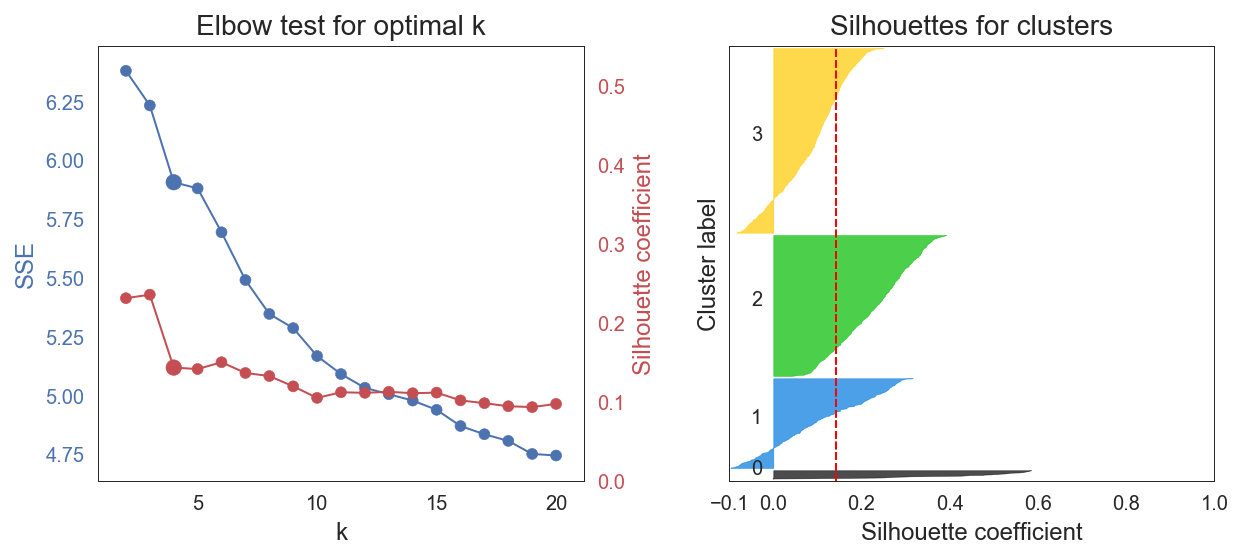

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.161341902574


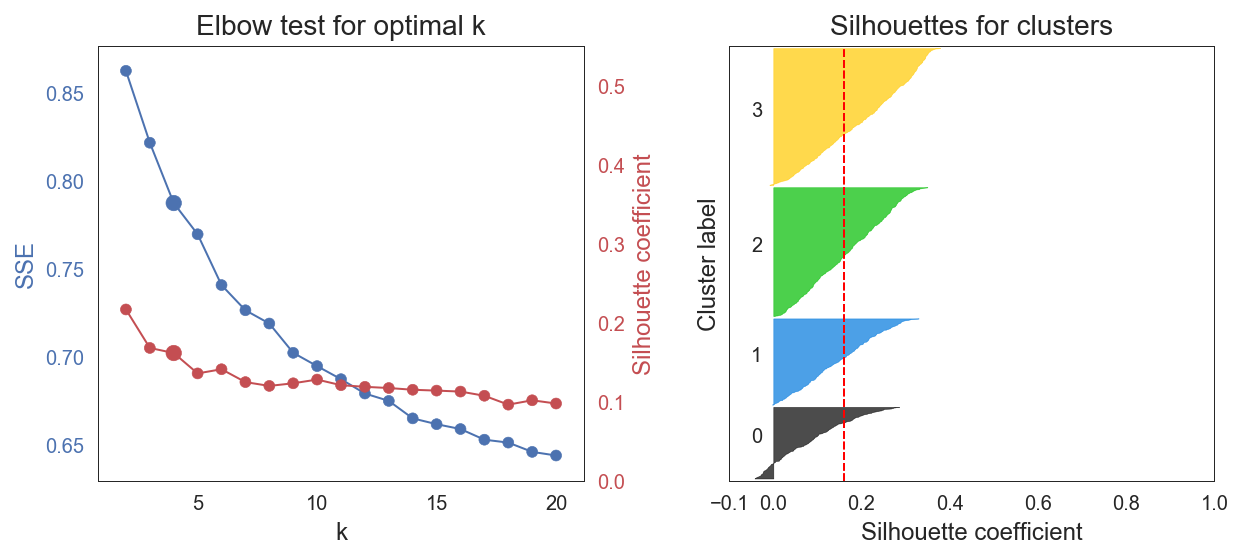

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.03846154  0.07692308]
With normalization
PCA explained ratio: [ 0.06880738  0.12862295]


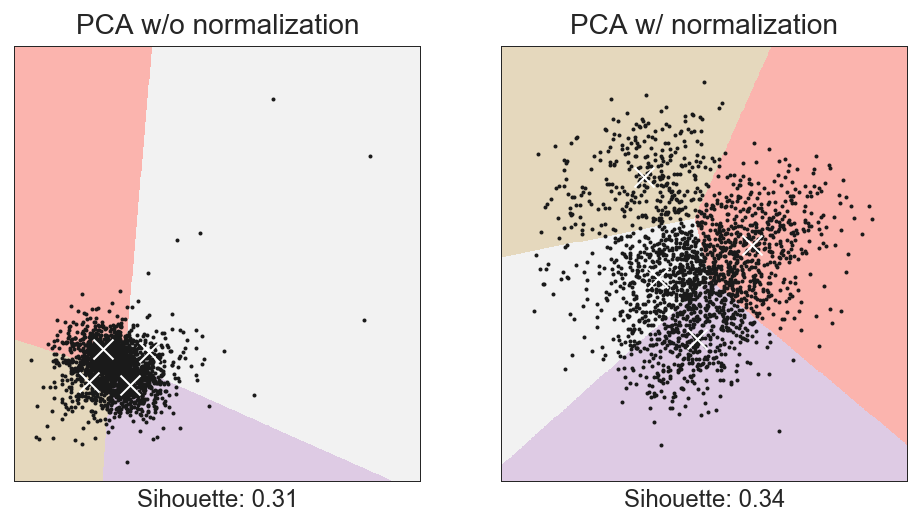

In [49]:
X = pca_reduced_data(aci_min_10, 26)
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(X, n_clusters=4)

PCA explained ratio: [ 0.28695607  0.39454863  0.48659793  0.54049727  0.58413375  0.62509259
  0.65842468  0.68453597  0.70808882  0.72740591  0.74378127  0.75917208
  0.77400857  0.78735444  0.79949495  0.81117094  0.82235733  0.83307964
  0.84307792  0.85257585  0.86174447  0.87054304  0.87918301  0.88720352
  0.89494195  0.90251547]
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 4 The average silhouette_score is : 0.161842401018


n   pc1   pc2   pc3   pc4   pc5   pc6   pc7   pc8   pc9  pc10  pc11  \
0    39 -2.98 -1.34  9.57  4.55  0.78 -2.62  1.53  0.10 -0.48 -2.08 -1.20   
1   192  2.90  4.65  0.13 -0.10 -0.55 -0.04  0.08 -0.71  0.30  0.18 -0.28   
2   625  3.73 -0.87 -0.20 -0.10 -0.04 -0.31 -0.21  0.18 -0.01  0.14  0.15   
3  1113 -2.48 -0.29 -0.24 -0.08  0.09  0.27  0.05  0.02 -0.03 -0.04  0.01   

   pc12  pc13  pc14  pc15  pc16  pc17  pc18  pc19  pc20  pc21  pc22  pc23  \
0 -0.70  0.73 -0.19  0.48  0.04 -0.16 -0.06 -0.25  0.50 -0.25  0.12  0.23   
1  0.40  0.40 -0.29  0.46 -0.27  0.06  0.14  0.07 -0.23 -0.10  0.12  0.03   
2 -0.16  0.20  0.37 -0.16 -0.02 -0.03 -0.00 -0.12  0.00 -0.07 -0.02 -0.04   
3  0.04 -0.20 -0.15 -0.01  0.06  0.01 -0.02  0.06  0.02  0.07 -0.01  0.01   

   pc24  pc25  pc26  
0  0.01  0.13 -0.18  
1  0.07 -0.20 -0.10  
2  0.04  0.06 -0.01  
3 -0.03 -0.00  0.03

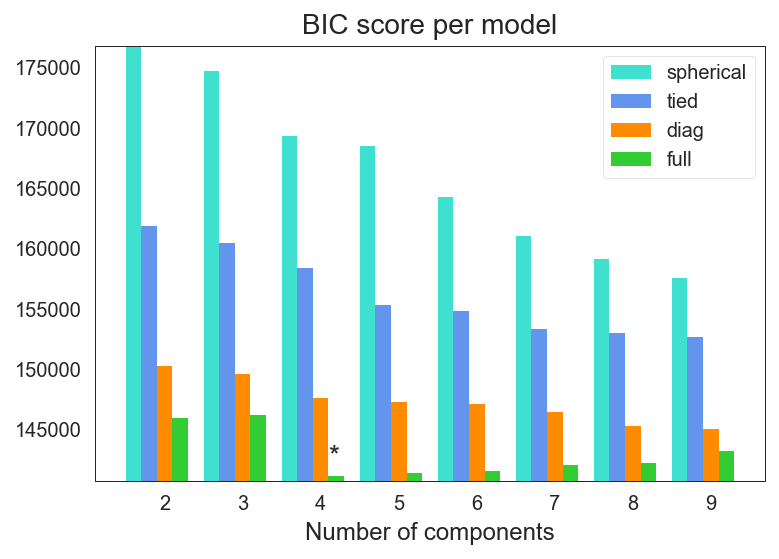

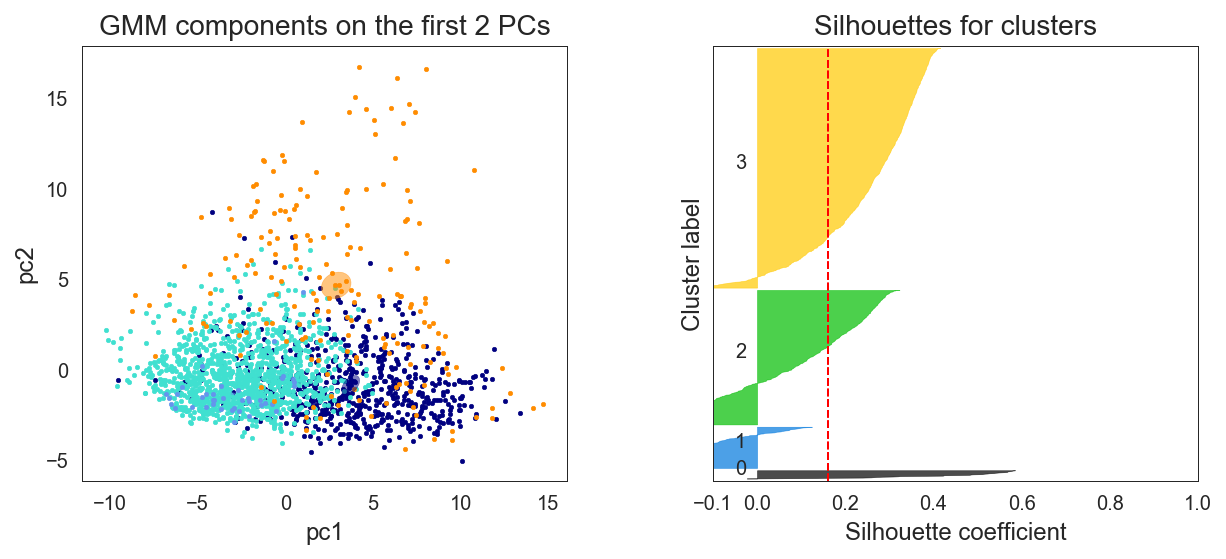

In [50]:
X = pca_reduced_data(aci_min_10, 26)
fig1, fig2, fitted1, model = fit_gmm(X)
fig2.savefig('../tex/aci-gmm.pdf', bbox_inches='tight')
display(fitted1)

### Question: what are the outliers (label 0)? 

In [51]:
pd.set_option('display.max_rows', 8)

labels = model.predict(X)
least_common_label = Counter(labels).most_common()[-1][0]
aci_min_10[np.array(labels) == least_common_label]

Female      Male     AgeU5    Age517   Age1824   Age2534  \
ct_id                                                                     
04013040507  0.583572  0.416428  0.000000  0.000000  0.012869  0.013187   
04013040527  0.517701  0.482299  0.033864  0.083120  0.019497  0.114161   
04013040528  0.539322  0.460678  0.000000  0.000000  0.003197  0.000000   
04013040529  0.537983  0.462017  0.000000  0.000000  0.000000  0.000000   
...               ...       ...       ...       ...       ...       ...   
32003005338  0.516078  0.483922  0.000000  0.000000  0.006853  0.014760   
32003005501  0.414380  0.585620  0.000000  0.076395  0.036424  0.066935   
32003005714  0.551493  0.448507  0.000000  0.000000  0.000000  0.000000   
55025000408  0.558217  0.441783  0.037326  0.000000  0.065181  0.158217   

              Age3544   Age4554   Age5559   Age6061   Age6264   Age6574  \
ct_id                                                                     
04013040507  0.007626  0.028758  0.032094  0.016206  0.075469  0.259295   
04013040527  0.099538  0.119805  0.042329  0.023089  0.035146  0.162648   
04013040528  0.007992  0.024616  0.046196  0.041240  0.048593  0.493286   
04013040529  0.003108  0.016229  0.020028  0.063881  0.082182  0.525898   
...               ...       ...       ...       ...       ...       ...   
32003005338  0.018450  0.034792  0.040590  0.032683  0.073801  0.375329   
32003005501  0.038553  0.108562  0.139782  0.020814  0.085147  0.223746   
32003005714  0.022081  0.034027  0.049231  0.030045  0.126878  0.485430   
55025000408  0.031198  0.085794  0.022841  0.000000  0.068524  0.104735   

               Age75P  BornInState  BornInOtherState  NativeBornOutOfUS  \
ct_id                                                                     
04013040507  0.554496     0.029552          0.890054           0.003813   
04013040527  0.266803     0.257825          0.648538           0.029502   
04013040528  0.334879     0.004476          0.911765           0.004636   
04013040529  0.288674     0.013122          0.904696           0.006215   
...               ...          ...               ...                ...   
32003005338  0.402741     0.026357          0.831313           0.004217   
32003005501  0.203642     0.088458          0.818827           0.000000   
32003005714  0.252308     0.005249          0.856471           0.013756   
55025000408  0.426184     0.588858          0.347075           0.000000   

             ForeignBornNaturalized  ForeignBornNonCitizen     White  \
ct_id                                                                  
04013040507                0.044805               0.031776  0.955513   
04013040527                0.058748               0.005387  0.831965   
04013040528                0.055627               0.023497  0.961477   
04013040529                0.067680               0.008287  0.954765   
...                             ...                    ...       ...   
32003005338                0.119663               0.018450  0.860306   
32003005501                0.086093               0.006623  0.858798   
32003005714                0.108597               0.015928  0.816652   
55025000408                0.045125               0.018942  0.844011   

                Black     Asian  OtherRace  Hispanic  TwoOrMore  \
ct_id                                                             
04013040507  0.011439  0.024627   0.000000  0.008421   0.000000   
04013040527  0.033864  0.002822   0.000000  0.106721   0.024628   
04013040528  0.006234  0.002398   0.009751  0.014226   0.005914   
04013040529  0.000000  0.023135   0.000000  0.022099   0.000000   
...               ...       ...        ...       ...        ...   
32003005338  0.010543  0.025303   0.007380  0.091724   0.004744   
32003005501  0.010170  0.078997   0.002838  0.044465   0.004730   
32003005714  0.044887  0.080000   0.002896  0.044163   0.011403   
55025000408  0.035097  0.017827   0.002786  0.038997   0.061281   

      

In [52]:
aci_min_10.sample(8)

Female      Male     AgeU5    Age517   Age1824   Age2534  \
ct_id                                                                     
04013611900  0.480274  0.519726  0.059005  0.230532  0.115952  0.094340   
04013422511  0.500159  0.499841  0.048967  0.241971  0.082671  0.112560   
04013103400  0.515062  0.484938  0.061307  0.183708  0.067246  0.173738   
04013814200  0.524521  0.475479  0.060920  0.115709  0.110345  0.169349   
04013071512  0.496604  0.503396  0.026397  0.200988  0.057579  0.126119   
32003002829  0.513927  0.486073  0.052009  0.154301  0.063101  0.147400   
04013319101  0.346252  0.653748  0.040025  0.079416  0.597522  0.147395   
04013061026  0.535943  0.464057  0.072450  0.261385  0.066805  0.122883   

              Age3544   Age4554   Age5559   Age6061   Age6264   Age6574  \
ct_id                                                                     
04013611900  0.170840  0.170840  0.053173  0.007890  0.016810  0.063122   
04013422511  0.132909  0.171065  0.062321  0.026709  0.025437  0.061367   
04013103400  0.141281  0.160585  0.043912  0.028426  0.030547  0.079126   
04013814200  0.109962  0.126437  0.098084  0.040996  0.039080  0.093103   
04013071512  0.176598  0.194968  0.094319  0.023001  0.019759  0.058814   
32003002829  0.130638  0.162682  0.128913  0.022430  0.014789  0.077397   
04013319101  0.076557  0.034307  0.012706  0.006989  0.005083  0.000000   
04013061026  0.198720  0.086752  0.023335  0.017313  0.048551  0.074708   

               Age75P  BornInState  BornInOtherState  NativeBornOutOfUS  \
ct_id                                                                     
04013611900  0.017496     0.439451          0.472041           0.009262   
04013422511  0.034022     0.398728          0.518283           0.009857   
04013103400  0.030123     0.408570          0.456088           0.008910   
04013814200  0.036015     0.273946          0.622222           0.010345   
04013071512  0.021457     0.421426          0.465267           0.007564   
32003002829  0.046340     0.211240          0.608824           0.008874   
04013319101  0.000000     0.366264          0.328145           0.016836   
04013061026  0.027098     0.357170          0.556078           0.009409   

             ForeignBornNaturalized  ForeignBornNonCitizen     White  \
ct_id                                                                  
04013611900                0.053516               0.025729  0.768439   
04013422511                0.053736               0.019396  0.819078   
04013103400                0.057913               0.068519  0.682435   
04013814200                0.086207               0.007280  0.766284   
04013071512                0.100803               0.004940  0.753782   
32003002829                0.075425               0.095637  0.557062   
04013319101                0.020966               0.267789  0.391995   
04013061026                0.043470               0.033873  0.737674   

                Black     Asian  OtherRace  Hispanic  TwoOrMore  \
ct_id                                                             
04013611900  0.029503  0.073756   0.010978  0.107719   0.009605   
04013422511  0.013037  0.023847   0.003498  0.117647   0.022893   
04013103400  0.024820  0.003818   0.003606  0.257743   0.027577   
04013814200  0.037165  0.055172   0.000000  0.095402   0.045977   
04013071512  0.005403  0.063137   0.013276  0.148966   0.015437   
32003002829  0.035741  0.069017   0.015036  0.271383   0.051762   
04013319101  0.062262  0.197586   0.050508  0.283672   0.013977   
04013061026  0.042529  0.023335   0.002446  0.176515   0.017501   

             MedHouseIncome     ...       AtLeastBachelor  PopPerHousing  \
ct_id                           ...                                        
04013611900         81250.0     ...              0.346220       4.182209   
04013422511         79615.0     ...              0.381726       3.897150   
04013103400         53206.0     ...              0.239358       3.

Compare to a random sample, this cluster seems to **have fewer young people**.

<a name="perf-eval"></a>

# Clustering Performance Evaluation 

### Best model for ACI

This model is used as 'ground truth' for clustering.

In [53]:
# Covariance type: full
# number of components: 4
# PCA: Yes, 16D
aci_min_10_26d = pca_reduced_data(aci_min_10, 26)
best_gmm = GaussianMixture(covariance_type='full', n_components=4)

PCA explained ratio: [ 0.28695607  0.39454863  0.48659793  0.54049727  0.58413375  0.62509259
  0.65842468  0.68453597  0.70808882  0.72740592  0.74378103  0.75917185
  0.77400848  0.78735445  0.79949534  0.81116996  0.8223562   0.8330774
  0.84307688  0.85257292  0.8617421   0.870539    0.87918607  0.88721802
  0.89496117  0.90258647]


### Best model for Yelp data

In [54]:
# Init: KMeans++
# Number of clusters: 4
best_kmeans = KMeans(n_clusters=4)
ct_stats_min_10_w = weighted_stats(ct_stats_min_10)

### The confusion matrix

In [55]:
def create_confusion_matrix(true_labels, pred_labels):
    
    dim_true, dim_pred = len(set(true_labels)), len(set(pred_labels))
    m = np.zeros((dim_pred + 1, dim_true + 2), dtype=np.int)
    
    for i, j in zip(pred_labels, true_labels):
        m[i, j] += 1
            
    # column sum
    m[:,-2:-1] = m.sum(axis=1, keepdims=True)
    # row sum
    m[-1:,:] = m.sum(axis=0, keepdims=True)
        
    pd.set_option('display.max_rows', 10)
    
    m_df = pd.DataFrame(m)
    m_df.columns = list(m_df.columns[:-2]) + ['Total', "Purity"]
    m_df.index = list(m_df.index[:-1]) + ["Total"]
    
    # the max overlay per cluster
    max_per_cl = m_df.iloc[:, :-2].max(axis=1)
    # purity for each cluster
    m_df['Purity'] = max_per_cl / m_df['Total']
    # the global purity
    m_df.loc['Total', 'Purity'] = max_per_cl[:-1].sum() / m_df['Total']['Total']
    # round precision to 4 digits
    m_df['Purity'] = m_df['Purity'].round(4)
    pd.set_option('display.max_rows', 5)
    return m_df

def test_and_compare(model1, X1, model2, X2=None):
    """
    Test clustering of two models, possibly on two different
    datasets. Then compare cluster overlays.
    
    X1 and X2 must have the set of same indices,
    although the order of the samples does not matter.
    """
    if X2 is None:
        X2 = X1
    model1.fit(X1)
    model2.fit(X2)
    df1 = pd.DataFrame({'true': model1.predict(X1)}, index=X1.index)
    df2 = pd.DataFrame({'pred': model2.predict(X2)}, index=X2.index)
    # concat will respect index name
    merged = pd.concat([df1, df2], axis=1)
    return create_confusion_matrix(df1['true'], merged['pred'])

#### Test and compare

In [56]:
t1 = test_and_compare(
    GaussianMixture(4, 'full'), aci_min_10_26d,
    KMeans(n_clusters=4), ct_stats_min_10
)
display(t1)
print(t1.to_latex())

0     1   2    3  Total  Purity
0      356   618  12  117   1103  0.5603
1       14    29   1    1     45  0.6444
2      191   299  10   52    552  0.5417
3       77   155  16   21    269  0.5762
Total  638  1101  39  191   1969  0.5592

\begin{tabular}{lrrrrrr}
\toprule
{} &    0 &     1 &   2 &    3 &  Total &  Purity \\
\midrule
0     &  356 &   618 &  12 &  117 &   1103 &  0.5603 \\
1     &   14 &    29 &   1 &    1 &     45 &  0.6444 \\
2     &  191 &   299 &  10 &   52 &    552 &  0.5417 \\
3     &   77 &   155 &  16 &   21 &    269 &  0.5762 \\
Total &  638 &  1101 &  39 &  191 &   1969 &  0.5592 \\
\bottomrule
\end{tabular}



In [57]:
aci_data = aci_min_10
ct_stats_data = standardized(ct_stats_min_10[['n_biz', 'n_biz_in_2km', 'review_count']])

test_and_compare(
    GaussianMixture(4, 'full'), aci_data,
    KMeans(4), ct_stats_data
)

0   1    2    3  Total  Purity
0      113  29  566  530   1238  0.4572
1        2   1    5    4     12  0.4167
2       16   4   87   58    165  0.5273
3       47  20  232  255    554  0.4603
Total  178  54  890  847   1969  0.4637

In [58]:
aci_data = aci_min_10_26d
ct_stats_data = weighted_stats(ct_stats_min_10)

test_and_compare(
    GaussianMixture(6, 'full'), aci_data,
    KMeans(3), ct_stats_data
)

0    1   2    3  4    5  Total  Purity
0      449  632  16  229  0  110   1436  0.4401
1       16   35   3   11  1    2     68  0.5147
2      131  208  19   80  0   27    465  0.4473
Total  596  875  38  320  1  139   1969  0.4444

The result is not too exciting. Because of the unbalance in cluster sizes, basically all predicted clusters were matched
to the largest "natural" cluster, artifically inflating the purity score.

We would at least want our clusters with census data to have even cluster sizes.

### Further optimization

To make the model more interpretable, we limit the choice the census variables and reduce the noises.

Since the clusters of businesses have shown that business density is the strongest classifier for business dynamics. We use Random Forest to pick the most important census variables that are associated with business density.

In [59]:
from sklearn.ensemble import RandomForestRegressor


X, y = aci_min_10.sort_index(), ct_stats_min_10.loc[:,'n_biz_in_2km'].sort_index()

rf = RandomForestRegressor(200, max_depth=4, random_state=0)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [60]:
feature_imp = rf.feature_importances_
imp_features = feature_imp.argsort()[:-5:-1]
X.columns[imp_features]

Index(['HH_Nonfamily', 'BornInState', 'PopDen', 'GINI'], dtype='object')

Now do the clustering again.

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=9, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
For n_clusters = 3 The average silhouette_score is : 0.268813671476


n  HH_Nonfamily  BornInState  PopDen  GINI
0   345          1.12        -0.13    0.76  0.92
1   509         -0.11         1.33   -0.52 -0.08
2  1115         -0.37        -0.57   -0.04 -0.31

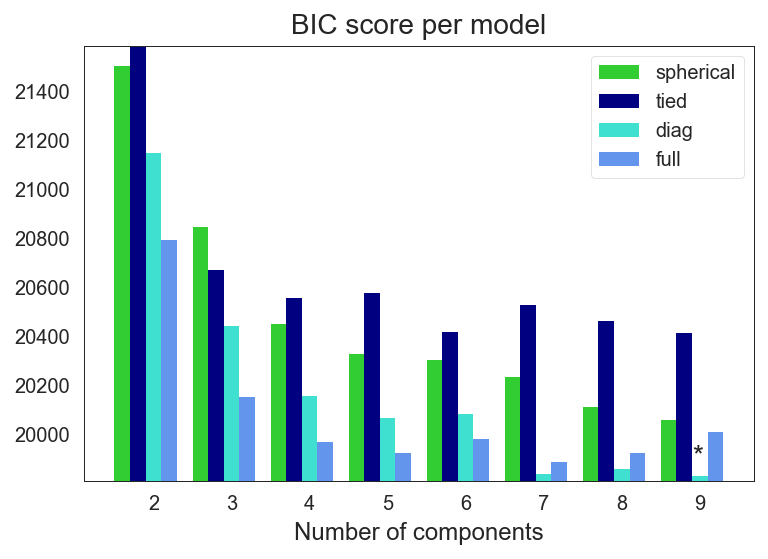

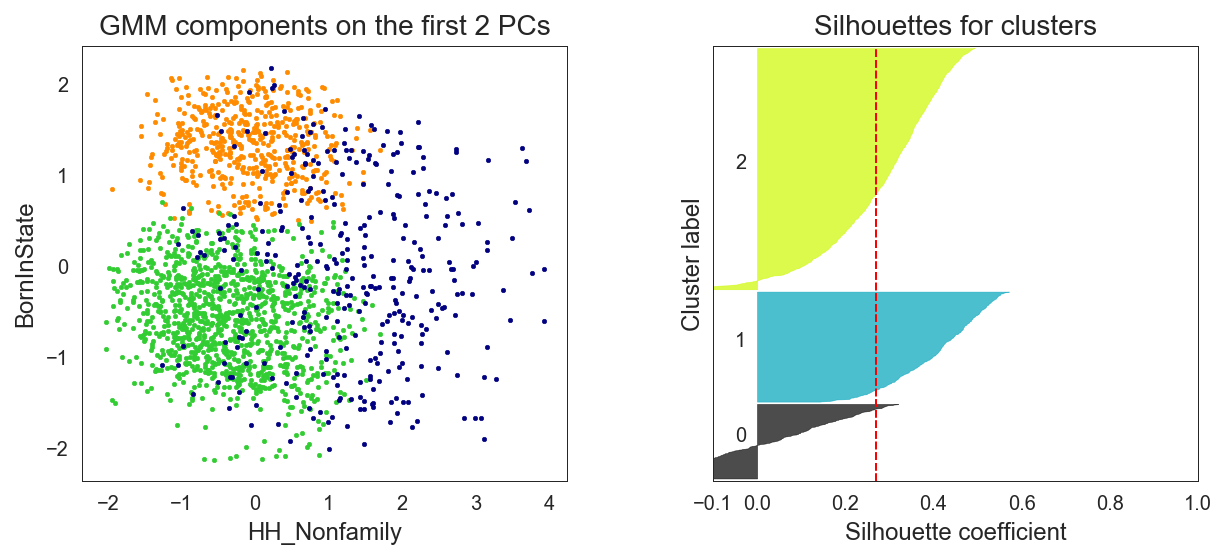

In [61]:
aci_min_10_imp_s = standardized(X.iloc[:, imp_features])

fig1, fig2, fitted1, best_gmm = fit_gmm(aci_min_10_imp_s, force_k=3)
fig2.savefig('../tex/aci-rf-gmm.pdf', bbox_inches='tight')
display(fitted1)

Original:
For n_clusters = 4 The average silhouette_score is : 0.280460868414


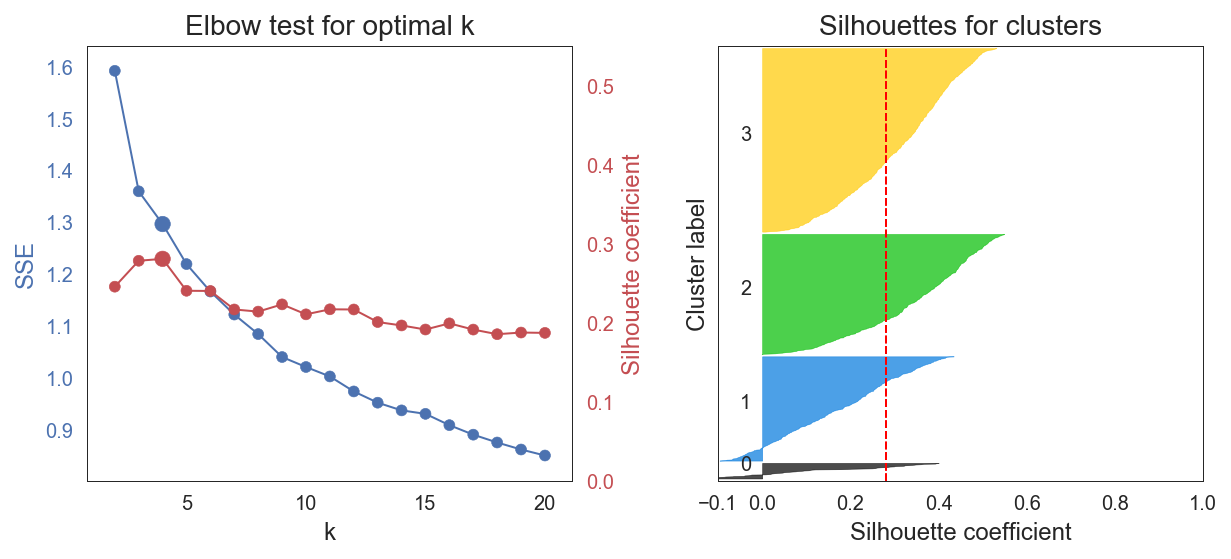

Normalized:
For n_clusters = 4 The average silhouette_score is : 0.288318048168


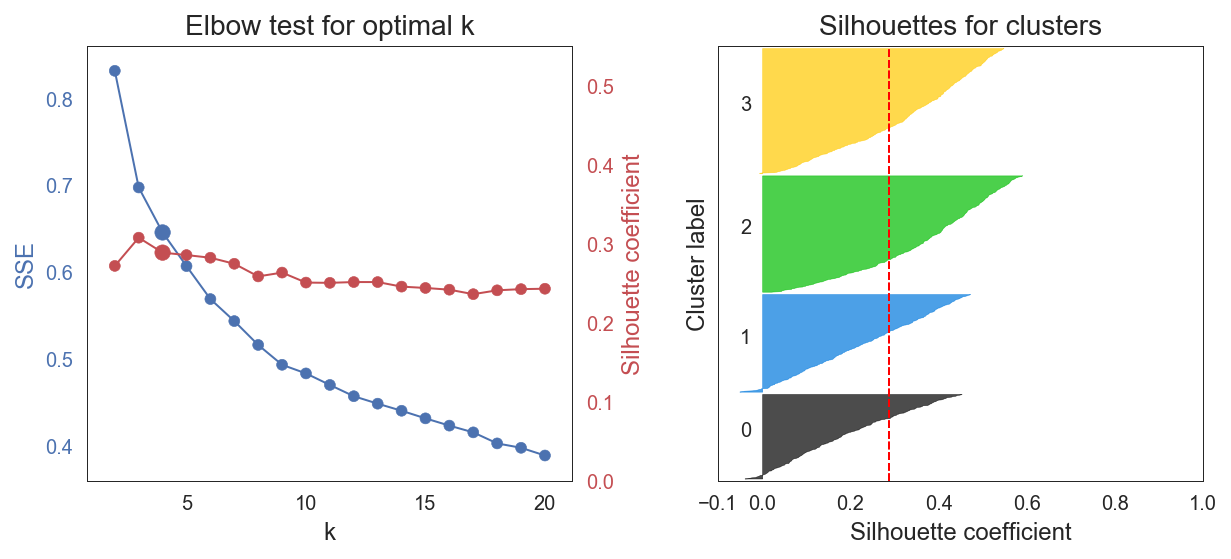

Original vs Normalized on PCA:
Without normalization:
PCA explained ratio: [ 0.40673219  0.677417  ]
With normalization
PCA explained ratio: [ 0.34223136  0.64003552]


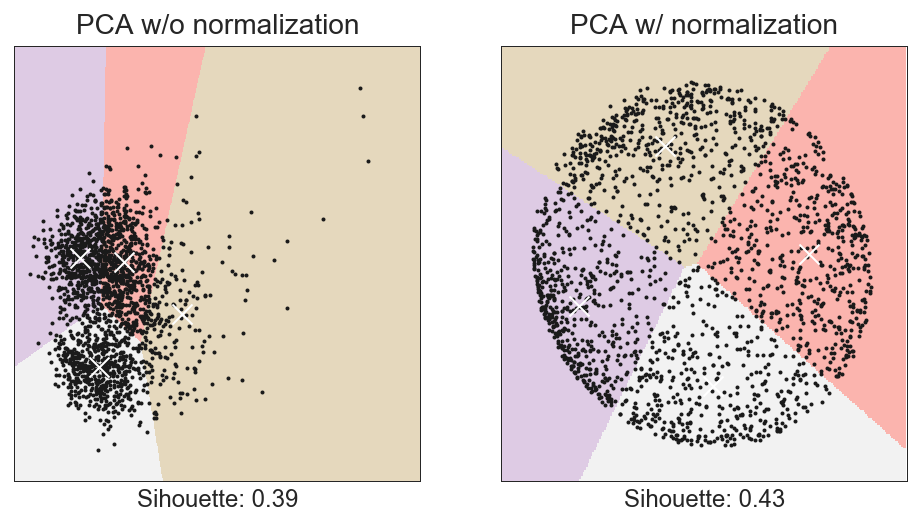

In [62]:
fig1, fig2, fig3, fitted1, fitted2, model = kmeans_and_pca(aci_min_10_imp_s)

In [63]:
aci_data = aci_min_10_imp_s
ct_stats_data = ct_stats_min_10

t2 = test_and_compare(
    GaussianMixture(4, 'full'), aci_data,
    KMeans(4), ct_stats_data
)
display(t2)
print(t2.to_latex())

0    1    2    3  Total  Purity
0       9  431  190  473   1103  0.4288
1      13    7   25    0     45  0.5556
2      24  324  176   28    552  0.5870
3      45   88  131    5    269  0.4870
Total  91  850  522  506   1969  0.4840

\begin{tabular}{lrrrrrr}
\toprule
{} &   0 &    1 &    2 &    3 &  Total &  Purity \\
\midrule
0     &   9 &  431 &  190 &  473 &   1103 &  0.4288 \\
1     &  13 &    7 &   25 &    0 &     45 &  0.5556 \\
2     &  24 &  324 &  176 &   28 &    552 &  0.5870 \\
3     &  45 &   88 &  131 &    5 &    269 &  0.4870 \\
Total &  91 &  850 &  522 &  506 &   1969 &  0.4840 \\
\bottomrule
\end{tabular}



In [64]:
aci_data = standardized(aci_min_10_imp_s)
ct_stats_data = standardized(weighted_stats(ct_stats_min_10))

t2 = test_and_compare(
    GaussianMixture(4, 'full'), aci_data,
    KMeans(4), ct_stats_data
)
display(t2)
print(t2.to_latex())

0    1    2    3  Total  Purity
0      12  398  191   33    634  0.6278
1      25   84   75  298    482  0.6183
2      34   29  114   15    192  0.5938
3      20  339  142  160    661  0.5129
Total  91  850  522  506   1969  0.5835

\begin{tabular}{lrrrrrr}
\toprule
{} &   0 &    1 &    2 &    3 &  Total &  Purity \\
\midrule
0     &  12 &  398 &  191 &   33 &    634 &  0.6278 \\
1     &  25 &   84 &   75 &  298 &    482 &  0.6183 \\
2     &  34 &   29 &  114 &   15 &    192 &  0.5938 \\
3     &  20 &  339 &  142 &  160 &    661 &  0.5129 \\
Total &  91 &  850 &  522 &  506 &   1969 &  0.5835 \\
\bottomrule
\end{tabular}

